## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera Calibration and Distortion correction

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img',img)
        #cv2.waitKey(500)

#cv2.destroyAllWindows()

def undistort_image(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return cv2.undistort(img, mtx, dist, None, mtx)

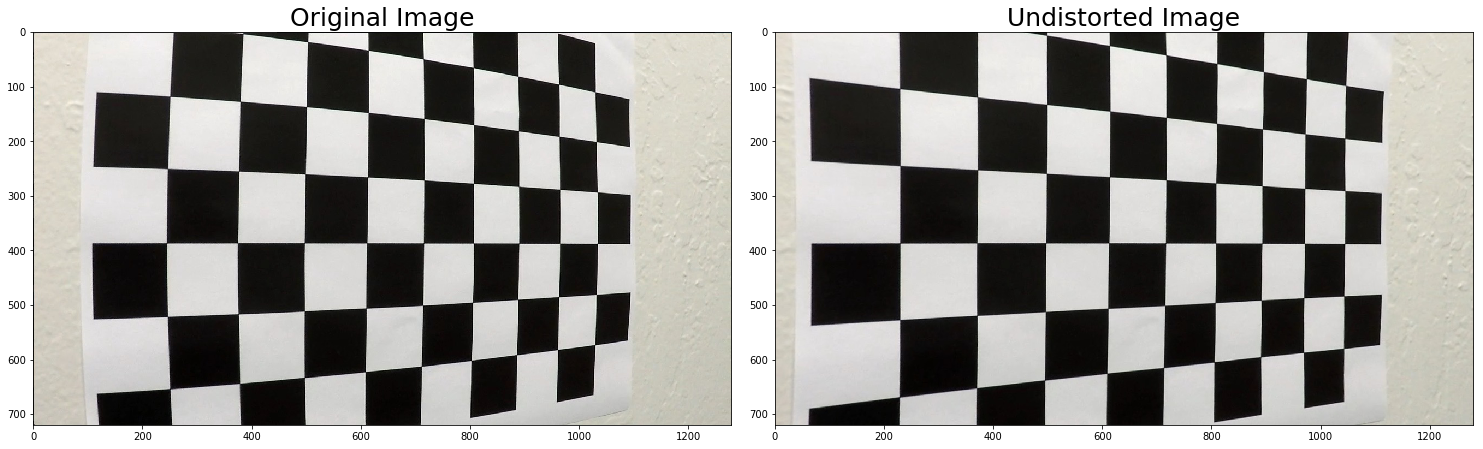

In [3]:
#test undistort_image function
img_org = mpimg.imread('./camera_cal/calibration5.jpg')
img_undistorted = undistort_image(img_org,objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(img_org)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(img_undistorted)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
f.savefig('output_images/undistort_output.jpg')

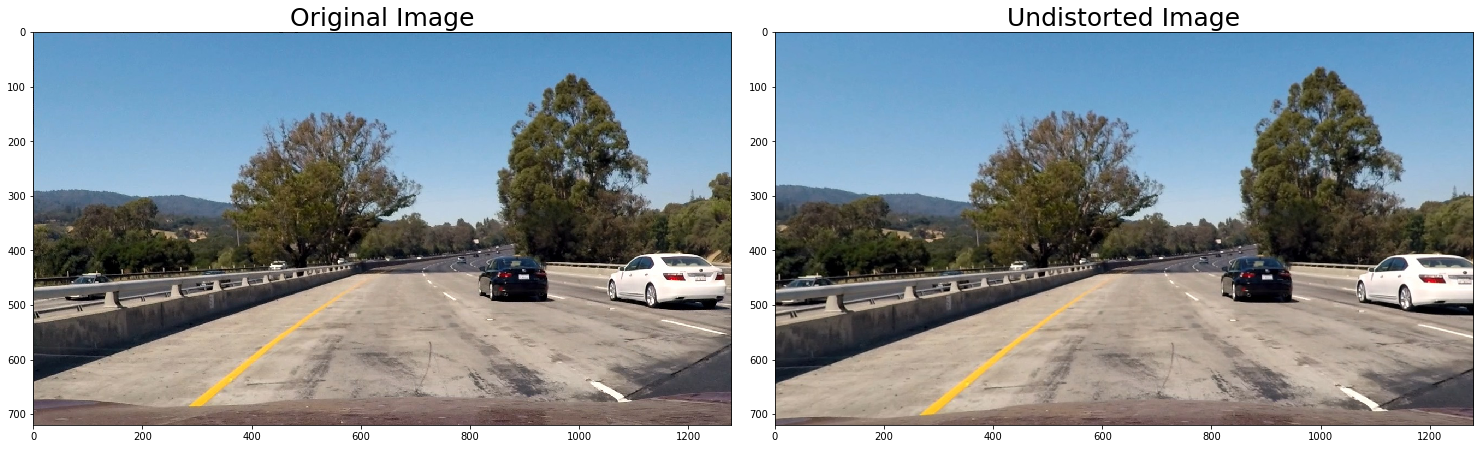

In [4]:
#test undistort_image function
img_org = mpimg.imread('./test_images/test1.jpg')
img_undistorted = undistort_image(img_org,objpoints, imgpoints)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(img_org)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(img_undistorted)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
f.savefig('output_images/undistort_output2.jpg')

## Color/gradient Threshold


In [5]:
# Retuns binary image based on thresholding functions
def pipeline(img,sobel_kernel=3,sx_thresh=(20,100), s_thresh=(180,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
 
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx) 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
 
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
 
        # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary


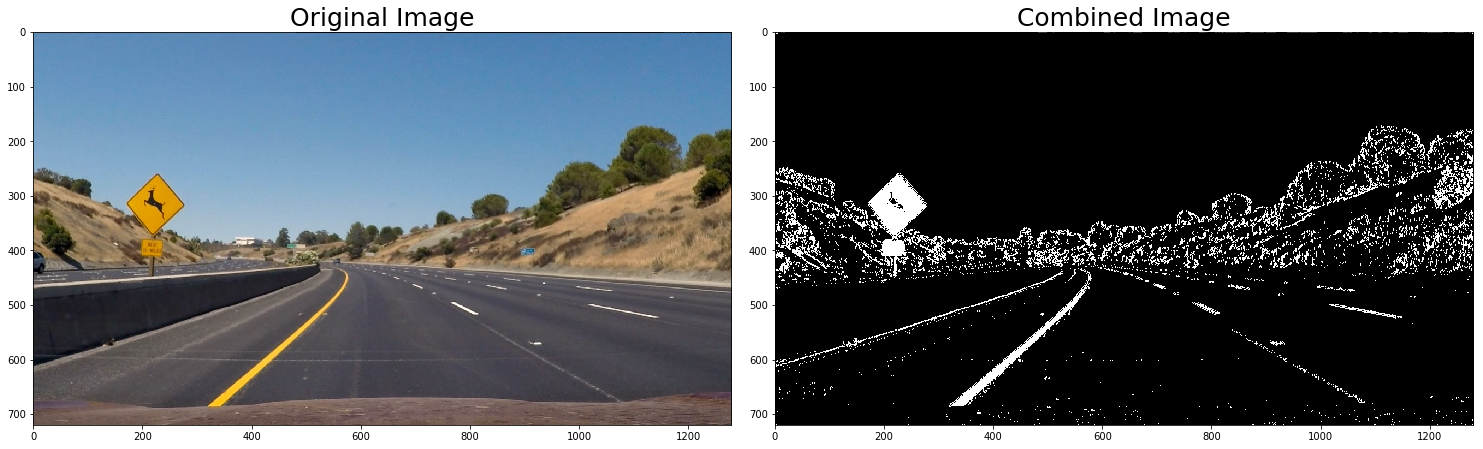

In [6]:
# Read in an image
test_image = mpimg.imread('./test_images/test2.jpg')

# Obtain binary image
combined = pipeline(test_image)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(combined, cmap='gray')
ax2.set_title('Combined Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
f.savefig('output_images/binary_combo_example.jpg')

## Perspective Transformation

In [7]:
img_size = (img.shape[1], img.shape[0])
src = np.float32([[585, 460],[695, 460],[1126, 720],[203, 720]])
dst = np.float32([[275, 0],[1025,0], [960, 720], [320, 720]])

def warp(img, src, dst):
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

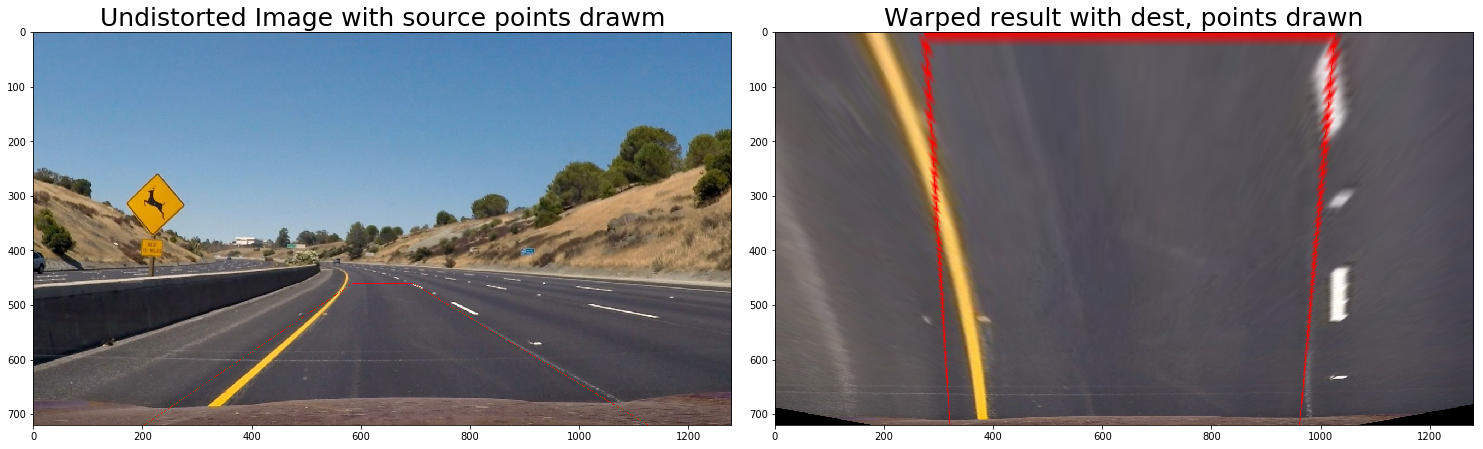

In [8]:
def make_plot(img, points, color=[255,0,0], thickness=1):
#    image = np.copy(img)
    cv2.line(img, (points[0][0], points[0][1]), (points[1][0], points[1][1]), color, thickness)
    cv2.line(img, (points[1][0], points[1][1]), (points[2][0], points[2][1]), color, thickness)
    cv2.line(img, (points[2][0], points[2][1]), (points[3][0], points[3][1]), color, thickness)
    cv2.line(img, (points[3][0], points[3][1]), (points[0][0], points[0][1]), color, thickness)
    return img

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.set_title('Undistorted Image with source points drawm',fontsize=25)
ax1.imshow(make_plot(test_image, src))
ax2.set_title('Warped result with dest, points drawn',fontsize=25)
warped_img, M, Minv = warp(test_image,src,dst)
ax2.imshow(make_plot(warped_img, dst))
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)   
plt.show()
f.savefig('output_images/warped_straight_lines.jpg')

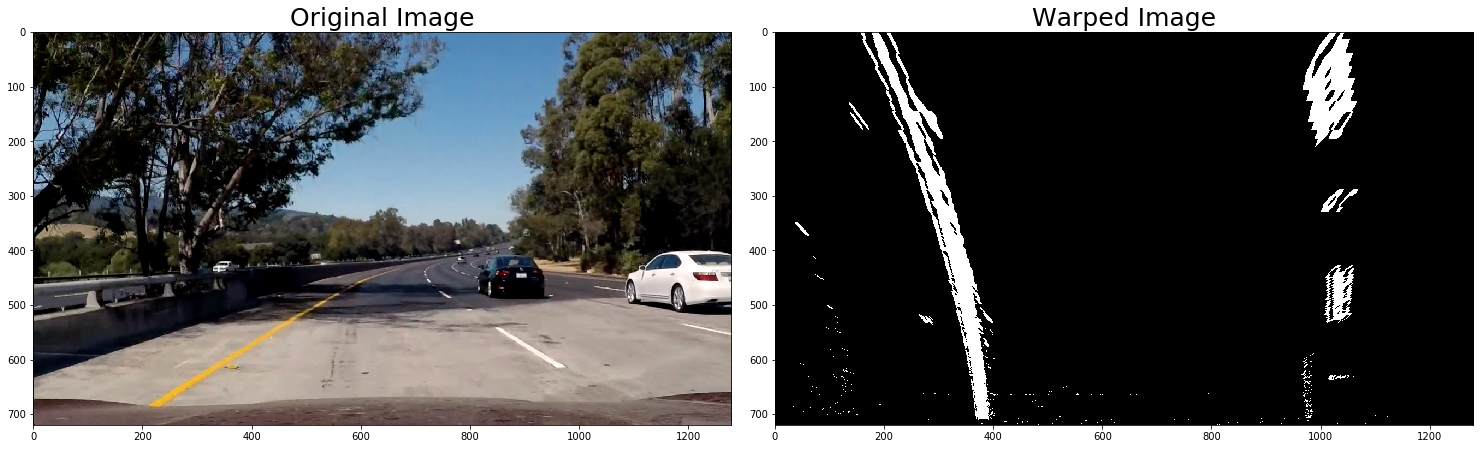

In [26]:
# Obtain binary image
warped_img, M, Minv = warp(combined, src, dst)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(warped_img, cmap='gray')
ax2.set_title('Warped Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

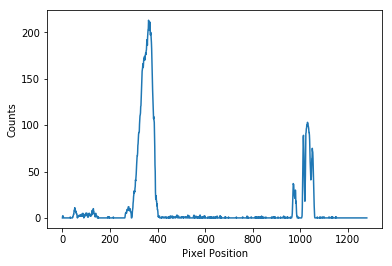

In [27]:
# Histogram Plotting
histogram = np.sum(warped_img[warped_img.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.xlabel('Pixel Position')
plt.ylabel('Counts')
plt.show()

## Find the Lines


In [11]:

# Take a histogram of the bottom half of the image
#
# Create an output image to draw on and  visualize the result
def sliding_fit(img, margin=100, minpix=50):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    rectangles = []

# Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangles.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles

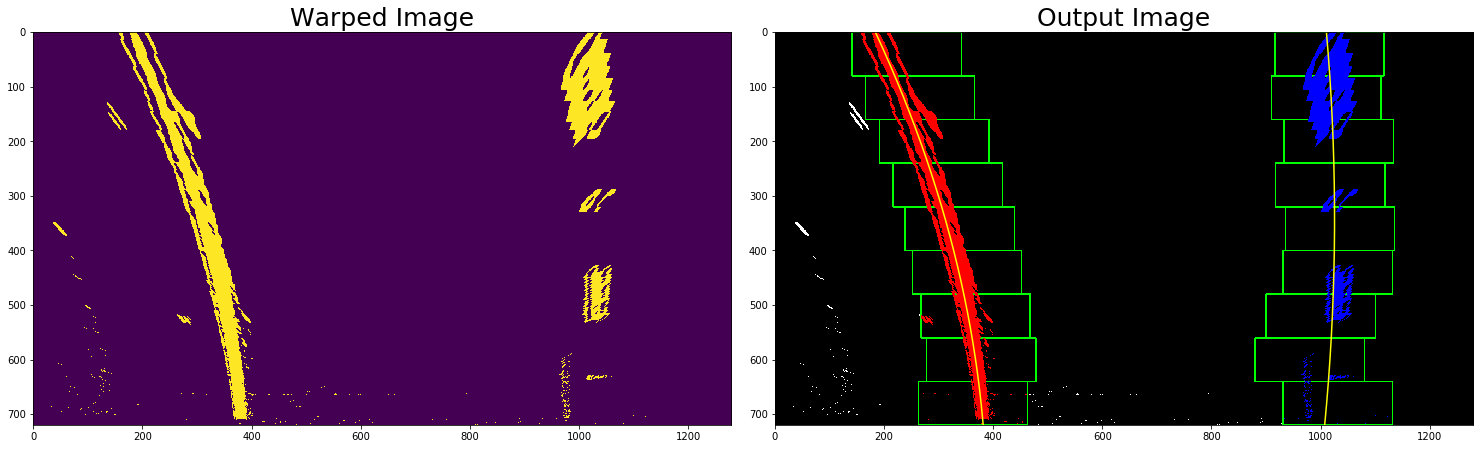

In [12]:
#Visualization
out_img = np.dstack((warped_img, warped_img, warped_img))*255
left_fit, right_fit, left_lane_inds, right_lane_inds, rectangles = sliding_fit(warped_img)
ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

for rectangle in rectangles: 
    cv2.rectangle(out_img, (rectangle[5], rectangle[1]), (rectangle[4], rectangle[0]), (0,255,0), 2) 
    cv2.rectangle(out_img, (rectangle[3], rectangle[1]), (rectangle[2], rectangle[0]), (0,255,0), 2) 
    
nonzero = warped_img.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.set_title('Warped Image',fontsize=25)
ax1.imshow(warped_img)
ax2.set_title('Output Image',fontsize=25)
ax2.imshow(out_img)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
f.savefig('output_images/color_fit_lines.jpg')


In [13]:
def further_fit(img, left_fit, right_fit):
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit_new = np.polyfit(lefty, leftx, 2)
    right_fit_new = np.polyfit(righty, rightx, 2)
    
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds


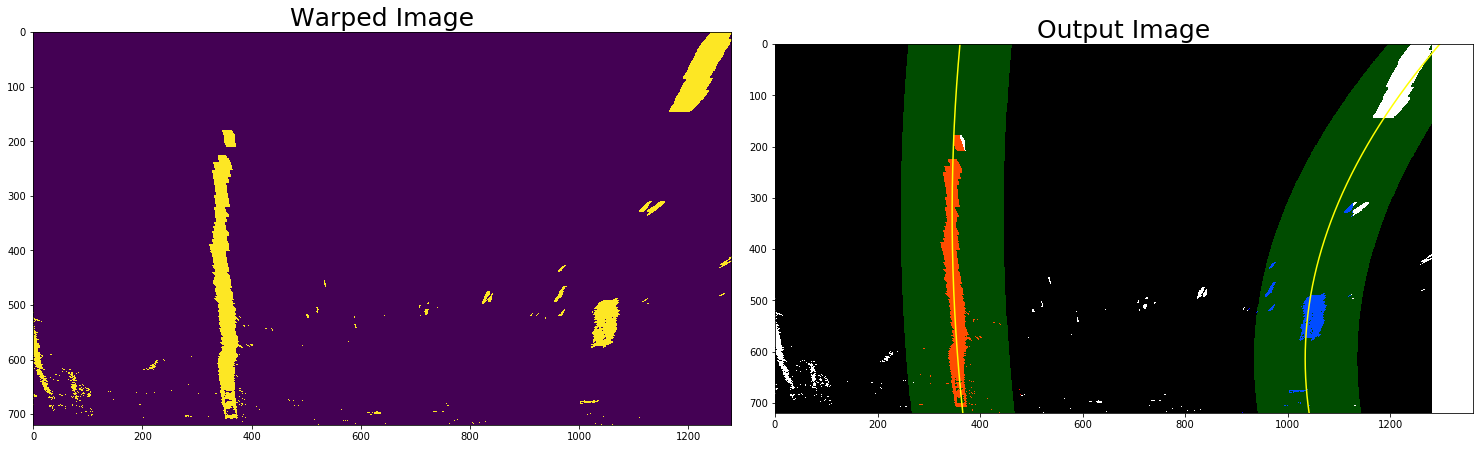

In [14]:
# Visulalization
test_image_new = mpimg.imread('./test_images/test4.jpg')
combined_new = pipeline(test_image_new)
warped_img_new, _, Minv = warp(combined_new, src, dst)

left_fit_new, right_fit_new, left_lane_inds_new, right_lane_inds_new = further_fit(warped_img_new, left_fit, right_fit)
ploty = np.linspace(0, warped_img_new.shape[0]-1, warped_img_new.shape[0] )
left_fitx = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
right_fitx = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped_img_new, warped_img_new, warped_img_new))*255
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = warped_img_new.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds_new], nonzerox[left_lane_inds_new]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds_new], nonzerox[right_lane_inds_new]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
margin = 100
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.tight_layout()
ax1.set_title('Warped Image',fontsize=25)
ax1.imshow(warped_img_new)
ax2.set_title('Output Image',fontsize=25)
ax2.imshow(result)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

## Measure Curvature and Offset

In [15]:
def compute_curvature_offset(img, left_fit, right_fit):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    lane_center = np.mean([left_fitx[-1], right_fitx[-1]])
    offset = ((img.shape[1] / 2) - lane_center) * xm_per_pix
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm', offset, 'm')
    return left_curverad, right_curverad, offset

In [16]:
def add_measurements(img, left_curverad, right_curverad, offset):
    # add curverature to image
    text = "Radius of Curvature= {:.2f}(m)".format(int((left_curverad + right_curverad)/2))
    cv2.putText(img, text, (50,50), cv2.FONT_HERSHEY_DUPLEX, 1,(0,255,0), 1)
    
    # add lane offset to image
    if offset > 0:
        text = "Vehicle is {:.2f}m right of center".format(offset)
    elif offset < 0:
        text = "Vehicle is {:.2f}m left of center".format(offset)
    cv2.putText(img, text, (50,100), cv2.FONT_HERSHEY_DUPLEX, 1,(0,255,0), 1)
    return img

## Draw Lines

In [17]:
def draw(img, warped_img, left_fit, right_fit, Minv):
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    ploty = np.linspace(0, warped_img.shape[0]-1, warped_img.shape[0])

       
    left_fitx = left_fit[0]*ploty**2 +left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

In [18]:
def process_image(img):
    combined_img = pipeline(img)
    warped_img, M, Minv = warp(combined_img, src, dst)
    
    if not left_line.detected or not right_line.detected:
        left_fit, right_fit, left_lane_inds, right_lane_inds, _ = sliding_fit(warped_img)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = further_fit(warped_img, left_line.best_fit, right_line.best_fit)

    left_line.lane_fit(left_fit)
    right_line.lane_fit(right_fit)
    
    img = draw(img, combined_img, left_line.best_fit, right_line.best_fit, Minv)
    left_curverad, right_curverad, offset = compute_curvature_offset(img, left_fit, right_fit)
    final_img =add_measurements(img, left_curverad, right_curverad, offset)

    return final_img

In [19]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def lane_fit(self, fit):
        if self.best_fit is not None:
            self.diffs = abs(fit-self.best_fit)
        if (self.diffs[0] > 0.01 or self.diffs[1] > 1.0 or self.diffs[2] > 100.0) and len(self.current_fit) > 0:
            self.detected = False
        else:
            self.detected = True
            
            self.current_fit.append(fit)

            if len(self.current_fit) > 5:
                self.current_fit = self.current_fit[len(self.current_fit)- 5:]
            self.best_fit = np.average(self.current_fit, axis=0)
      

965.311615374 m 658.942098576 m 0.035810765259 m


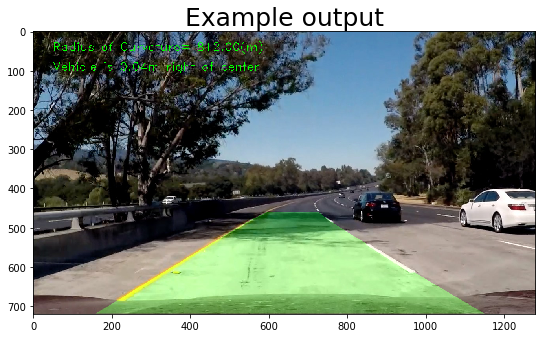

In [20]:
test_image = mpimg.imread('./test_images/test5.jpg')
left_line = Line()
right_line = Line()
new_img = process_image(test_image)
f, ax = plt.subplots(figsize=(9, 6))
ax.imshow(new_img)
ax.set_title('Example output',fontsize=25)
plt.show()
f.savefig('output_images/example_output.jpg')

## Video Test

In [21]:

left_line = Line()
right_line = Line()

video_output = 'project_video_output.mp4'
video_input = VideoFileClip('project_video.mp4')
processed_video = video_input.fl_image(process_image)
processed_video.write_videofile(video_output, audio=False)

594.172604948 m 995.698047157 m -0.291387400522 m
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

670.102395492 m 983.433307135 m -0.296658387482 m
681.115913878 m 1014.38648668 m -0.301939516719 m


  0%|▏                                                                                | 2/1261 [00:00<01:46, 11.80it/s]

617.560701842 m 570.434621687 m -0.282853913318 m
785.943880146 m 554.265015848 m -0.300913401982 m


  0%|▎                                                                                | 4/1261 [00:00<01:46, 11.76it/s]

733.133909453 m 678.403603222 m -0.313946690678 m
722.617455995 m 930.543521374 m -0.327598298366 m


  0%|▍                                                                                | 6/1261 [00:00<01:47, 11.72it/s]

634.41856701 m 1648.16743092 m -0.346928786123 m
652.47303634 m 1276.5650501 m -0.443370509992 m


  1%|▌                                                                                | 8/1261 [00:00<01:49, 11.46it/s]

714.995000025 m 1000.13871776 m -0.44673289877 m
711.550193816 m 1210.88099039 m -0.422776501471 m


  1%|▋                                                                               | 10/1261 [00:00<01:46, 11.79it/s]

741.491554709 m 2033.70307012 m -0.353722136596 m
808.542163746 m 5225.66117186 m -0.360329861262 m


  1%|▊                                                                               | 12/1261 [00:01<01:43, 12.03it/s]

841.98714918 m 2106.73000983 m -0.346359648519 m
995.022908538 m 5746.32385192 m -0.353291267525 m


  1%|▉                                                                               | 14/1261 [00:01<01:41, 12.24it/s]

970.436455365 m 769.508360446 m -0.316218593075 m
1587.31803653 m 637.119920273 m -0.316042891663 m


  1%|█                                                                               | 16/1261 [00:01<01:39, 12.50it/s]

1169.25664107 m 886.116973308 m -0.315412069965 m
1272.03345229 m 1338.41390425 m -0.32263427015 m


  1%|█▏                                                                              | 18/1261 [00:01<01:37, 12.71it/s]

1103.27883255 m 1600.93621031 m -0.319271141642 m
1101.89121058 m 3803.74741201 m -0.336854603643 m


  2%|█▎                                                                              | 20/1261 [00:01<01:37, 12.71it/s]

1093.67679259 m 3481.14759006 m -0.366398784834 m
1090.40152228 m 1955.33584464 m -0.363807628823 m


  2%|█▍                                                                              | 22/1261 [00:01<01:38, 12.58it/s]

990.881560932 m 2501.66259251 m -0.334494732928 m
906.336677132 m 1038.55722171 m -0.261708731967 m


  2%|█▌                                                                              | 24/1261 [00:01<01:38, 12.55it/s]

897.818187218 m 871.145443852 m -0.255431678444 m
1019.91849332 m 1107.35152595 m -0.26171167774 m


  2%|█▋                                                                              | 26/1261 [00:02<01:37, 12.69it/s]

965.156083054 m 1574.13011159 m -0.265178645425 m
982.552476709 m 1657.70661819 m -0.26079807079 m


  2%|█▊                                                                              | 28/1261 [00:02<01:35, 12.94it/s]

996.020984051 m 812.103983033 m -0.247481712851 m
933.847526127 m 531.183526338 m -0.237367051818 m


  2%|█▉                                                                              | 30/1261 [00:02<01:34, 12.97it/s]

835.964593662 m 639.26259964 m -0.248984989102 m
679.401783228 m 1089.9990942 m -0.264180255263 m


  3%|██                                                                              | 32/1261 [00:02<01:40, 12.25it/s]

664.327996898 m 3890.99260416 m -0.304719888029 m
604.809117178 m 2033.33398124 m -0.353104159046 m


  3%|██▏                                                                             | 34/1261 [00:02<01:38, 12.50it/s]

583.816401442 m 2698.95541103 m -0.332084391746 m
534.06711019 m 713.217564775 m -0.243715577682 m


  3%|██▎                                                                             | 36/1261 [00:02<01:36, 12.73it/s]

520.887620225 m 793.576181906 m -0.250392257777 m
472.742822236 m 1259.10762253 m -0.264888871834 m


  3%|██▍                                                                             | 38/1261 [00:03<01:35, 12.77it/s]

483.664322263 m 518.257505709 m -0.23088631027 m
479.242294521 m 450.254203266 m -0.229463091749 m


  3%|██▌                                                                             | 40/1261 [00:03<01:37, 12.56it/s]

499.358685176 m 512.807722296 m -0.245619063213 m
521.667504559 m 550.398678089 m -0.256547260923 m


  3%|██▋                                                                             | 42/1261 [00:03<01:35, 12.82it/s]

541.877671283 m 592.029813451 m -0.271523623703 m
522.670964489 m 687.491872117 m -0.274645309759 m


  3%|██▊                                                                             | 44/1261 [00:03<01:40, 12.16it/s]

594.826719334 m 1028.67661041 m -0.304681433603 m
618.185157404 m 23549.4564466 m -0.376642706463 m


  4%|██▉                                                                             | 46/1261 [00:03<01:41, 11.96it/s]

633.076782821 m 4480.03726926 m -0.367888906387 m
622.353953378 m 9615.04554629 m -0.350282592026 m


  4%|███                                                                             | 48/1261 [00:03<01:45, 11.46it/s]

667.396037339 m 1103.75703737 m -0.299638093708 m
718.321334264 m 680.481634789 m -0.282452947967 m


  4%|███▏                                                                            | 50/1261 [00:04<01:44, 11.56it/s]

748.734806016 m 1259.21277891 m -0.306478459196 m
842.550829738 m 1040.39592621 m -0.300826723563 m


  4%|███▎                                                                            | 52/1261 [00:04<01:42, 11.76it/s]

924.165110472 m 489.47120227 m -0.26845216166 m
999.00027695 m 510.040868079 m -0.274542412301 m


  4%|███▍                                                                            | 54/1261 [00:04<01:40, 12.03it/s]

1333.7690865 m 581.018831108 m -0.285813159122 m
1255.59369826 m 651.162146124 m -0.28493686968 m


  4%|███▌                                                                            | 56/1261 [00:04<01:38, 12.22it/s]

1190.20928051 m 1000.03919461 m -0.301846693443 m
1221.67379734 m 4351.96388354 m -0.34518762351 m


  5%|███▋                                                                            | 58/1261 [00:04<01:37, 12.38it/s]

1003.3899366 m 3435.14045483 m -0.357909542819 m
958.763257374 m 1008.0952505 m -0.271227590674 m


  5%|███▊                                                                            | 60/1261 [00:04<01:37, 12.27it/s]

753.389409129 m 2784.61219308 m -0.282579190085 m
703.369914473 m 755.110941119 m -0.233640420187 m


  5%|███▉                                                                            | 62/1261 [00:05<01:40, 11.91it/s]

693.927459991 m 964.309141934 m -0.230246398723 m
711.265759624 m 567.885461216 m -0.205801683209 m


  5%|████                                                                            | 64/1261 [00:05<01:42, 11.65it/s]

768.752558178 m 628.264054533 m -0.208626065085 m
710.644253989 m 806.503866651 m -0.211657667975 m


  5%|████▏                                                                           | 66/1261 [00:05<01:41, 11.82it/s]

727.413825132 m 964.469147763 m -0.210191274948 m
810.964594617 m 1140.31948985 m -0.212400788036 m


  5%|████▎                                                                           | 68/1261 [00:05<01:39, 12.03it/s]

765.529091828 m 2306.22664991 m -0.219997607056 m
819.600801211 m 2675.47252726 m -0.226754503817 m


  6%|████▍                                                                           | 70/1261 [00:05<01:37, 12.25it/s]

880.105717847 m 1212.68969798 m -0.20574567582 m
1003.16867247 m 709.006094079 m -0.165786201843 m


  6%|████▌                                                                           | 72/1261 [00:05<01:35, 12.50it/s]

1163.96550899 m 686.301655158 m -0.169679126266 m
1446.65743868 m 980.490833687 m -0.187955414425 m


  6%|████▋                                                                           | 74/1261 [00:06<01:35, 12.39it/s]

1912.18768305 m 1150.55623354 m -0.190486564694 m
1987.503195 m 726.056349559 m -0.171107317702 m


  6%|████▊                                                                           | 76/1261 [00:06<01:40, 11.80it/s]

2420.15599646 m 1130.11306675 m -0.182395663956 m
2493.10142782 m 636.008768287 m -0.16183621492 m


  6%|████▉                                                                           | 78/1261 [00:06<01:39, 11.87it/s]

2344.12780553 m 491.057031122 m -0.150384375974 m
2362.52881336 m 529.092604693 m -0.147737865449 m


  6%|█████                                                                           | 80/1261 [00:06<01:41, 11.67it/s]

2121.96184026 m 650.191866963 m -0.151357776358 m
1951.75045918 m 797.203530508 m -0.152501154119 m


  7%|█████▏                                                                          | 82/1261 [00:06<01:39, 11.81it/s]

1610.25430492 m 1983.6433117 m -0.183278720661 m
1520.26766636 m 9990.44370686 m -0.209897988006 m


  7%|█████▎                                                                          | 84/1261 [00:06<01:40, 11.66it/s]

1162.5965724 m 1875.95099204 m -0.22179856628 m
1021.09760611 m 1413.03560046 m -0.211755364391 m


  7%|█████▍                                                                          | 86/1261 [00:07<01:41, 11.56it/s]

882.810594643 m 886.859689166 m -0.119866145001 m
731.216258496 m 2184.78140319 m -0.13514799531 m


  7%|█████▌                                                                          | 88/1261 [00:07<01:39, 11.82it/s]

720.404524604 m 857.680128157 m -0.112765994694 m
663.073026574 m 595.31961733 m -0.105600258555 m


  7%|█████▋                                                                          | 90/1261 [00:07<01:37, 11.97it/s]

700.668293958 m 612.157690708 m -0.108601359241 m
694.561408057 m 669.121365832 m -0.11521947639 m


  7%|█████▊                                                                          | 92/1261 [00:07<01:36, 12.12it/s]

657.927518948 m 886.971531758 m -0.126837709161 m
646.841812331 m 1050.71773382 m -0.13581970797 m


  7%|█████▉                                                                          | 94/1261 [00:07<01:34, 12.31it/s]

674.301800201 m 1720.52288028 m -0.147664129022 m
672.319857203 m 17751.4827924 m -0.187817256708 m


  8%|██████                                                                          | 96/1261 [00:07<01:35, 12.22it/s]

682.348811234 m 129945.15152 m -0.18666274633 m
711.361682937 m 1233.27500453 m -0.140237919334 m


  8%|██████▏                                                                         | 98/1261 [00:08<01:33, 12.45it/s]

716.43494498 m 977.829628544 m -0.134705985785 m
705.898472736 m 1066.20683125 m -0.13544874065 m


  8%|██████▎                                                                        | 100/1261 [00:08<01:32, 12.49it/s]

699.009008122 m 997.842413014 m -0.135775520095 m
717.76518423 m 590.641853891 m -0.117514380556 m


  8%|██████▍                                                                        | 102/1261 [00:08<01:35, 12.19it/s]

731.783955413 m 512.753185333 m -0.120726707985 m
762.814185938 m 557.961843139 m -0.131652276642 m


  8%|██████▌                                                                        | 104/1261 [00:08<01:34, 12.22it/s]

863.459309677 m 605.088462807 m -0.142111190282 m
933.396715988 m 676.084750265 m -0.153600930857 m


  8%|██████▋                                                                        | 106/1261 [00:08<01:33, 12.41it/s]

857.472881077 m 720.709092464 m -0.162900781947 m
729.217381064 m 919.582776136 m -0.180908528706 m


  9%|██████▊                                                                        | 108/1261 [00:08<01:31, 12.59it/s]

708.664639896 m 84555.4081542 m -0.249478044754 m
698.904331959 m 3747.44539472 m -0.255912178325 m


  9%|██████▉                                                                        | 110/1261 [00:09<01:30, 12.65it/s]

690.929336375 m 1928.73405001 m -0.209574860203 m
706.994754782 m 2130.76620968 m -0.210314427147 m


  9%|███████                                                                        | 112/1261 [00:09<01:31, 12.55it/s]

677.069125924 m 668.79441047 m -0.177806131448 m
666.446175709 m 905.797171172 m -0.195120954744 m


  9%|███████▏                                                                       | 114/1261 [00:09<01:30, 12.67it/s]

632.509170953 m 543.259477708 m -0.179755544902 m
689.979491034 m 466.862581324 m -0.181350970733 m


  9%|███████▎                                                                       | 116/1261 [00:09<01:33, 12.30it/s]

648.733531234 m 507.335453665 m -0.190081187705 m
670.822811515 m 549.804862702 m -0.201908614595 m


  9%|███████▍                                                                       | 118/1261 [00:09<01:36, 11.80it/s]

636.549223236 m 662.508585104 m -0.214939699713 m
618.266967354 m 806.706845634 m -0.236744761874 m


 10%|███████▌                                                                       | 120/1261 [00:09<01:39, 11.42it/s]

613.607664447 m 2255.45839897 m -0.294336134565 m
581.428529447 m 1634.46689142 m -0.288969027089 m


 10%|███████▋                                                                       | 122/1261 [00:10<01:38, 11.53it/s]

565.429914866 m 599.890138307 m -0.231677277602 m
556.09613258 m 1503.4230067 m -0.275938267506 m


 10%|███████▊                                                                       | 124/1261 [00:10<01:35, 11.91it/s]

559.143762328 m 1088.32971168 m -0.267763718666 m
597.377085769 m 1364.86329193 m -0.273688986098 m


 10%|███████▉                                                                       | 126/1261 [00:10<01:33, 12.18it/s]

562.817024568 m 445.842255343 m -0.230744326602 m
595.252302003 m 479.805672373 m -0.239635856716 m


 10%|████████                                                                       | 128/1261 [00:10<01:31, 12.40it/s]

594.506539754 m 512.067058417 m -0.254417641705 m
637.168428321 m 583.700738395 m -0.258145649113 m


 10%|████████▏                                                                      | 130/1261 [00:10<01:30, 12.52it/s]

662.03842901 m 714.593085842 m -0.274157433442 m
658.60619517 m 861.480513824 m -0.286974821126 m


 10%|████████▎                                                                      | 132/1261 [00:10<01:29, 12.57it/s]

669.737383925 m 1135.49537927 m -0.304391501776 m
651.833330988 m 1037.34824724 m -0.313183357805 m


 11%|████████▍                                                                      | 134/1261 [00:10<01:27, 12.84it/s]

664.669963033 m 879.408601214 m -0.30254392438 m
656.764529187 m 1049.90523754 m -0.310845250279 m


 11%|████████▌                                                                      | 136/1261 [00:11<01:27, 12.85it/s]

700.15438201 m 1241.63625536 m -0.315782632775 m
778.962245628 m 1784.22693488 m -0.320763577932 m


 11%|████████▋                                                                      | 138/1261 [00:11<01:26, 12.92it/s]

752.889522639 m 3863.2184084 m -0.324311655768 m
784.251522606 m 3246.7110509 m -0.314713327772 m


 11%|████████▊                                                                      | 140/1261 [00:11<01:29, 12.52it/s]

769.731969788 m 763.438605718 m -0.284711505138 m
957.820274147 m 691.679511606 m -0.284491550774 m


 11%|████████▉                                                                      | 142/1261 [00:11<01:32, 12.14it/s]

1007.06872929 m 978.429153265 m -0.296547040167 m
949.928962918 m 1103.74568153 m -0.291334006991 m


 11%|█████████                                                                      | 144/1261 [00:11<01:33, 11.99it/s]

892.029199039 m 1708.65455286 m -0.297039907232 m
932.214986277 m 5360.23286698 m -0.322599754365 m


 12%|█████████▏                                                                     | 146/1261 [00:11<01:32, 12.04it/s]

939.816260873 m 17949.1804574 m -0.331028888315 m
826.218133858 m 754.581975004 m -0.26476037208 m


 12%|█████████▎                                                                     | 148/1261 [00:12<01:30, 12.27it/s]

816.733007429 m 1114.49004584 m -0.283208842186 m
860.002263484 m 1126.52703071 m -0.280102584333 m


 12%|█████████▍                                                                     | 150/1261 [00:12<01:30, 12.31it/s]

903.271682545 m 772.67905611 m -0.261541749741 m
928.719523532 m 596.878103897 m -0.246463024778 m


 12%|█████████▌                                                                     | 152/1261 [00:12<01:29, 12.38it/s]

926.300890725 m 502.779751556 m -0.241072895008 m
995.854864024 m 553.234781112 m -0.250724337575 m


 12%|█████████▋                                                                     | 154/1261 [00:12<01:29, 12.39it/s]

934.719614243 m 624.959714691 m -0.25461301848 m
897.519056915 m 749.533625752 m -0.256087774938 m


 12%|█████████▊                                                                     | 156/1261 [00:12<01:28, 12.55it/s]

834.336539982 m 1003.46969173 m -0.262857886522 m
818.3823867 m 2237.65375465 m -0.284529776804 m


 13%|█████████▉                                                                     | 158/1261 [00:12<01:27, 12.68it/s]

822.354451064 m 1570.90736108 m -0.353117155053 m
728.217373529 m 2738.22899464 m -0.2778429997 m


 13%|██████████                                                                     | 160/1261 [00:13<01:26, 12.76it/s]

727.461544578 m 1771.43216073 m -0.264429525643 m
716.505489789 m 1304.36659461 m -0.247710166709 m


 13%|██████████▏                                                                    | 162/1261 [00:13<01:26, 12.74it/s]

735.465030306 m 3817.50517737 m -0.262666191707 m
702.492779132 m 5977.87783047 m -0.259911448231 m


 13%|██████████▎                                                                    | 164/1261 [00:13<01:25, 12.76it/s]

709.283090166 m 608.10446767 m -0.213073737827 m
724.756030554 m 656.432802579 m -0.21429826586 m


 13%|██████████▍                                                                    | 166/1261 [00:13<01:26, 12.67it/s]

720.198832283 m 755.946311116 m -0.222566290757 m
825.03753492 m 814.702729097 m -0.22882444999 m


 13%|██████████▌                                                                    | 168/1261 [00:13<01:28, 12.39it/s]

907.144660423 m 839.954924129 m -0.226929274281 m
950.230210991 m 1103.23582342 m -0.229539589058 m


 13%|██████████▋                                                                    | 170/1261 [00:13<01:34, 11.49it/s]

1042.36366005 m 1438.09854037 m -0.244237317776 m
1028.31224701 m 3598.61914466 m -0.258282868039 m


 14%|██████████▊                                                                    | 172/1261 [00:14<01:33, 11.66it/s]

972.120781951 m 422.85163164 m -0.144605895587 m
812.632386686 m 451.998803208 m -0.151407313202 m


 14%|██████████▉                                                                    | 174/1261 [00:14<01:32, 11.76it/s]

766.097872681 m 349.699210577 m -0.133660552721 m
706.493128063 m 301.084586408 m -0.121219595868 m


 14%|███████████                                                                    | 176/1261 [00:14<01:33, 11.61it/s]

850.391859095 m 325.660694977 m -0.134004475614 m
772.33178656 m 345.924157422 m -0.144602565523 m


 14%|███████████▏                                                                   | 178/1261 [00:14<01:37, 11.16it/s]

838.562638294 m 374.717866086 m -0.16262672509 m
790.34779567 m 417.362871294 m -0.175882459351 m


 14%|███████████▎                                                                   | 180/1261 [00:14<01:35, 11.29it/s]

654.733115212 m 454.237166919 m -0.181450596446 m
655.743006299 m 613.28422574 m -0.200561811282 m


 14%|███████████▍                                                                   | 182/1261 [00:14<01:34, 11.38it/s]

554.435134257 m 789.613112615 m -0.229869673207 m
516.127592734 m 663.25699027 m -0.216337998395 m


 15%|███████████▌                                                                   | 184/1261 [00:15<01:34, 11.42it/s]

484.428048349 m 716.058486999 m -0.219485971892 m
482.603503078 m 389.418114125 m -0.177927313044 m


 15%|███████████▋                                                                   | 186/1261 [00:15<01:34, 11.42it/s]

474.37337118 m 393.78568652 m -0.178904158069 m
476.060863455 m 458.756541335 m -0.200792560118 m


 15%|███████████▊                                                                   | 188/1261 [00:15<01:32, 11.59it/s]

473.755360794 m 488.84426231 m -0.207938025566 m
474.050920242 m 575.131296508 m -0.22047761399 m


 15%|███████████▉                                                                   | 190/1261 [00:15<01:32, 11.57it/s]

478.988101536 m 705.254048239 m -0.233017045609 m
508.445106363 m 720.856815588 m -0.23842984841 m


 15%|████████████                                                                   | 192/1261 [00:15<01:32, 11.60it/s]

533.117952676 m 630.679677229 m -0.243759188816 m
561.083112234 m 610.200565144 m -0.243939499383 m


 15%|████████████▏                                                                  | 194/1261 [00:15<01:31, 11.63it/s]

555.49373876 m 564.683157093 m -0.237360139421 m
647.713424354 m 791.014092889 m -0.256531351489 m


 16%|████████████▎                                                                  | 196/1261 [00:16<01:31, 11.70it/s]

663.675901465 m 3393.53142235 m -0.296657879547 m
708.36932667 m 1328.41522979 m -0.266295807269 m


 16%|████████████▍                                                                  | 198/1261 [00:16<01:34, 11.27it/s]

772.784725297 m 997.490094402 m -0.246793187624 m
809.905402825 m 886.47613393 m -0.233758077767 m


 16%|████████████▌                                                                  | 200/1261 [00:16<01:35, 11.14it/s]

909.202435362 m 868.673547981 m -0.229153186192 m
952.238545923 m 1179.358032 m -0.234701532395 m


 16%|████████████▋                                                                  | 202/1261 [00:16<01:34, 11.17it/s]

820.517475486 m 775.068976137 m -0.211586612503 m
942.573936428 m 506.618795581 m -0.201257625144 m


 16%|████████████▊                                                                  | 204/1261 [00:16<01:33, 11.34it/s]

788.015176807 m 583.934623978 m -0.203960512316 m
700.676129839 m 709.603721477 m -0.209865956003 m


 16%|████████████▉                                                                  | 206/1261 [00:17<01:31, 11.55it/s]

636.857442666 m 934.447920954 m -0.228773236877 m
612.720317705 m 871.944814921 m -0.227948015843 m


 16%|█████████████                                                                  | 208/1261 [00:17<01:30, 11.67it/s]

626.692419322 m 828.996022317 m -0.224887874419 m
600.79344803 m 589.400644063 m -0.194922149467 m


 17%|█████████████▏                                                                 | 210/1261 [00:17<01:30, 11.58it/s]

646.755429913 m 618.028524639 m -0.193813918441 m
643.63836958 m 773.459945735 m -0.211131551597 m


 17%|█████████████▎                                                                 | 212/1261 [00:17<01:31, 11.43it/s]

625.706897969 m 1218.5953638 m -0.22405648462 m
578.926099501 m 1209.62720049 m -0.213937169195 m


 17%|█████████████▍                                                                 | 214/1261 [00:17<01:32, 11.32it/s]

586.829294364 m 523.730851723 m -0.179952857502 m
596.712993288 m 571.20675187 m -0.18242529625 m


 17%|█████████████▌                                                                 | 216/1261 [00:17<01:31, 11.40it/s]

600.79927207 m 711.932865169 m -0.187596641165 m
662.654779374 m 769.427544284 m -0.18783758737 m


 17%|█████████████▋                                                                 | 218/1261 [00:18<01:31, 11.34it/s]

637.886662635 m 1277.97692187 m -0.201094676447 m
699.390047679 m 4226.45462623 m -0.226789821536 m


 17%|█████████████▊                                                                 | 220/1261 [00:18<01:35, 10.90it/s]

720.064507756 m 1742.70210501 m -0.276052301132 m
740.956145669 m 3675.60278637 m -0.240789343851 m


 18%|█████████████▉                                                                 | 222/1261 [00:18<01:35, 10.83it/s]

765.573304879 m 1308.44646587 m -0.188260345397 m
722.060311065 m 1624.8558335 m -0.190028885789 m


 18%|██████████████                                                                 | 224/1261 [00:18<01:33, 11.09it/s]

774.047929549 m 2399.5703633 m -0.18716597836 m
766.772630286 m 612.785172176 m -0.147240917301 m


 18%|██████████████▏                                                                | 226/1261 [00:18<01:32, 11.14it/s]

881.06916912 m 579.771630304 m -0.144727034258 m
1000.90322204 m 622.123852076 m -0.14402743197 m


 18%|██████████████▎                                                                | 228/1261 [00:19<01:37, 10.62it/s]

957.512346383 m 746.313826633 m -0.14380662293 m
941.546826279 m 766.181038352 m -0.133087821754 m


 18%|██████████████▍                                                                | 230/1261 [00:19<01:35, 10.75it/s]

995.549178087 m 906.185206504 m -0.134650890498 m
1018.10898383 m 1127.95930364 m -0.136271371462 m


 18%|██████████████▌                                                                | 232/1261 [00:19<01:37, 10.51it/s]

1062.77254233 m 4990.84756988 m -0.167952061788 m
1057.05560581 m 5145.77655631 m -0.153514933062 m


 19%|██████████████▋                                                                | 234/1261 [00:19<01:37, 10.54it/s]

1085.90303882 m 557.195436922 m -0.0711972212079 m
907.671974723 m 791.577222993 m -0.091244691853 m


 19%|██████████████▊                                                                | 236/1261 [00:19<01:34, 10.80it/s]

832.214862432 m 759.793564115 m -0.0818107891864 m
836.875405495 m 427.155654937 m -0.0519432995616 m


 19%|██████████████▉                                                                | 238/1261 [00:19<01:32, 11.08it/s]

831.351600649 m 429.459688069 m -0.0521452226128 m
831.092165851 m 464.497581455 m -0.0576056846308 m


 19%|███████████████                                                                | 240/1261 [00:20<01:32, 11.01it/s]

838.254029294 m 526.382564008 m -0.0620662176618 m
878.833271806 m 552.794752423 m -0.0609055354118 m


 19%|███████████████▏                                                               | 242/1261 [00:20<01:36, 10.54it/s]

749.458052427 m 651.900230726 m -0.0673302782078 m
786.059266948 m 803.539778572 m -0.0812695208091 m


 19%|███████████████▎                                                               | 244/1261 [00:20<01:34, 10.75it/s]

701.940364552 m 871.254049926 m -0.084620638843 m
676.095843202 m 716.752603404 m -0.0620648190949 m


 20%|███████████████▍                                                               | 246/1261 [00:20<01:32, 10.92it/s]

681.083952232 m 797.318416306 m -0.0593637853841 m
656.181675577 m 508.977731927 m -0.0302002243174 m


 20%|███████████████▌                                                               | 248/1261 [00:20<01:38, 10.27it/s]

687.407473571 m 429.562086932 m -0.017899429457 m
710.634285959 m 441.911531754 m -0.0224082699058 m


 20%|███████████████▋                                                               | 250/1261 [00:21<01:34, 10.69it/s]

727.879017302 m 512.687933579 m -0.0292681069492 m
774.042862899 m 564.619804557 m -0.0356870099929 m


 20%|███████████████▊                                                               | 252/1261 [00:21<01:33, 10.82it/s]

813.528595706 m 635.823553025 m -0.0426774609343 m
841.943802621 m 632.204316605 m -0.0419663705961 m


 20%|███████████████▉                                                               | 254/1261 [00:21<01:33, 10.76it/s]

863.18534942 m 825.30008089 m -0.0546625013717 m
827.440945937 m 869.889030775 m -0.0489930536693 m


 20%|████████████████                                                               | 256/1261 [00:21<01:31, 10.92it/s]

842.5999394 m 663.211718947 m -0.0348932785957 m
850.801685681 m 554.275877502 m -0.0201781602115 m


 20%|████████████████▏                                                              | 258/1261 [00:21<01:31, 11.01it/s]

842.08821077 m 663.816984838 m -0.0338315278096 m
845.026515416 m 565.273696196 m -0.0319565337075 m


 21%|████████████████▎                                                              | 260/1261 [00:21<01:29, 11.14it/s]

845.58789613 m 620.013532249 m -0.0385772830895 m
877.1471444 m 448.292178125 m -0.0270732078722 m


 21%|████████████████▍                                                              | 262/1261 [00:22<01:29, 11.12it/s]

889.999715023 m 458.352811847 m -0.0362320491867 m
883.409795761 m 499.59110695 m -0.0436255493866 m


 21%|████████████████▌                                                              | 264/1261 [00:22<01:32, 10.79it/s]

992.932867406 m 600.507053675 m -0.0599801413289 m
932.755732141 m 663.311822826 m -0.0611940978257 m


 21%|████████████████▋                                                              | 266/1261 [00:22<01:31, 10.91it/s]

913.323944458 m 834.003996672 m -0.0735885637831 m
896.854703874 m 1023.89386056 m -0.080883170412 m


 21%|████████████████▊                                                              | 268/1261 [00:22<01:29, 11.06it/s]

907.164946237 m 1755.52332992 m -0.103314998249 m
861.553290034 m 2891.7063139 m -0.152446525828 m


 21%|████████████████▉                                                              | 270/1261 [00:22<01:29, 11.06it/s]

835.641268143 m 620.245848036 m -0.052486569326 m
779.409051267 m 1180.26515774 m -0.0916194600478 m


 22%|█████████████████                                                              | 272/1261 [00:23<01:28, 11.24it/s]

757.76302649 m 784.074353496 m -0.0726967385582 m
740.046464168 m 544.569628271 m -0.0653091782479 m


 22%|█████████████████▏                                                             | 274/1261 [00:23<01:26, 11.40it/s]

780.259713905 m 604.456295702 m -0.0738355745939 m
859.792474575 m 689.756168996 m -0.0878452373058 m


 22%|█████████████████▎                                                             | 276/1261 [00:23<01:27, 11.25it/s]

928.404999684 m 817.846344647 m -0.0958343171167 m
976.066370763 m 889.050782277 m -0.10252184962 m


 22%|█████████████████▍                                                             | 278/1261 [00:23<01:22, 11.92it/s]

905.890871523 m 1254.14093318 m -0.111462161655 m
1070.43135112 m 1742.37333011 m -0.126911082645 m


 22%|█████████████████▌                                                             | 280/1261 [00:23<01:18, 12.44it/s]

970.368960964 m 2703.44792136 m -0.146976764025 m
1046.06755681 m 840.487973149 m -0.106653817061 m


 22%|█████████████████▋                                                             | 282/1261 [00:23<01:22, 11.89it/s]

1146.79617264 m 863.741993817 m -0.113670994774 m
1182.97210702 m 2035.88949283 m -0.147060072524 m


 23%|█████████████████▊                                                             | 284/1261 [00:24<01:23, 11.64it/s]

1239.97031978 m 1521.4414966 m -0.142546890786 m
1245.61671832 m 1818.82273677 m -0.148759764584 m


 23%|█████████████████▉                                                             | 286/1261 [00:24<01:24, 11.51it/s]

1563.26388838 m 768.975066751 m -0.130525101797 m
1569.53166274 m 758.23009654 m -0.138359857029 m


 23%|██████████████████                                                             | 288/1261 [00:24<01:22, 11.80it/s]

1924.4146322 m 795.122958781 m -0.148885012926 m
2009.26169929 m 1019.41433282 m -0.15979264645 m


 23%|██████████████████▏                                                            | 290/1261 [00:24<01:20, 12.04it/s]

1424.44936014 m 1347.11178724 m -0.163996703979 m
1559.65810918 m 2571.76817825 m -0.182548023175 m


 23%|██████████████████▎                                                            | 292/1261 [00:24<01:20, 12.07it/s]

1532.759106 m 129064.493964 m -0.208675111667 m
1572.34892321 m 798.524620249 m -0.147376347293 m


 23%|██████████████████▍                                                            | 294/1261 [00:24<01:18, 12.26it/s]

1369.99040238 m 779.604657742 m -0.14560227532 m
1359.66212262 m 1538.15673534 m -0.176145823608 m


 23%|██████████████████▌                                                            | 296/1261 [00:25<01:16, 12.57it/s]

1303.93270512 m 940.685250786 m -0.159807403524 m
1686.70188982 m 773.029761303 m -0.159150741801 m


 24%|██████████████████▋                                                            | 298/1261 [00:25<01:14, 12.86it/s]

1639.59307719 m 719.925704724 m -0.157316520278 m
1930.71954404 m 660.565666852 m -0.159860249135 m


 24%|██████████████████▊                                                            | 300/1261 [00:25<01:15, 12.69it/s]

2023.49101711 m 958.326981531 m -0.175239686022 m
2502.26886987 m 988.190778223 m -0.176671125816 m


 24%|██████████████████▉                                                            | 302/1261 [00:25<01:15, 12.63it/s]

2101.80869514 m 1454.39569385 m -0.182880548278 m
2174.58351986 m 11916.5531345 m -0.206490435027 m


 24%|███████████████████                                                            | 304/1261 [00:25<01:15, 12.60it/s]

2311.47178974 m 725.586525261 m -0.313691760802 m
2588.44722713 m 1067.78863163 m -0.265464708206 m


 24%|███████████████████▏                                                           | 306/1261 [00:25<01:16, 12.41it/s]

2298.21722152 m 1857.85556951 m -0.235409659242 m
1921.64081897 m 2545.11617933 m -0.221653004157 m


 24%|███████████████████▎                                                           | 308/1261 [00:26<01:17, 12.29it/s]

2464.62017834 m 2385.56798954 m -0.218080140448 m
2440.07662482 m 39542.5425615 m -0.20005961187 m


 25%|███████████████████▍                                                           | 310/1261 [00:26<01:16, 12.41it/s]

4142.48143008 m 2306.35549675 m -0.19278691164 m
6498.42053686 m 3791.18925145 m -0.196614626972 m


 25%|███████████████████▌                                                           | 312/1261 [00:26<01:18, 12.13it/s]

6225.71346827 m 28149.838355 m -0.201109372941 m
16830.6333426 m 4173.91396613 m -0.210560978531 m


 25%|███████████████████▋                                                           | 314/1261 [00:26<01:19, 11.86it/s]

36697.9178822 m 4932.68501377 m -0.208781234078 m
15695.8007988 m 3799.67247266 m -0.21059854521 m


 25%|███████████████████▊                                                           | 316/1261 [00:26<01:24, 11.24it/s]

127306.094688 m 8681.09624113 m -0.186267496837 m
27439.4000113 m 2333.42579248 m -0.168046370087 m


 25%|███████████████████▉                                                           | 318/1261 [00:26<01:22, 11.39it/s]

50145.2898488 m 4899.36179493 m -0.179093438299 m
14462.2938794 m 1021.40980501 m -0.155668349465 m


 25%|████████████████████                                                           | 320/1261 [00:27<01:22, 11.45it/s]

15681.8349121 m 891.00265862 m -0.154417868547 m
5395.98615886 m 948.723841352 m -0.167992495908 m


 26%|████████████████████▏                                                          | 322/1261 [00:27<01:22, 11.34it/s]

4404.34318808 m 965.335593663 m -0.171300104234 m
6834.27105686 m 1212.5702085 m -0.178677572642 m


 26%|████████████████████▎                                                          | 324/1261 [00:27<01:20, 11.65it/s]

5008.68298365 m 1671.18658594 m -0.187522227652 m
4326.00136686 m 2514.6075221 m -0.193766094671 m


 26%|████████████████████▍                                                          | 326/1261 [00:27<01:18, 11.93it/s]

5734.68557271 m 5205.16010467 m -0.19823414558 m
5887.90301819 m 16571.9500151 m -0.209888776475 m


 26%|████████████████████▌                                                          | 328/1261 [00:27<01:17, 12.04it/s]

13659.6882595 m 2365.32931289 m -0.236736351476 m
17205.5782518 m 14298.9957619 m -0.206849419572 m


 26%|████████████████████▋                                                          | 330/1261 [00:27<01:16, 12.20it/s]

112177.036579 m 11660.0263187 m -0.208005919643 m
14406.512321 m 2214.39829615 m -0.17827204283 m


 26%|████████████████████▊                                                          | 332/1261 [00:28<01:19, 11.68it/s]

8270.58306744 m 1394.08780531 m -0.16429153523 m
11821.2347394 m 1399.61612111 m -0.16733698926 m


 26%|████████████████████▉                                                          | 334/1261 [00:28<01:19, 11.68it/s]

7668.79786098 m 2866.55462672 m -0.185963800912 m
19193.9309421 m 2100.63803136 m -0.186858271042 m


 27%|█████████████████████                                                          | 336/1261 [00:28<01:22, 11.24it/s]

114697.802715 m 3786.33259486 m -0.195853769486 m
36232.6254558 m 18146.4295186 m -0.204576814244 m


 27%|█████████████████████▏                                                         | 338/1261 [00:28<01:21, 11.34it/s]

6767.56723594 m 7580.3883836 m -0.214546177685 m
5513.92293643 m 2728.85598328 m -0.223526056424 m


 27%|█████████████████████▎                                                         | 340/1261 [00:28<01:20, 11.49it/s]

4597.95216297 m 1379.03743169 m -0.248215013156 m
3441.5274612 m 38293.9611535 m -0.207548077464 m


 27%|█████████████████████▍                                                         | 342/1261 [00:28<01:22, 11.08it/s]

3653.83711436 m 7265.28584989 m -0.209520830381 m
2815.38348572 m 3144.0621575 m -0.218085870674 m


 27%|█████████████████████▌                                                         | 344/1261 [00:29<01:19, 11.55it/s]

3301.44340094 m 9779.26884648 m -0.206252451718 m
3665.72966863 m 35796.7995555 m -0.200353956654 m


 27%|█████████████████████▋                                                         | 346/1261 [00:29<01:22, 11.03it/s]

12147.3080983 m 1918.98483836 m -0.184119842843 m
20662.8537753 m 2161.50167704 m -0.186878451983 m


 28%|█████████████████████▊                                                         | 348/1261 [00:29<01:21, 11.18it/s]

30462.8741931 m 2600.78260462 m -0.190001498361 m
50274.4106352 m 5161.15852257 m -0.193624186977 m


 28%|█████████████████████▉                                                         | 350/1261 [00:29<01:20, 11.26it/s]

10633.808079 m 31860.512501 m -0.195308911564 m
4807.01530973 m 4077.73434888 m -0.199799276953 m


 28%|██████████████████████                                                         | 352/1261 [00:29<01:19, 11.43it/s]

2901.63967057 m 2025.71422376 m -0.209288837971 m
1938.19232368 m 1370.842271 m -0.217433209043 m


 28%|██████████████████████▏                                                        | 354/1261 [00:30<01:23, 10.90it/s]

2176.08277201 m 3552.40455243 m -0.19015647397 m
1950.51774724 m 3236.45707068 m -0.166440573311 m


 28%|██████████████████████▎                                                        | 356/1261 [00:30<01:19, 11.33it/s]

2795.80271282 m 7682.71311401 m -0.190126768935 m
3222.23031233 m 6326.74957357 m -0.189329419037 m


 28%|██████████████████████▍                                                        | 358/1261 [00:30<01:17, 11.65it/s]

12818.9504231 m 1172.82809547 m -0.184248197958 m
18693.7944572 m 1580.01615618 m -0.195202929645 m


 29%|██████████████████████▌                                                        | 360/1261 [00:30<01:12, 12.36it/s]

15176.1789575 m 1880.87429517 m -0.204101414545 m
2514.0851585 m 4937.32614376 m -0.224696379648 m


 29%|██████████████████████▋                                                        | 362/1261 [00:30<01:12, 12.36it/s]

1754.01760437 m 15311.8363822 m -0.238629354931 m
1342.98060528 m 79352.0170117 m -0.238617800813 m


 29%|██████████████████████▊                                                        | 364/1261 [00:30<01:12, 12.32it/s]

1293.04086477 m 7338.81096139 m -0.248157459045 m
1149.93013652 m 5295.19720638 m -0.234788516446 m


 29%|██████████████████████▉                                                        | 366/1261 [00:31<01:13, 12.20it/s]

1139.75426375 m 4437.15003732 m -0.250751792305 m
1134.70877604 m 2700.09591688 m -0.249620915979 m


 29%|███████████████████████                                                        | 368/1261 [00:31<01:11, 12.41it/s]

1304.66743876 m 4599.25340852 m -0.214992483113 m
1288.8705556 m 2638.35360373 m -0.206872289649 m


 29%|███████████████████████▏                                                       | 370/1261 [00:31<01:11, 12.43it/s]

1445.64714846 m 1755.97046095 m -0.194718339703 m
1409.90552854 m 3202.0126108 m -0.197157392257 m


 30%|███████████████████████▎                                                       | 372/1261 [00:31<01:10, 12.60it/s]

1580.93175641 m 8773.80004069 m -0.193696493961 m
2324.81438206 m 5359.02459229 m -0.187863665264 m


 30%|███████████████████████▍                                                       | 374/1261 [00:31<01:10, 12.54it/s]

4594.58653949 m 2662.57759765 m -0.180810773708 m
11907.7373219 m 2252.21648963 m -0.173896871018 m


 30%|███████████████████████▌                                                       | 376/1261 [00:31<01:11, 12.43it/s]

34249.1029737 m 3350.91054361 m -0.167845393285 m
7830.06888486 m 4532.42799032 m -0.158559678285 m


 30%|███████████████████████▋                                                       | 378/1261 [00:31<01:11, 12.32it/s]

4497.22079927 m 3320.39268179 m -0.158931626446 m
3684.29358106 m 3319.28878119 m -0.163761130503 m


 30%|███████████████████████▊                                                       | 380/1261 [00:32<01:09, 12.66it/s]

3343.35331382 m 2950.59928676 m -0.166166522383 m
3990.19101335 m 39063.855262 m -0.154109168544 m


 30%|███████████████████████▉                                                       | 382/1261 [00:32<01:10, 12.51it/s]

4688.35871844 m 1452.93849914 m -0.14317690178 m
6382.19447809 m 2042.30184588 m -0.15617355447 m


 30%|████████████████████████                                                       | 384/1261 [00:32<01:11, 12.27it/s]

16164.9789483 m 4644.09340221 m -0.174554523994 m
43380.6221838 m 9143.35195659 m -0.180171197776 m


 31%|████████████████████████▏                                                      | 386/1261 [00:32<01:11, 12.17it/s]

91241.2430658 m 8123.21103813 m -0.182218128909 m
32436.3807976 m 2887.28576757 m -0.201617020037 m


 31%|████████████████████████▎                                                      | 388/1261 [00:32<01:12, 11.99it/s]

6505.30863921 m 1330.17962597 m -0.215900948941 m
5196.75423734 m 854.616253934 m -0.236633427586 m


 31%|████████████████████████▍                                                      | 390/1261 [00:32<01:16, 11.44it/s]

9311.89755198 m 1028.38136725 m -0.220364323332 m
5801.58087584 m 970.742537581 m -0.21314886878 m


 31%|████████████████████████▌                                                      | 392/1261 [00:33<01:19, 10.94it/s]

4094.39925182 m 8750.17828661 m -0.174454481321 m
3481.38994517 m 4027.89191387 m -0.176736328297 m


 31%|████████████████████████▋                                                      | 394/1261 [00:33<01:15, 11.45it/s]

3847.42089386 m 3451.52475506 m -0.172196634909 m
3035.7146852 m 3339.47241056 m -0.164894641929 m


 31%|████████████████████████▊                                                      | 396/1261 [00:33<01:14, 11.60it/s]

3115.81962002 m 9807.72139947 m -0.155898209964 m
5050.54493256 m 4293.9758537 m -0.159190558802 m


 32%|████████████████████████▉                                                      | 398/1261 [00:33<01:13, 11.78it/s]

3601.44828653 m 27883.2290452 m -0.157142001732 m
4773.51287433 m 4360.95258614 m -0.165813260983 m


 32%|█████████████████████████                                                      | 400/1261 [00:33<01:11, 12.01it/s]

5837.98617821 m 1630.16326259 m -0.182842094174 m
5095.94668973 m 1074.23910354 m -0.198145412672 m


 32%|█████████████████████████▏                                                     | 402/1261 [00:33<01:10, 12.10it/s]

8767.33396002 m 791.244898483 m -0.204810892794 m
15410.3569187 m 674.907474829 m -0.203962844194 m


 32%|█████████████████████████▎                                                     | 404/1261 [00:34<01:09, 12.31it/s]

25990.4690655 m 5027.9309885 m -0.146232810284 m
59782.7231423 m 14866.213141 m -0.138740223058 m


 32%|█████████████████████████▍                                                     | 406/1261 [00:34<01:08, 12.40it/s]

6773.38681454 m 3103.70336499 m -0.146273816648 m
6910.98714837 m 2778.66382845 m -0.139641401785 m


 32%|█████████████████████████▌                                                     | 408/1261 [00:34<01:09, 12.35it/s]

5550.49930099 m 17983.4764008 m -0.128005939921 m
3583.87615391 m 2519.58244371 m -0.123687086116 m


 33%|█████████████████████████▋                                                     | 410/1261 [00:34<01:08, 12.39it/s]

5862.69103928 m 4518.92290004 m -0.120095551415 m
10621.5521066 m 16042.3832614 m -0.12420664018 m


 33%|█████████████████████████▊                                                     | 412/1261 [00:34<01:07, 12.60it/s]

28362.7140184 m 1986.38928286 m -0.140636871417 m
11352.4542258 m 780.80102811 m -0.177506495888 m


 33%|█████████████████████████▉                                                     | 414/1261 [00:34<01:11, 11.80it/s]

7295.37542226 m 699.588495779 m -0.159841134487 m
4925.30429782 m 763.323685609 m -0.140351927777 m


 33%|██████████████████████████                                                     | 416/1261 [00:35<01:16, 11.11it/s]

3902.45745234 m 7077.01155362 m -0.0892911088282 m
3684.74680795 m 46820.2303021 m -0.0813777553013 m


 33%|██████████████████████████▏                                                    | 418/1261 [00:35<01:13, 11.49it/s]

3498.33055589 m 2899.19516923 m -0.0921035724062 m
2759.90403761 m 3384.15216952 m -0.0870504994514 m


 33%|██████████████████████████▎                                                    | 420/1261 [00:35<01:10, 12.01it/s]

37189.4686432 m 3988.84972166 m -0.0864499577557 m
7397.81306137 m 21981.3113654 m -0.0884934383622 m


 33%|██████████████████████████▍                                                    | 422/1261 [00:35<01:10, 11.88it/s]

6150.32279154 m 7781.04233353 m -0.0826055956647 m
4517.6483388 m 6071.6819331 m -0.0809630195023 m


 34%|██████████████████████████▌                                                    | 424/1261 [00:35<01:12, 11.48it/s]

5586.30359049 m 1712.74535525 m -0.099991590839 m
4975.03071158 m 1082.29696276 m -0.114592108156 m


 34%|██████████████████████████▋                                                    | 426/1261 [00:36<01:11, 11.61it/s]

5622.52306312 m 1066.10632347 m -0.105360884009 m
9361.46021389 m 2522.17697781 m -0.0768622867772 m


 34%|██████████████████████████▊                                                    | 428/1261 [00:36<01:10, 11.81it/s]

8300.74496638 m 4570.42924035 m -0.04488348865 m
7035.96560889 m 4627.64639234 m -0.0534082796858 m


 34%|██████████████████████████▉                                                    | 430/1261 [00:36<01:09, 12.03it/s]

9983.07881314 m 2827.91818984 m -0.0556262422646 m
21370.0010695 m 2516.47367662 m -0.0547186222205 m


 34%|███████████████████████████                                                    | 432/1261 [00:36<01:09, 12.00it/s]

59146.0046084 m 4256.22991623 m -0.0486390798761 m
10039.5212553 m 1919.11240706 m -0.0404445146617 m


 34%|███████████████████████████▏                                                   | 434/1261 [00:36<01:12, 11.47it/s]

11028.9058057 m 2505.8956673 m -0.0411990242539 m
5567.39022734 m 11605.1965699 m -0.0476690522185 m


 35%|███████████████████████████▎                                                   | 436/1261 [00:36<01:10, 11.63it/s]

3819.88730337 m 1300.0700632 m -0.0919419023213 m
3844.95988196 m 994.757953933 m -0.0952047237108 m


 35%|███████████████████████████▍                                                   | 438/1261 [00:37<01:12, 11.32it/s]

2507.63445678 m 36173.506815 m -0.0401478544716 m
1977.82347334 m 13701.2012912 m -0.0371598215989 m


 35%|███████████████████████████▌                                                   | 440/1261 [00:37<01:11, 11.50it/s]

2159.23688131 m 35173.4335024 m -0.0386819068619 m
2643.81179649 m 55990.8131233 m -0.0309389321014 m


 35%|███████████████████████████▋                                                   | 442/1261 [00:37<01:10, 11.63it/s]

2111.86003555 m 7677.49154879 m -0.0251138965466 m
2631.83211078 m 2833.67905717 m -0.0126741735538 m


 35%|███████████████████████████▊                                                   | 444/1261 [00:37<01:10, 11.54it/s]

2726.10799011 m 1803.6948695 m -0.00596123087755 m
2520.72805941 m 2304.36664884 m -0.00706263023417 m


 35%|███████████████████████████▉                                                   | 446/1261 [00:37<01:10, 11.52it/s]

2582.88366654 m 11553.0977513 m -0.0119234321238 m
2464.27947092 m 1117003.30671 m -0.0115408883094 m


 36%|████████████████████████████                                                   | 448/1261 [00:37<01:17, 10.52it/s]

4018.424848 m 1345.98137367 m -0.051595895138 m
3726.1498621 m 2020.9549086 m -0.0264994648849 m


 36%|████████████████████████████▏                                                  | 450/1261 [00:38<01:13, 11.00it/s]

4658.28200579 m 1949.87695782 m 0.0244600099437 m
5331.3659096 m 3087.2612139 m 0.014241654155 m


 36%|████████████████████████████▎                                                  | 452/1261 [00:38<01:12, 11.19it/s]

4034.41705923 m 5123.79826169 m 0.00666404576458 m
9908.32336572 m 2843.54447969 m 0.00947495485571 m


 36%|████████████████████████████▍                                                  | 454/1261 [00:38<01:10, 11.49it/s]

15250.8232352 m 1421.6593436 m 0.0172807629805 m
28665.9045013 m 1556.30473685 m 0.010333766221 m


 36%|████████████████████████████▌                                                  | 456/1261 [00:38<01:10, 11.40it/s]

5493.58955483 m 2789.23475396 m -0.00471226679099 m
7550.02792436 m 8289.2548833 m -0.0136021861775 m


 36%|████████████████████████████▋                                                  | 458/1261 [00:38<01:10, 11.42it/s]

12115.4488686 m 10219.8292044 m -0.0157460060056 m
12626.4791251 m 2348.07504154 m -0.0300749570626 m


 36%|████████████████████████████▊                                                  | 460/1261 [00:38<01:08, 11.74it/s]

5001.08370506 m 792.677248851 m -0.087029204635 m
3207.88726261 m 839.635228115 m -0.0687805959557 m


 37%|████████████████████████████▉                                                  | 462/1261 [00:39<01:06, 11.99it/s]

2568.06040631 m 730.957907786 m -0.0712564709709 m
2312.66418441 m 12907.834378 m -0.00252993171216 m


 37%|█████████████████████████████                                                  | 464/1261 [00:39<01:04, 12.45it/s]

2256.10407907 m 2488.25009104 m -0.0209470832357 m
2157.36868662 m 3784.51916416 m -0.0182796509814 m


 37%|█████████████████████████████▏                                                 | 466/1261 [00:39<01:03, 12.57it/s]

1919.10353792 m 3798.09978558 m -0.0151668946932 m
2434.32314278 m 11167.0260824 m -0.018056059253 m


 37%|█████████████████████████████▎                                                 | 468/1261 [00:39<01:03, 12.52it/s]

2914.94134036 m 7477.53004432 m -0.0227092069919 m
2774.12859228 m 8121.39378014 m -0.023155286701 m


 37%|█████████████████████████████▍                                                 | 470/1261 [00:39<01:02, 12.62it/s]

6005.54519596 m 2057.88184031 m -0.0405844194937 m
5715.48839893 m 1484.51703285 m -0.0438389058262 m


 37%|█████████████████████████████▌                                                 | 472/1261 [00:39<01:03, 12.34it/s]

11625.3225255 m 1104.54137075 m -0.063976771135 m
108780.961419 m 911.012937377 m -0.0716877288255 m


 38%|█████████████████████████████▋                                                 | 474/1261 [00:40<01:03, 12.33it/s]

16796.122208 m 1173.48730628 m -0.0520599230228 m
69660.8234409 m 11311.690253 m -0.0163687306346 m


 38%|█████████████████████████████▊                                                 | 476/1261 [00:40<01:07, 11.70it/s]

6131.04217268 m 4099.70616307 m -0.0357720505045 m
12568.4964366 m 61993.935055 m -0.0296926419216 m


 38%|█████████████████████████████▉                                                 | 478/1261 [00:40<01:05, 11.90it/s]

5115.06098484 m 36168.4564406 m -0.0343611646741 m
5986.79198824 m 10747.9898578 m -0.0375516166619 m


 38%|██████████████████████████████                                                 | 480/1261 [00:40<01:08, 11.44it/s]

5600.08923332 m 3807.53923429 m -0.0347074646887 m
5802.56715338 m 2526.43710936 m -0.031949872602 m


 38%|██████████████████████████████▏                                                | 482/1261 [00:40<01:07, 11.59it/s]

4152.53872868 m 2672.55594889 m -0.0322118139508 m
4841.10024899 m 5938.28701324 m -0.0357327966293 m


 38%|██████████████████████████████▎                                                | 484/1261 [00:40<01:05, 11.90it/s]

6384.52017056 m 2150.49212747 m -0.0717330912624 m
15838.4266653 m 1036.54740682 m -0.0882443690658 m


 39%|██████████████████████████████▍                                                | 486/1261 [00:41<01:02, 12.36it/s]

41575.3760823 m 837.26335367 m -0.0892682830312 m
34198.1912947 m 7674.95141072 m -0.0273805679304 m


 39%|██████████████████████████████▌                                                | 488/1261 [00:41<01:02, 12.41it/s]

20005.182955 m 3095.1333996 m -0.049926841005 m
32951.1023744 m 2362.77113767 m -0.0524243742663 m


 39%|██████████████████████████████▋                                                | 490/1261 [00:41<01:04, 12.05it/s]

8320.97238572 m 2725.65990485 m -0.0343931123322 m
1165725.10142 m 2678.23112251 m -0.0335131407327 m


 39%|██████████████████████████████▊                                                | 492/1261 [00:41<01:04, 11.97it/s]

22249.2966425 m 1549.18913061 m -0.0375206355874 m
6562.42807991 m 1525.01368421 m -0.0418778235566 m


 39%|██████████████████████████████▉                                                | 494/1261 [00:41<01:03, 12.12it/s]

3080.84162307 m 2051.81742013 m -0.0468915543934 m
8251.31673111 m 6274.80215969 m -0.0530863744493 m


 39%|███████████████████████████████                                                | 496/1261 [00:41<01:02, 12.17it/s]

20811.2515572 m 2126.36067063 m -0.0900429742063 m
61080.9164218 m 1033.26163687 m -0.106355940459 m


 39%|███████████████████████████████▏                                               | 498/1261 [00:42<01:02, 12.13it/s]

23956.8051373 m 890.184925548 m -0.102943659117 m
10240.8813872 m 1046.66228751 m -0.0859252612345 m


 40%|███████████████████████████████▎                                               | 500/1261 [00:42<01:03, 11.98it/s]

16438.5039617 m 921.48770994 m -0.0914902924525 m
45769.5054317 m 1535.07727292 m -0.0827048031858 m


 40%|███████████████████████████████▍                                               | 502/1261 [00:42<01:02, 12.21it/s]

15451.2502805 m 5392.6760135 m -0.0702473382255 m
10746.2368381 m 1987.42558696 m -0.073778109251 m


 40%|███████████████████████████████▌                                               | 504/1261 [00:42<01:00, 12.45it/s]

5365.01289821 m 1836.80596988 m -0.0732621688881 m
4959.38041065 m 8111.3860729 m -0.0650421349801 m


 40%|███████████████████████████████▋                                               | 506/1261 [00:42<01:01, 12.32it/s]

3643.34735107 m 4611.61133177 m -0.0587149255167 m
7508.98211877 m 5661.97464072 m -0.0586050782406 m


 40%|███████████████████████████████▊                                               | 508/1261 [00:42<00:59, 12.58it/s]

9484.37779399 m 79722.1275505 m -0.0616466488579 m
6993.93239377 m 1549.85265837 m -0.0948365426072 m


 40%|███████████████████████████████▉                                               | 510/1261 [00:43<00:58, 12.74it/s]

8805.02837429 m 1535.48707437 m -0.085081055661 m
14062.380019 m 1213.86305719 m -0.0891536226101 m


 41%|████████████████████████████████                                               | 512/1261 [00:43<00:57, 12.96it/s]

13481.2134438 m 23434.8963602 m -0.048302743485 m
9991.22166974 m 16174.0827375 m -0.0476292713289 m


 41%|████████████████████████████████▏                                              | 514/1261 [00:43<00:57, 13.10it/s]

68813.1153511 m 3366.21822032 m -0.0637544845249 m
36315.4652726 m 5997.28002112 m -0.0581527511506 m


 41%|████████████████████████████████▎                                              | 516/1261 [00:43<00:55, 13.35it/s]

42538.893361 m 9300.62271117 m -0.0569938855608 m
4959.09574358 m 1454.44490944 m -0.0474354062785 m


 41%|████████████████████████████████▍                                              | 518/1261 [00:43<00:55, 13.38it/s]

4080.68957238 m 1261.76798289 m -0.0468827183982 m
2879.29074748 m 2099.392886 m -0.0583580494749 m


 41%|████████████████████████████████▌                                              | 520/1261 [00:43<00:55, 13.46it/s]

3254.21280252 m 5480.89359901 m -0.0676213711841 m
9057.88072062 m 3622.89133738 m -0.0910214773422 m


 41%|████████████████████████████████▋                                              | 522/1261 [00:43<00:55, 13.33it/s]

60407.6628945 m 1714.06642472 m -0.0956832838965 m
14363.9408808 m 1678.28915673 m -0.0847635085329 m


 42%|████████████████████████████████▊                                              | 524/1261 [00:44<00:54, 13.51it/s]

10829.7386145 m 63615.6601942 m -0.0556992744078 m
11921.0928006 m 2704.92478115 m -0.066198769458 m


 42%|████████████████████████████████▉                                              | 526/1261 [00:44<00:55, 13.31it/s]

6328.71245002 m 2914.62740599 m -0.0414930877222 m
4981.33713131 m 3297.26780759 m -0.0411322080344 m


 42%|█████████████████████████████████                                              | 528/1261 [00:44<00:54, 13.35it/s]

334164.869317 m 9258.21412011 m -0.0549199493743 m
7249.15004351 m 8648.43672796 m -0.067776020002 m


 42%|█████████████████████████████████▏                                             | 530/1261 [00:44<00:54, 13.40it/s]

4952.36492239 m 7681.63316132 m -0.056562572916 m
2039.80333079 m 2301.78525569 m -0.0604063720294 m


 42%|█████████████████████████████████▎                                             | 532/1261 [00:44<00:54, 13.27it/s]

1085.78284586 m 960.052352192 m -0.091417107328 m
844.652684539 m 2163.35086613 m -0.0530713320063 m


 42%|█████████████████████████████████▍                                             | 534/1261 [00:44<00:55, 13.02it/s]

1182.06918045 m 1872.17933814 m -0.0639365513407 m
913.491786877 m 1301.69228293 m -0.0186483751892 m


 43%|█████████████████████████████████▌                                             | 536/1261 [00:45<00:55, 13.12it/s]

813.180665273 m 1228.35350842 m -0.0220460468602 m
615.049341993 m 953.91090184 m -0.0118404952029 m


 43%|█████████████████████████████████▋                                             | 538/1261 [00:45<00:54, 13.29it/s]

1194.98483968 m 4299.67525831 m -0.0569715776783 m
816.506572247 m 2704.39212254 m -0.0493759815764 m


 43%|█████████████████████████████████▊                                             | 540/1261 [00:45<00:52, 13.64it/s]

1468.15359444 m 14582.5082663 m -0.0692980762319 m
1907.7817385 m 39533.135515 m -0.0753292379141 m


 43%|█████████████████████████████████▉                                             | 542/1261 [00:45<00:53, 13.36it/s]

725.218913862 m 13873.5506637 m -0.109589395367 m
1836.12694072 m 8276.89655451 m -0.0782502861305 m


 43%|██████████████████████████████████                                             | 544/1261 [00:45<00:53, 13.46it/s]

7568.68325353 m 2447.52077075 m -0.0887524547115 m
7602.65928633 m 3178.86474234 m -0.0888526948619 m


 43%|██████████████████████████████████▏                                            | 546/1261 [00:45<00:56, 12.65it/s]

580.879095015 m 1944.72168019 m -0.0621663892292 m
679.679028396 m 2347.05613472 m -0.0697284995953 m


 43%|██████████████████████████████████▎                                            | 548/1261 [00:45<01:00, 11.73it/s]

501.790701347 m 980.483363112 m -0.0747699573934 m
318.797246345 m 695.58662502 m -0.0624940824328 m


 44%|██████████████████████████████████▍                                            | 550/1261 [00:46<00:58, 12.09it/s]

417.855261098 m 979.657645471 m -0.0372863699218 m
614.259844543 m 3923.0363012 m -0.0566493232979 m


 44%|██████████████████████████████████▌                                            | 552/1261 [00:46<00:57, 12.41it/s]

1060.07552325 m 5751.40201215 m -0.055415878123 m
737.183725694 m 3272.65988985 m -0.0244531371362 m


 44%|██████████████████████████████████▋                                            | 554/1261 [00:46<00:56, 12.53it/s]

425.419576644 m 964.402532857 m 0.0287243534702 m
233.758560009 m 3725.42865459 m 0.00468893485522 m


 44%|██████████████████████████████████▊                                            | 556/1261 [00:46<00:55, 12.80it/s]

366.184233381 m 730.123456484 m -0.0844532926615 m
525.528416802 m 4051.73129545 m -0.058988870755 m


 44%|██████████████████████████████████▉                                            | 558/1261 [00:46<00:55, 12.76it/s]

2161.99269133 m 630.539829487 m -0.114353049688 m
1064.77428945 m 2150.0794826 m -0.0626541441911 m


 44%|███████████████████████████████████                                            | 560/1261 [00:46<00:54, 12.87it/s]

1673.46834804 m 4080.46789803 m -0.0546673765224 m
1620.9974828 m 17365.09449 m -0.0758988335041 m


 45%|███████████████████████████████████▏                                           | 562/1261 [00:47<00:54, 12.87it/s]

487017.199511 m 1216.7364056 m -0.0907042698349 m
2486.59649144 m 707.048496198 m -0.104103330678 m


 45%|███████████████████████████████████▎                                           | 564/1261 [00:47<00:53, 12.93it/s]

1332.77470682 m 2315.47832041 m -0.0720827034891 m
272.365814533 m 12789.148066 m -0.0501901309055 m


 45%|███████████████████████████████████▍                                           | 566/1261 [00:47<00:53, 12.96it/s]

5197.88162464 m 6972.67187567 m -0.0630298466603 m
11113.866823 m 3481.27532403 m -0.0665090473325 m


 45%|███████████████████████████████████▌                                           | 568/1261 [00:47<00:53, 13.03it/s]

4637.38377124 m 560.160590573 m -0.0311068270415 m
4131.50075344 m 404.717878883 m -0.0320837146583 m


 45%|███████████████████████████████████▋                                           | 570/1261 [00:47<00:56, 12.28it/s]

2886.74879095 m 1994.34868193 m -0.0809184620335 m
1815.52408238 m 3185.16241798 m -0.0893571826288 m


 45%|███████████████████████████████████▊                                           | 572/1261 [00:47<00:58, 11.79it/s]

3226.7745878 m 12942.3161926 m -0.0901268579783 m
11396.3442539 m 1008.31319611 m -0.0944087274014 m


 46%|███████████████████████████████████▉                                           | 574/1261 [00:48<00:57, 11.88it/s]

596.072856632 m 1320.00236164 m -0.104154080313 m
1773.60415509 m 1877.22410018 m -0.205584527892 m


 46%|████████████████████████████████████                                           | 576/1261 [00:48<00:56, 12.20it/s]

1634.43801293 m 2942.86266667 m -0.168996276256 m
464.10864219 m 1903.80495578 m -0.183137057968 m


 46%|████████████████████████████████████▏                                          | 578/1261 [00:48<00:55, 12.36it/s]

961.64844118 m 3914.40481955 m -0.140536158067 m
466.176976906 m 83731.6512618 m -0.154901299482 m


 46%|████████████████████████████████████▎                                          | 580/1261 [00:48<00:54, 12.51it/s]

98.8318038877 m 2231.83975616 m 0.576822315321 m
175.174472904 m 72698.3929673 m 0.66724406391 m


 46%|████████████████████████████████████▍                                          | 582/1261 [00:48<00:56, 11.93it/s]

86.9703427222 m 3352.3195575 m 0.621632977078 m
434.700139942 m 1721.32325251 m 0.641934310719 m


 46%|████████████████████████████████████▌                                          | 584/1261 [00:48<00:55, 12.18it/s]

325.514679067 m 1569.67151912 m 0.674651723767 m
107.389274408 m 970.96268055 m -0.128384987319 m


 46%|████████████████████████████████████▋                                          | 586/1261 [00:49<00:54, 12.33it/s]

114.177522853 m 848.489317762 m 0.562818240082 m
199.204211412 m 577.882986979 m 0.641082573111 m


 47%|████████████████████████████████████▊                                          | 588/1261 [00:49<00:55, 12.12it/s]

188.948055894 m 417.202490598 m 0.601231183994 m
3016.90824121 m 676.642744104 m 0.62069384218 m


 47%|████████████████████████████████████▉                                          | 590/1261 [00:49<00:59, 11.37it/s]

406.992192157 m 550.742980461 m -0.147695540848 m
505.000023627 m 666.220056891 m -0.106361493365 m


 47%|█████████████████████████████████████                                          | 592/1261 [00:49<00:57, 11.57it/s]

304.851217373 m 475.584187942 m -0.100218845666 m
145.951869095 m 976.204003155 m -0.0447553972474 m


 47%|█████████████████████████████████████▏                                         | 594/1261 [00:49<00:57, 11.60it/s]

351.435774119 m 1601.32910694 m -0.0438845259487 m
111.884984 m 811.276216832 m -0.0620082476294 m


 47%|█████████████████████████████████████▎                                         | 596/1261 [00:49<00:58, 11.38it/s]

1818.60338545 m 900.992282121 m -0.0959685243826 m
1123523.41722 m 662.896318878 m -0.0690437343341 m


 47%|█████████████████████████████████████▍                                         | 598/1261 [00:50<00:57, 11.49it/s]

1102.84772776 m 25582.8738079 m -0.0248916946042 m
1091.42082587 m 6210.34335392 m -0.00231420794216 m


 48%|█████████████████████████████████████▌                                         | 600/1261 [00:50<00:57, 11.55it/s]

1732.64991111 m 5224.50015354 m 0.0192997132597 m
421.533025564 m 2675.22779301 m 0.0429202551127 m


 48%|█████████████████████████████████████▋                                         | 602/1261 [00:50<00:57, 11.36it/s]

455.703588997 m 4796.97786045 m 0.0319332495329 m
822.896974633 m 4284.86693375 m 0.00859963619666 m


 48%|█████████████████████████████████████▊                                         | 604/1261 [00:50<00:56, 11.68it/s]

3007.93942309 m 1082.66209513 m -0.0594539342778 m
570.083301755 m 529.651482765 m -0.0929580458142 m


 48%|█████████████████████████████████████▉                                         | 606/1261 [00:50<00:57, 11.32it/s]

584.123040925 m 524.510558524 m -0.0648656542469 m
564.809061219 m 509.31493416 m -0.034087666021 m


 48%|██████████████████████████████████████                                         | 608/1261 [00:50<00:58, 11.21it/s]

659.026551338 m 463.051042753 m -0.0263014794313 m
773.097590536 m 561.358216663 m 0.00827387183198 m


 48%|██████████████████████████████████████▏                                        | 610/1261 [00:51<01:02, 10.48it/s]

814.05327358 m 492.477813717 m 0.0188818064179 m
796.408400945 m 493.273768614 m 0.0153090426617 m


 49%|██████████████████████████████████████▎                                        | 612/1261 [00:51<01:01, 10.61it/s]

987.965003469 m 645.112719518 m 0.0667055742261 m
935.24638397 m 502.543424505 m 0.0482613262904 m


 49%|██████████████████████████████████████▍                                        | 614/1261 [00:51<01:02, 10.31it/s]

811.912033048 m 542.699022538 m 0.0420149813542 m
754.931904043 m 557.109032452 m 0.0979768250034 m


 49%|██████████████████████████████████████▌                                        | 616/1261 [00:51<00:58, 10.96it/s]

655.683469147 m 676.226225433 m 0.141086131258 m
619.323068833 m 580.573121249 m 0.121991787166 m


 49%|██████████████████████████████████████▋                                        | 618/1261 [00:51<00:58, 11.06it/s]

604.715677829 m 1023.34968276 m 0.163627174596 m
633.491768828 m 821.160089107 m 0.151030457825 m


 49%|██████████████████████████████████████▊                                        | 620/1261 [00:52<00:57, 11.24it/s]

607.786698193 m 1963.3576884 m 0.170961787857 m
590.317974029 m 1872.04686481 m 0.146919932296 m


 49%|██████████████████████████████████████▉                                        | 622/1261 [00:52<00:56, 11.35it/s]

597.674723302 m 3811.90154178 m 0.129752001417 m
616.578146329 m 3003.37404433 m 0.117032327803 m


 49%|███████████████████████████████████████                                        | 624/1261 [00:52<00:55, 11.51it/s]

584.933137017 m 815.978672036 m 0.0836838887822 m
575.589014029 m 875.979864946 m 0.0682241304437 m


 50%|███████████████████████████████████████▏                                       | 626/1261 [00:52<00:53, 11.76it/s]

512.570109724 m 759.119885631 m 0.0479467733854 m
613.739780842 m 740.084680582 m 0.0441703199962 m


 50%|███████████████████████████████████████▎                                       | 628/1261 [00:52<00:52, 12.01it/s]

600.13970514 m 932.755070893 m 0.0437610788179 m
684.082887056 m 708.508287977 m 0.00375229168656 m


 50%|███████████████████████████████████████▍                                       | 630/1261 [00:52<00:52, 12.08it/s]

642.401704027 m 968.398581 m 0.00730953284544 m
560.311464776 m 4876.60518495 m 0.0363015992487 m


 50%|███████████████████████████████████████▌                                       | 632/1261 [00:53<00:55, 11.26it/s]

623.060686759 m 673.312520434 m -0.00978679287437 m
876.750844191 m 1958.04465059 m 0.0477582738707 m


 50%|███████████████████████████████████████▋                                       | 634/1261 [00:53<00:56, 11.17it/s]

840.607341857 m 925.302690401 m 0.0359725740601 m
934.682473562 m 641.14330974 m 0.0207840519893 m


 50%|███████████████████████████████████████▊                                       | 636/1261 [00:53<00:56, 10.98it/s]

1652.58365101 m 541.13915991 m 0.0189632071519 m
1202.73803265 m 538.618073219 m 0.00438164637292 m


 51%|███████████████████████████████████████▉                                       | 638/1261 [00:53<01:00, 10.37it/s]

929.830560043 m 581.645467903 m -0.0111255916887 m
1257.71773151 m 655.923903477 m -0.0217771150382 m


 51%|████████████████████████████████████████                                       | 640/1261 [00:53<00:57, 10.75it/s]

1192.79951363 m 1403.20309824 m -0.0169618641355 m
1357.52193207 m 2215.69676899 m -0.00605149188612 m


 51%|████████████████████████████████████████▏                                      | 642/1261 [00:54<00:58, 10.64it/s]

1385.09727516 m 860.05691081 m -0.0396057842985 m
1599.60278496 m 762.505481972 m -0.0491334774726 m


 51%|████████████████████████████████████████▎                                      | 644/1261 [00:54<00:57, 10.80it/s]

1493.88969081 m 965.732643646 m -0.0415493267732 m
1371.53855763 m 646.678737735 m -0.0671794712741 m


 51%|████████████████████████████████████████▍                                      | 646/1261 [00:54<00:54, 11.23it/s]

1179.31370983 m 849.265817193 m -0.0629946781089 m
1304.21983454 m 1073.34029041 m -0.0598809817262 m


 51%|████████████████████████████████████████▌                                      | 648/1261 [00:54<00:53, 11.50it/s]

1125.20354955 m 1116.0667733 m -0.0688104745204 m
1361.17589638 m 1213.40575215 m -0.0704244640108 m


 52%|████████████████████████████████████████▋                                      | 650/1261 [00:54<00:54, 11.20it/s]

1254.85885735 m 984.402973625 m -0.0807115802671 m
1010.4234152 m 826.235911705 m -0.0954284933056 m


 52%|████████████████████████████████████████▊                                      | 652/1261 [00:54<00:51, 11.85it/s]

855.79820571 m 624.18605024 m -0.11475242922 m
816.198764216 m 645.279570695 m -0.120960482912 m


 52%|████████████████████████████████████████▉                                      | 654/1261 [00:55<00:52, 11.65it/s]

719.527522437 m 670.507204205 m -0.123636744941 m
701.518859243 m 1086.2375226 m -0.107788562686 m


 52%|█████████████████████████████████████████                                      | 656/1261 [00:55<00:53, 11.38it/s]

676.461776562 m 930.797983397 m -0.12128883452 m
665.068237292 m 872.282008621 m -0.125486745307 m


 52%|█████████████████████████████████████████▏                                     | 658/1261 [00:55<00:54, 11.05it/s]

672.725278257 m 1023.03716747 m -0.117165365303 m
675.86369062 m 1474.36016545 m -0.105287535776 m


 52%|█████████████████████████████████████████▎                                     | 660/1261 [00:55<00:53, 11.24it/s]

662.748450141 m 1448.56452355 m -0.110391681125 m
698.637481159 m 1798.45448548 m -0.109412009278 m


 52%|█████████████████████████████████████████▍                                     | 662/1261 [00:55<00:56, 10.60it/s]

715.314101985 m 1177.87723874 m -0.11771521199 m
765.565326428 m 1050.82013305 m -0.120575088283 m


 53%|█████████████████████████████████████████▌                                     | 664/1261 [00:55<00:54, 11.01it/s]

708.215224621 m 931.478169155 m -0.129360915755 m
720.497093573 m 754.271824179 m -0.136439510833 m


 53%|█████████████████████████████████████████▋                                     | 666/1261 [00:56<00:52, 11.24it/s]

732.254488412 m 947.794298594 m -0.125589053828 m
754.500575475 m 1084.51163542 m -0.12530060372 m


 53%|█████████████████████████████████████████▊                                     | 668/1261 [00:56<00:51, 11.52it/s]

852.74705158 m 1312.42317278 m -0.120818946875 m
957.590224898 m 1429.10070858 m -0.11850523239 m


 53%|█████████████████████████████████████████▉                                     | 670/1261 [00:56<00:50, 11.81it/s]

911.919109056 m 971.808888577 m -0.137320403896 m
1120.59637945 m 1079.12143087 m -0.124522949632 m


 53%|██████████████████████████████████████████                                     | 672/1261 [00:56<00:48, 12.04it/s]

1161.91841034 m 1179.9878526 m -0.123427212347 m
1170.12835428 m 1109.52103335 m -0.128459710711 m


 53%|██████████████████████████████████████████▏                                    | 674/1261 [00:56<00:48, 12.16it/s]

1152.72928407 m 1202.85634952 m -0.131158111647 m
1096.42469867 m 837.160881731 m -0.146206640262 m


 54%|██████████████████████████████████████████▎                                    | 676/1261 [00:56<00:47, 12.19it/s]

928.327275773 m 729.196407582 m -0.159562446193 m
957.107364177 m 652.89927811 m -0.175622258144 m


 54%|██████████████████████████████████████████▍                                    | 678/1261 [00:57<00:48, 12.07it/s]

1074.15141936 m 464.875134425 m -0.212797172457 m
1095.86255877 m 624.291983586 m -0.172069656977 m


 54%|██████████████████████████████████████████▌                                    | 680/1261 [00:57<00:47, 12.25it/s]

1093.38328523 m 1000.74332836 m -0.143927190213 m
1269.76585793 m 1041.05038292 m -0.139888660569 m


 54%|██████████████████████████████████████████▋                                    | 682/1261 [00:57<00:46, 12.38it/s]

1289.71118074 m 800.193405515 m -0.153592406449 m
1285.16692858 m 831.069263838 m -0.152389835511 m


 54%|██████████████████████████████████████████▊                                    | 684/1261 [00:57<00:46, 12.38it/s]

1306.98588947 m 1237.30923386 m -0.144614637199 m
1175.68554108 m 1253.91364862 m -0.150324947029 m


 54%|██████████████████████████████████████████▉                                    | 686/1261 [00:57<00:47, 12.16it/s]

1134.48618452 m 1068.65321397 m -0.157022071644 m
1052.54395841 m 943.381771691 m -0.160420717816 m


 55%|███████████████████████████████████████████                                    | 688/1261 [00:57<00:51, 11.18it/s]

971.213743127 m 985.749265896 m -0.1667813155 m
850.699211938 m 1013.2594558 m -0.164219835618 m


 55%|███████████████████████████████████████████▏                                   | 690/1261 [00:58<00:49, 11.50it/s]

718.357100742 m 646.78884891 m -0.190832847418 m
682.757038893 m 760.220660276 m -0.176891273616 m


 55%|███████████████████████████████████████████▎                                   | 692/1261 [00:58<00:49, 11.43it/s]

665.161668022 m 1318.42188339 m -0.149204528284 m
688.050560194 m 1484.63272422 m -0.14532369099 m


 55%|███████████████████████████████████████████▍                                   | 694/1261 [00:58<00:47, 11.83it/s]

652.42673766 m 877.423411414 m -0.168729751178 m
671.301852856 m 945.44363335 m -0.156809376122 m


 55%|███████████████████████████████████████████▌                                   | 696/1261 [00:58<00:47, 12.00it/s]

679.385597575 m 1214.19894569 m -0.146240893697 m
687.474183162 m 1100.90207618 m -0.147982550029 m


 55%|███████████████████████████████████████████▋                                   | 698/1261 [00:58<00:45, 12.29it/s]

714.415611911 m 966.26499295 m -0.150001411473 m
663.013219392 m 739.721783043 m -0.157752376672 m


 56%|███████████████████████████████████████████▊                                   | 700/1261 [00:58<00:45, 12.32it/s]

632.02281766 m 658.733899719 m -0.161715186601 m
685.218471321 m 640.627404812 m -0.163310045665 m


 56%|███████████████████████████████████████████▉                                   | 702/1261 [00:59<00:45, 12.38it/s]

672.072447232 m 635.611184698 m -0.165556371141 m
688.193116807 m 819.523488208 m -0.146471966632 m


 56%|████████████████████████████████████████████                                   | 704/1261 [00:59<00:44, 12.53it/s]

736.290426457 m 758.054393667 m -0.144964194253 m
802.5120972 m 715.523542151 m -0.139533004709 m


 56%|████████████████████████████████████████████▏                                  | 706/1261 [00:59<00:43, 12.67it/s]

785.390140204 m 633.861209236 m -0.146467309034 m
769.709126609 m 753.252465492 m -0.13350062115 m


 56%|████████████████████████████████████████████▎                                  | 708/1261 [00:59<00:43, 12.67it/s]

826.907254639 m 866.852861626 m -0.124361162444 m
806.274797588 m 863.879649418 m -0.122670633295 m


 56%|████████████████████████████████████████████▍                                  | 710/1261 [00:59<00:43, 12.66it/s]

843.523159196 m 826.263617038 m -0.126581405455 m
868.190058282 m 700.299265717 m -0.129965514138 m


 56%|████████████████████████████████████████████▌                                  | 712/1261 [00:59<00:44, 12.34it/s]

864.144922277 m 674.785231654 m -0.131409161358 m
854.923037506 m 580.537310372 m -0.13881619901 m


 57%|████████████████████████████████████████████▋                                  | 714/1261 [01:00<00:45, 12.13it/s]

835.263027058 m 568.122756031 m -0.143377845807 m
877.896595584 m 672.300701997 m -0.131332049397 m


 57%|████████████████████████████████████████████▊                                  | 716/1261 [01:00<00:44, 12.33it/s]

901.430880853 m 623.704866304 m -0.136381735409 m
937.858893559 m 719.063522765 m -0.13041001755 m


 57%|████████████████████████████████████████████▉                                  | 718/1261 [01:00<00:43, 12.34it/s]

896.427009692 m 826.088777743 m -0.127715677215 m
1000.70633335 m 810.12801888 m -0.13085090145 m


 57%|█████████████████████████████████████████████                                  | 720/1261 [01:00<00:43, 12.46it/s]

842.185754566 m 666.374383374 m -0.147214735167 m
869.662662799 m 907.851424826 m -0.140930545989 m


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [01:00<00:43, 12.53it/s]

862.323820297 m 1261.10282694 m -0.139136593909 m
844.389988644 m 1031.15993864 m -0.145610858244 m


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [01:00<00:43, 12.41it/s]

842.825651383 m 1375.28860912 m -0.148054757029 m
802.378403359 m 1051.41124689 m -0.156812880526 m


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [01:01<00:43, 12.32it/s]

807.557830992 m 873.698294548 m -0.166803467412 m
753.548176936 m 909.480130789 m -0.166187616194 m


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [01:01<00:43, 12.30it/s]

654.531022732 m 676.897674621 m -0.18568534084 m
667.973849109 m 559.523932242 m -0.204686260823 m


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [01:01<00:43, 12.24it/s]

724.566696474 m 2215.22403521 m -0.14812977739 m
717.451367149 m 993.40832573 m -0.171600464021 m


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [01:01<00:44, 11.82it/s]

689.582278423 m 1149.0609013 m -0.171534559423 m
717.894134966 m 1607.44034292 m -0.167098838944 m


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [01:01<00:45, 11.67it/s]

713.147400052 m 1353.35049283 m -0.17968785739 m
743.881907102 m 1260.04486583 m -0.186754003261 m


 58%|██████████████████████████████████████████████                                 | 736/1261 [01:01<00:44, 11.79it/s]

751.65549547 m 1002.52048019 m -0.193094401359 m
652.497775109 m 905.538952935 m -0.207210519069 m


 59%|██████████████████████████████████████████████▏                                | 738/1261 [01:02<00:43, 12.01it/s]

660.36403155 m 815.719474834 m -0.212126359199 m
705.175276255 m 510.270340506 m -0.24580708658 m


 59%|██████████████████████████████████████████████▎                                | 740/1261 [01:02<00:42, 12.24it/s]

730.263330831 m 665.600736339 m -0.218591125989 m
733.631559829 m 1029.6997822 m -0.19863400183 m


 59%|██████████████████████████████████████████████▍                                | 742/1261 [01:02<00:41, 12.47it/s]

738.804378196 m 806.176223175 m -0.211473434974 m
760.533183949 m 816.791769227 m -0.212488548967 m


 59%|██████████████████████████████████████████████▌                                | 744/1261 [01:02<00:42, 12.30it/s]

794.140314762 m 913.544570847 m -0.211811915871 m
863.244390857 m 1153.11915444 m -0.211060725187 m


 59%|██████████████████████████████████████████████▋                                | 746/1261 [01:02<00:40, 12.66it/s]

960.697266276 m 1540.36629863 m -0.217344089191 m
945.31172928 m 989.212603019 m -0.235722240024 m


 59%|██████████████████████████████████████████████▊                                | 748/1261 [01:02<00:42, 12.09it/s]

1009.11806311 m 1169.63044789 m -0.236129709179 m
1138.15328163 m 1006.64331557 m -0.243283096211 m


 59%|██████████████████████████████████████████████▉                                | 750/1261 [01:03<00:41, 12.20it/s]

1105.2617154 m 1088.57083226 m -0.242502693984 m
1057.23486603 m 1552.26476973 m -0.221795298274 m


 60%|███████████████████████████████████████████████                                | 752/1261 [01:03<00:42, 11.95it/s]

1017.36888416 m 960.001972827 m -0.251746705823 m
1014.43735831 m 541.305488673 m -0.288496610688 m


 60%|███████████████████████████████████████████████▏                               | 754/1261 [01:03<00:42, 11.93it/s]

955.417957569 m 787.250078313 m -0.276474020014 m
941.529237921 m 520.471488388 m -0.305424881796 m


 60%|███████████████████████████████████████████████▎                               | 756/1261 [01:03<00:44, 11.34it/s]

982.402471543 m 1003.7054569 m -0.289712784841 m
1008.88528808 m 1224.69643016 m -0.29026166915 m


 60%|███████████████████████████████████████████████▍                               | 758/1261 [01:03<00:44, 11.36it/s]

962.277370464 m 1338.83012959 m -0.304962574299 m
925.975895966 m 775.952253134 m -0.32245507265 m


 60%|███████████████████████████████████████████████▌                               | 760/1261 [01:03<00:45, 11.10it/s]

888.228447234 m 2229.82232664 m -0.316189495701 m
898.211113919 m 1651.63147028 m -0.324283441167 m


 60%|███████████████████████████████████████████████▋                               | 762/1261 [01:04<00:46, 10.79it/s]

820.583783762 m 4953.49005009 m -0.321031983779 m
660.896203621 m 2268.62304422 m -0.292987696569 m


 61%|███████████████████████████████████████████████▊                               | 764/1261 [01:04<00:43, 11.39it/s]

649.581356038 m 3447.06324556 m -0.302263010691 m
627.231326149 m 1590.96966384 m -0.337675149618 m


 61%|███████████████████████████████████████████████▉                               | 766/1261 [01:04<00:41, 11.80it/s]

631.462819396 m 1009.38910736 m -0.353820863116 m
615.0798343 m 1655.43142969 m -0.342271492293 m


 61%|████████████████████████████████████████████████                               | 768/1261 [01:04<00:40, 12.09it/s]

628.491326157 m 2758.2145651 m -0.340134881395 m
636.300348226 m 2112.15383156 m -0.34706205804 m


 61%|████████████████████████████████████████████████▏                              | 770/1261 [01:04<00:40, 12.04it/s]

647.290512456 m 2669.66433424 m -0.354358877775 m
649.233999042 m 1585.16093127 m -0.368008729837 m


 61%|████████████████████████████████████████████████▎                              | 772/1261 [01:04<00:42, 11.63it/s]

753.336916506 m 6720.75769381 m -0.355918637234 m
765.675725286 m 6273.71517762 m -0.360666242135 m


 61%|████████████████████████████████████████████████▍                              | 774/1261 [01:05<00:41, 11.87it/s]

757.443106389 m 5754.96486289 m -0.35662877633 m
749.121469059 m 10300.481857 m -0.339816200642 m


 62%|████████████████████████████████████████████████▌                              | 776/1261 [01:05<00:40, 12.04it/s]

719.720192455 m 1095.06475782 m -0.373883470862 m
789.574098462 m 2395.45204305 m -0.345858485538 m


 62%|████████████████████████████████████████████████▋                              | 778/1261 [01:05<00:39, 12.10it/s]

858.183382918 m 1520.43813516 m -0.361079854239 m
896.670907958 m 1303.8314145 m -0.366638239193 m


 62%|████████████████████████████████████████████████▊                              | 780/1261 [01:05<00:39, 12.23it/s]

976.662721866 m 1094.79350016 m -0.374458872232 m
1119.99598313 m 1392.68199653 m -0.370449420784 m


 62%|████████████████████████████████████████████████▉                              | 782/1261 [01:05<00:38, 12.38it/s]

1125.21781552 m 2246.77135251 m -0.362507761681 m
1043.79974389 m 2643.9106749 m -0.369170101604 m


 62%|█████████████████████████████████████████████████                              | 784/1261 [01:05<00:41, 11.62it/s]

1030.00311297 m 2426.93905987 m -0.373803185674 m
1068.37146127 m 1659.27720306 m -0.376801815266 m


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [01:06<00:41, 11.32it/s]

909.919530971 m 1440.19511165 m -0.38253296643 m
805.140074936 m 1442.55189419 m -0.366037569706 m


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [01:06<00:39, 11.84it/s]

908.799432935 m 604.376486262 m -0.404054606124 m
975.153460755 m 1602.53648277 m -0.348533281371 m


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [01:06<00:39, 11.96it/s]

1082.55823321 m 1619.62440127 m -0.355503519963 m
1263.67091123 m 1866.69126585 m -0.348892860907 m


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [01:06<00:38, 12.22it/s]

1422.67287309 m 1568.51883973 m -0.347412123571 m
1572.69031427 m 3021.15001393 m -0.338929282508 m


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [01:06<00:37, 12.36it/s]

1657.9936114 m 2673.21855747 m -0.344702793724 m
1705.67555737 m 1263.14640943 m -0.3587877359 m


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [01:06<00:38, 11.95it/s]

1908.75291974 m 1025.10653394 m -0.363377988192 m
1922.78766608 m 834.911069725 m -0.371420192165 m


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [01:07<00:39, 11.69it/s]

1633.15630447 m 853.00807488 m -0.377680268791 m
1813.03625776 m 938.813847156 m -0.370746425552 m


 63%|██████████████████████████████████████████████████                             | 800/1261 [01:07<00:38, 12.13it/s]

1530.0314765 m 651.018390741 m -0.397848310972 m
1822.40401225 m 1291.54244228 m -0.357622671903 m


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [01:07<00:38, 12.07it/s]

1819.38135047 m 12375.7971203 m -0.331584717201 m
1562.03719769 m 1457.1068751 m -0.35800446248 m


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [01:07<00:37, 12.14it/s]

1270.24271445 m 9344.59554001 m -0.339053603428 m
1067.98633858 m 1894570.62657 m -0.350130791066 m


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [01:07<00:37, 12.28it/s]

1010.86494803 m 2783.77428845 m -0.363564830222 m
1004.19704921 m 1587.64154069 m -0.369858809201 m


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [01:07<00:37, 12.24it/s]

868.657676052 m 1388.49436101 m -0.38319343397 m
824.926428455 m 1001.57470123 m -0.387777527485 m


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [01:08<00:37, 12.17it/s]

729.895316771 m 708.902836875 m -0.419620674593 m
767.966750672 m 514.845620711 m -0.454927091862 m


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [01:08<00:38, 11.56it/s]

722.857946834 m 456.62444011 m -0.451185269687 m
794.819343506 m 407.262267174 m -0.437383469951 m


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [01:08<00:38, 11.67it/s]

808.0799395 m 840.487266689 m -0.363220733334 m
821.88135632 m 571.352022785 m -0.364059311551 m


 65%|███████████████████████████████████████████████████                            | 816/1261 [01:08<00:38, 11.49it/s]

825.344806225 m 753.774033791 m -0.327064497077 m
905.161533619 m 926.907298136 m -0.311389204291 m


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [01:08<00:40, 10.99it/s]

941.523589842 m 718.299509411 m -0.313444803335 m
1140.13705791 m 772.779967246 m -0.296305165072 m


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [01:09<00:38, 11.32it/s]

1198.60767793 m 656.874937663 m -0.291594344237 m
1490.24235812 m 658.897238129 m -0.28061079409 m


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [01:09<00:40, 10.86it/s]

1155.75509337 m 774.776495781 m -0.257925787106 m
1174.35557833 m 591.413957442 m -0.267359980816 m


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [01:09<00:38, 11.26it/s]

1403.30235926 m 534.005534935 m -0.253792988302 m
1376.36662454 m 906.638846188 m -0.212913217219 m


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [01:09<00:37, 11.70it/s]

1314.58733283 m 706.29997742 m -0.217395380537 m
1282.44135729 m 706.530561179 m -0.21131657038 m


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [01:09<00:36, 11.94it/s]

1195.61856686 m 661.196519665 m -0.210318262562 m
1136.60644813 m 859.624805435 m -0.198093871602 m


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [01:09<00:35, 12.01it/s]

1103.5859874 m 846.989167465 m -0.201713664702 m
981.993434301 m 804.37675848 m -0.200911709276 m


 66%|████████████████████████████████████████████████████                           | 832/1261 [01:10<00:36, 11.84it/s]

949.731419464 m 746.198070938 m -0.195948415216 m
960.09869207 m 760.441246416 m -0.190423941902 m


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [01:10<00:36, 11.81it/s]

777.996138711 m 638.92550607 m -0.200151960304 m
716.562140949 m 619.782646023 m -0.200567227196 m


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [01:10<00:36, 11.60it/s]

734.966389456 m 545.411408891 m -0.197690879084 m
706.722339478 m 558.109663054 m -0.179344955409 m


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [01:10<00:37, 11.19it/s]

737.536714699 m 919.479993147 m -0.139497026106 m
740.404191243 m 762.994215208 m -0.133653838742 m


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [01:10<00:36, 11.50it/s]

740.28124839 m 745.639745285 m -0.127661192917 m
739.025042266 m 741.14344037 m -0.121858481802 m


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [01:10<00:35, 11.76it/s]

759.450550543 m 634.777582017 m -0.112663395338 m
764.44066983 m 865.458971442 m -0.0981547964602 m


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [01:11<00:34, 11.96it/s]

765.550662433 m 1124.02664682 m -0.0827417437284 m
740.812653363 m 946.458708184 m -0.083170004168 m


 67%|█████████████████████████████████████████████████████                          | 846/1261 [01:11<00:36, 11.44it/s]

760.247554141 m 1233.83429804 m -0.0537439039696 m
719.026507375 m 1136.65129532 m -0.0551247781494 m


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [01:11<00:36, 11.37it/s]

763.564932748 m 943.560859353 m -0.0617525594511 m
858.283625961 m 688.665201586 m -0.0649152740472 m


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [01:11<00:34, 11.91it/s]

992.293233665 m 812.188849952 m -0.0496067053958 m
1239.26928167 m 2088.91787485 m -0.0235992285297 m


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [01:11<00:34, 11.92it/s]

1351.63681648 m 1657.73802822 m -0.0275309959306 m
1452.84184212 m 1170.80275581 m -0.0408349488189 m


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [01:11<00:34, 11.72it/s]

1557.11308459 m 1077.85377978 m -0.0439527464646 m
1616.60629507 m 1361.42357689 m -0.0422091485062 m


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [01:12<00:35, 11.50it/s]

1606.47257533 m 1992.23253462 m -0.0428035524783 m
1434.89317353 m 1436.64448326 m -0.0366901602985 m


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [01:12<00:35, 11.49it/s]

1358.88013551 m 1147.47218555 m -0.0469624724135 m
1150.74850203 m 988.610714968 m -0.0535551375072 m


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [01:12<00:34, 11.52it/s]

1104.41920923 m 780.387284215 m -0.0635534367769 m
1184.46982822 m 631.197500183 m -0.0774805103798 m


 68%|██████████████████████████████████████████████████████                         | 862/1261 [01:12<00:34, 11.51it/s]

1218.21166014 m 851.657313197 m -0.0562122298822 m
1264.0905103 m 1019.19292068 m -0.0537326899416 m


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [01:12<00:32, 12.04it/s]

1264.56195096 m 1572.26096816 m -0.0484300076605 m
1310.1041289 m 874.921241532 m -0.0614010901398 m


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [01:12<00:32, 12.28it/s]

1512.89675804 m 751.974820743 m -0.0619504402261 m
1636.39101411 m 683.446271835 m -0.0584236369436 m


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [01:13<00:31, 12.45it/s]

1469.66967894 m 1448.49288028 m -0.0460403738903 m
1437.30438422 m 3443.20006574 m -0.0178250289947 m


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [01:13<00:32, 11.87it/s]

1335.19412187 m 7742.11128235 m -0.00184490046599 m
1388.93421324 m 4438.59519913 m -0.00925599899925 m


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [01:13<00:32, 11.98it/s]

1033.01295487 m 23002.3580536 m -0.00593966473554 m
1099.25912119 m 2001.60776294 m -0.0344799907223 m


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [01:13<00:31, 12.12it/s]

1072.41091722 m 1083.27377152 m -0.0493232381042 m
987.703533851 m 1707.89840438 m -0.0415815344983 m


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [01:13<00:31, 12.20it/s]

1055.46457868 m 1832.87074765 m -0.0475598450955 m
1075.06154771 m 4781.56615894 m -0.0482831687339 m


 70%|███████████████████████████████████████████████████████                        | 878/1261 [01:13<00:31, 12.35it/s]

979.843180041 m 1224.52696889 m -0.064188149933 m
848.360879627 m 745.674022899 m -0.0748913647455 m


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [01:14<00:31, 12.23it/s]

888.229007896 m 6477.99096149 m -0.040522754108 m
936.800036329 m 899.175426811 m 0.0355754764955 m


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [01:14<00:30, 12.37it/s]

1038.03745617 m 1707.135242 m 0.0153536220487 m
1129.04641363 m 2526.17776949 m 0.00451490192914 m


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [01:14<00:30, 12.28it/s]

1062.21291713 m 2067.00020251 m -0.0404388560894 m
1163.40917789 m 706.443159768 m -0.0660852659471 m


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [01:14<00:29, 12.66it/s]

1350.99464656 m 1650.81912466 m -0.0428813843765 m
1544.85938154 m 1071.91156152 m -0.0527904653179 m


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [01:14<00:28, 12.90it/s]

1783.72206623 m 929.984206911 m -0.0585686828944 m
1976.48080323 m 744.905336125 m -0.0659598528429 m


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [01:14<00:29, 12.57it/s]

2688.37022104 m 714.052819119 m -0.0675018493429 m
2839.63814882 m 1584.96238118 m -0.0575708040247 m


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [01:15<00:28, 12.81it/s]

2744.49045851 m 5252.83660004 m -0.0479541091701 m
2022.75921631 m 2379.03521473 m -0.00356279580722 m


 71%|████████████████████████████████████████████████████████                       | 894/1261 [01:15<00:28, 13.07it/s]

2799.91448227 m 36344.0961593 m -0.0330742745686 m
2115.47398036 m 2285.87005419 m -0.0667017607763 m


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [01:15<00:28, 12.84it/s]

2023.55711782 m 1117.89138322 m -0.0989659013149 m
2191.18312773 m 1197.68190962 m -0.0970410481284 m


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [01:15<00:28, 12.74it/s]

2248.80210595 m 2862.06783098 m -0.0861134014621 m
1938.91672771 m 2092.75440849 m -0.0962961914734 m


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [01:15<00:27, 13.22it/s]

1565.7395097 m 1004.91032541 m -0.116701595122 m
1751.46095212 m 1070.98511867 m -0.118012506031 m


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [01:15<00:27, 13.26it/s]

1788.58744412 m 1330.95346317 m -0.117176628455 m
1822.36346481 m 1601.49477984 m -0.121602734627 m


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [01:15<00:28, 12.66it/s]

1805.04584815 m 1449.85323131 m -0.118480508806 m
1574.83288593 m 1269.99217208 m -0.120249466661 m


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [01:16<00:27, 12.97it/s]

1806.39000413 m 2141.11039121 m -0.0927961709538 m
1063.27213748 m 884.925132406 m -0.129652102747 m


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [01:16<00:27, 12.97it/s]

1016.31022271 m 491.004377334 m -0.159901851638 m
963.119003193 m 781.607723085 m -0.119716918095 m


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [01:16<00:26, 13.21it/s]

883.259196746 m 905.342153286 m -0.118099503829 m
968.240167196 m 1163.42740142 m -0.108297303801 m


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [01:16<00:25, 13.74it/s]

991.318415369 m 663.991311562 m -0.112546154157 m
946.13472847 m 807.188823101 m -0.105979917587 m


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [01:16<00:25, 13.37it/s]

876.442615132 m 1037.16637032 m -0.101519624573 m
815.184202224 m 1056.03588926 m -0.0998527795241 m


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [01:16<00:25, 13.29it/s]

820.804901555 m 1408.75734349 m -0.0794835024727 m
790.712343047 m 3009.05604814 m -0.0439280419983 m


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [01:16<00:25, 13.29it/s]

731.304862083 m 3184.76033691 m -0.0500404057201 m
687.274920015 m 779.68079499 m -0.0856081670136 m


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [01:17<00:26, 12.69it/s]

677.606718863 m 586.481018624 m -0.0956760988256 m
792.411086568 m 1388.11693196 m -0.0507238162393 m


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [01:17<00:26, 12.79it/s]

844.207449667 m 2290.56083824 m -0.0404605479431 m
963.874613112 m 1126.68818812 m -0.0506318376558 m


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [01:17<00:26, 12.89it/s]

944.144545115 m 967.170260198 m -0.0536933242923 m
1025.34325733 m 1706.49971346 m -0.0451149739641 m


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [01:17<00:26, 12.64it/s]

1123.14273706 m 1926.64014186 m -0.0438876489824 m
1130.5461457 m 1750.73157412 m -0.0430228303821 m


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [01:17<00:28, 11.78it/s]

1471.48582832 m 2008.04419268 m -0.0315342417635 m
1021.53998022 m 1301.07415974 m -0.0509729055713 m


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [01:17<00:28, 11.77it/s]

1102.85030427 m 655.13947731 m -0.0872285638829 m
1419.37077624 m 535.891868101 m -0.0975059800557 m


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [01:18<00:27, 11.80it/s]

1842.03553429 m 964.414905572 m -0.0607642158608 m
1935.57017913 m 1125.72538406 m -0.0618145252978 m


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [01:18<00:26, 12.20it/s]

1904.43906446 m 755.367900185 m -0.0795351777928 m
1511.95254898 m 671.805794329 m -0.0940437322026 m


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [01:18<00:27, 11.98it/s]

1254.28074951 m 773.637548182 m -0.0974224825329 m
1078.85786165 m 1060.56495644 m -0.0986783628826 m


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [01:18<00:26, 12.11it/s]

1076.70806005 m 926.862634072 m -0.0984045907921 m
888.610072837 m 842.608869544 m -0.101893242862 m


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [01:18<00:26, 12.22it/s]

804.938636521 m 1375.68805027 m -0.067695169438 m
706.426401482 m 971.341454844 m -0.0866387038675 m


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [01:19<00:28, 11.16it/s]

701.952108602 m 647.662746592 m -0.106522125753 m
788.233088787 m 599.129729972 m -0.104803312201 m


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [01:19<00:29, 10.59it/s]

771.74137261 m 855.337554726 m -0.0756675176614 m
827.121124305 m 1911.16954484 m -0.0593433661809 m


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [01:19<00:29, 10.53it/s]

912.320349293 m 2423.19656982 m -0.060989140284 m
1003.69725149 m 946.014807351 m -0.0724121226014 m


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [01:19<00:29, 10.79it/s]

995.158761287 m 992.121211777 m -0.0780417946067 m
1100.09587236 m 2087.67474876 m -0.0683570980059 m


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [01:19<00:29, 10.65it/s]

1004.84196042 m 2003.64378603 m -0.072133381749 m
1154.47059407 m 6202.70465319 m -0.0597492606143 m


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [01:19<00:28, 10.73it/s]

1021.76389779 m 3035.21380096 m -0.0190428095739 m
1119.48067109 m 3882.26702392 m -0.0337353688271 m


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [01:20<00:28, 10.87it/s]

1148.63446569 m 3056.16414223 m -0.0578768821454 m
996.584481303 m 1033.86120408 m -0.0896013987615 m


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [01:20<00:27, 10.94it/s]

1137.26545339 m 733.242765413 m -0.10675041812 m
1211.12177642 m 8353.6926547 m -0.077541813753 m


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [01:20<00:26, 11.32it/s]

1109.07774375 m 24195.7104581 m -0.091531682382 m
1173.47158273 m 2299.29617083 m -0.10723072602 m


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [01:20<00:25, 11.58it/s]

1163.63359383 m 9680.89200482 m -0.120013480588 m
1237.5173158 m 19207.3363571 m -0.129350688563 m


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [01:20<00:25, 11.72it/s]

1150.18785608 m 25033.0115244 m -0.140770434847 m
1265.87354268 m 4902.49611649 m -0.134360296729 m


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [01:20<00:24, 12.00it/s]

940.336908357 m 1988.23872389 m -0.112845167626 m
1228.74507192 m 4209.11903694 m -0.148631186963 m


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [01:21<00:24, 12.11it/s]

1367.15189393 m 1157.15447365 m -0.181810116392 m
1587.17408124 m 1341.43989885 m -0.180108410895 m


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [01:21<00:24, 11.91it/s]

2346.90284127 m 2882.52544843 m -0.165221565902 m
2383.39397733 m 5591.58441583 m -0.175061548463 m


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [01:21<00:24, 12.11it/s]

2807.81830506 m 3675.68481621 m -0.18782346819 m
4409.51857237 m 1720.00756574 m -0.201048146992 m


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [01:21<00:24, 11.72it/s]

13858.0668104 m 1796.01729469 m -0.200037058182 m
15736.056279 m 5712.70501545 m -0.2006038847 m


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [01:21<00:24, 11.87it/s]

11923.5158231 m 51218.8739544 m -0.196272520427 m
2045.88877846 m 28356.7546143 m -0.194618680848 m


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [01:21<00:23, 12.08it/s]

10468.1155715 m 18805.8184577 m -0.194924089254 m
17090.0296066 m 989.403673164 m -0.249475882771 m


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [01:22<00:23, 12.15it/s]

27465.7535806 m 1213.07733198 m -0.242267982006 m
1620.7933647 m 487.884672422 m -0.291798092992 m


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [01:22<00:23, 11.99it/s]

2255.74864126 m 528.241193844 m -0.280004205916 m
2272.62402125 m 639.009074205 m -0.274441151605 m


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [01:22<00:22, 12.20it/s]

693.667288713 m 578.067508929 m -0.285932909578 m
838.086244535 m 1108.89396769 m -0.25251340622 m


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [01:22<00:22, 12.41it/s]

874.697573075 m 490.023294212 m -0.278023178019 m
2067.01768957 m 424.857038608 m -0.269232466218 m


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [01:22<00:21, 12.61it/s]

1382.23888735 m 428.268135851 m -0.271101981564 m
2945.45941801 m 1729.19603379 m -0.213916114583 m


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [01:22<00:21, 12.52it/s]

3875.78117837 m 3455.81581971 m -0.173188381099 m
582.912704984 m 4838.56566362 m -0.0843275872347 m


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [01:23<00:21, 12.63it/s]

76059.5034026 m 297.139190067 m -0.308798892225 m
1149.31857668 m 968.537380562 m -0.214446594721 m


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [01:23<00:21, 12.65it/s]

1622.58138457 m 767.576343079 m -0.212240334678 m
1737.96333928 m 702.006864116 m -0.210976973805 m


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [01:23<00:21, 12.43it/s]

767.209909902 m 694.268757714 m -0.209120957289 m
480.497482554 m 956.456538948 m -0.202599796392 m


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [01:23<00:21, 12.35it/s]

326.163024509 m 887.438872702 m -0.209153201245 m
349.951923428 m 599.186666078 m -0.187299709437 m


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [01:23<00:21, 12.43it/s]

331.554465186 m 3580.91218481 m -0.142597465 m
477.82668694 m 3396.38405906 m -0.0999287533139 m


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [01:23<00:20, 12.49it/s]

480.908180033 m 1949.89273464 m 0.000638675428712 m
754.55026594 m 996.03820848 m 0.000439958036467 m


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [01:24<00:20, 12.62it/s]

1212.9893541 m 1118.086445 m 0.00223199863233 m
4057.53376153 m 887.379726398 m -0.131337619913 m


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [01:24<00:20, 12.72it/s]

884.268954571 m 1190.45127367 m -0.130982068871 m
1050.47234429 m 404.831407729 m -0.169242649042 m


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [01:24<00:20, 12.58it/s]

1087.12617065 m 619.606109902 m -0.114582459512 m
468.512905967 m 584.948197757 m -0.110679050091 m


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [01:24<00:20, 12.65it/s]

690.201303934 m 601.371243752 m -0.0949071649976 m
681.82884152 m 514.975603624 m -0.0816238142091 m


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [01:24<00:19, 13.01it/s]

1018.15561202 m 429.209877107 m -0.0653910118108 m
2107.58853666 m 632.459421277 m -0.0333321150521 m


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [01:24<00:19, 12.76it/s]

1350.15307341 m 551.481115232 m -0.0301936522227 m
3466.6347974 m 760.02301349 m -0.0401374582453 m


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [01:25<00:19, 12.62it/s]

2743.57778441 m 883.573431241 m -0.0265995958628 m
2011.38655606 m 637.000950917 m -0.0567533787556 m


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [01:25<00:19, 12.66it/s]

2488.10771282 m 716.750099 m -0.0302185412733 m
1688.30217618 m 928.215694165 m 0.00393490875042 m


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [01:25<00:19, 12.32it/s]

1702.91215509 m 815.006562472 m 0.00267061328301 m
2122.65261062 m 670.020464735 m -0.0049744070278 m


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [01:25<00:18, 12.74it/s]

698.834861649 m 1041.19755378 m -0.00817756678079 m
645.139384562 m 929.18151824 m -0.00864569466539 m


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [01:25<00:19, 12.25it/s]

945.078648292 m 974.729129069 m 0.0154059881871 m
1275.85045422 m 751.646141297 m 0.0175029764273 m


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [01:25<00:19, 12.22it/s]

2102.64612179 m 2026.05409049 m 0.036768432783 m
779.110909364 m 1566.63190603 m 0.0192489368778 m


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [01:25<00:19, 12.34it/s]

822.986303963 m 1166.35827498 m 0.0248719252525 m
860.957895787 m 694.343902675 m -0.00551333111124 m


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [01:26<00:18, 12.37it/s]

588.50786635 m 611.725212285 m -0.0197669937354 m
668.380709208 m 1054.47141682 m 0.0321022325421 m


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [01:26<00:18, 12.51it/s]

833.297805748 m 664.643887016 m 0.0312094707707 m
766.860049357 m 599.378580658 m 0.0144928130563 m


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [01:26<00:19, 11.85it/s]

1050.23761927 m 695.447486415 m 0.0439712752984 m
1422.36986013 m 603.598250038 m 0.0508426616607 m


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [01:26<00:19, 11.84it/s]

2164.77967381 m 497.931637925 m 0.0561718653679 m
614.131613635 m 326.977810353 m 0.00143047731647 m


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [01:26<00:18, 11.87it/s]

809.63717988 m 192.114700438 m -0.0450419713936 m
812.569617235 m 149.904433505 m -0.113229977893 m


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [01:27<00:19, 11.52it/s]

610.63824148 m 137.54822 m -0.075706732488 m
761.676637857 m 115.260116887 m -0.128559196949 m


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [01:27<00:19, 11.32it/s]

996.406692762 m 147.36724341 m 0.0128621250894 m
1882.10125974 m 299.520007262 m 0.208551495445 m


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [01:27<00:20, 10.89it/s]

1788.60545643 m 289.559423663 m 0.186162436977 m
1110.64104756 m 288.451804546 m 0.172160276031 m


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [01:27<00:20, 10.68it/s]

980.21639547 m 415.567713393 m 0.19518027146 m
903.336848633 m 787.638577572 m 0.239364128157 m


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [01:27<00:20, 10.34it/s]

1254.11796495 m 2397.46242637 m 0.276997578094 m
765.750724713 m 1870.32991337 m 0.270455099054 m


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [01:27<00:20, 10.57it/s]

871.034457263 m 796.987585994 m 0.299052525761 m
708.000974368 m 568.209508694 m 0.281126887514 m


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [01:28<00:19, 11.00it/s]

1139.48153512 m 496.006151464 m 0.331963371794 m
2083.19055853 m 603.654627832 m 0.322536330512 m


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [01:28<00:18, 11.09it/s]

1598.97685838 m 384.070159631 m 0.335491493769 m
1498.74097588 m 1089.97474619 m 0.228909304898 m


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [01:28<00:18, 11.45it/s]

2118.90795278 m 1778.92236813 m 0.104627677572 m
1944.9023295 m 2122.33090123 m 0.0879377900949 m


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [01:28<00:17, 11.68it/s]

1781.97539091 m 1267.72807645 m 0.0669425989059 m
1268.06556845 m 940.917146177 m 0.0363359219011 m


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [01:28<00:17, 11.48it/s]

1129.46765528 m 615.693201183 m 0.00367672814476 m
1083.31714668 m 511.083383688 m -0.0379999339636 m


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [01:29<00:17, 11.39it/s]

1154.93581783 m 438.401995328 m -0.0519636621997 m
1132.34197225 m 473.06587959 m -0.0548256785938 m


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [01:29<00:17, 11.36it/s]

1158.45419535 m 664.687141961 m -0.0514942552238 m
1408.126007 m 793.685093997 m -0.0482241314579 m


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [01:29<00:17, 11.23it/s]

1033.86120884 m 871.758172554 m -0.0616085568077 m
1115.99486619 m 1011.95246227 m -0.0611401501607 m


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [01:29<00:17, 11.18it/s]

2054.46203796 m 1111.71749411 m -0.05428808883 m
2509.68502695 m 718.50681547 m -0.0667591847084 m


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [01:29<00:17, 11.32it/s]

2623.75204675 m 658.457944258 m -0.0692109047463 m
2524.44703973 m 1520.83536569 m -0.0614740941433 m


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [01:29<00:16, 11.54it/s]

2607.78252211 m 2120.63114455 m -0.0514794963293 m
1765.76185969 m 2278.10890289 m 0.0126820899115 m


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [01:30<00:16, 11.64it/s]

2329.23795871 m 3291.09277479 m -0.0011826941677 m
1556.10631953 m 2468.87335995 m -0.0533315083016 m


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [01:30<00:15, 11.78it/s]

1443.17647805 m 1085.2587312 m -0.0892782560176 m
1572.70631545 m 1034.04218707 m -0.0955261503648 m


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [01:30<00:15, 11.84it/s]

1538.70305688 m 2513.46369047 m -0.083768529561 m
1436.78555091 m 1346.13685943 m -0.110164680187 m


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [01:30<00:15, 11.97it/s]

1248.44002117 m 1163.05653138 m -0.124513496069 m
1292.5350372 m 1208.33106866 m -0.134725439309 m


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [01:30<00:14, 12.20it/s]

1213.69658188 m 1434.85692212 m -0.146580744812 m
1270.33637571 m 3881.64485836 m -0.141482159288 m


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [01:30<00:14, 12.01it/s]

1050.20550917 m 4056.50477867 m -0.121080179874 m
1118.87757104 m 2682.17724665 m -0.117570226131 m


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [01:31<00:14, 12.10it/s]

1179.62987548 m 4638.18605028 m -0.117385901841 m
1196.37867953 m 4363.0659483 m -0.123346370458 m


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [01:31<00:14, 12.00it/s]

1286.97719973 m 13988.2688013 m -0.131730179675 m
1315.18993817 m 664.583915 m -0.178694336409 m


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [01:31<00:14, 11.86it/s]

1237.68880806 m 1248.61777282 m -0.161262782177 m
1199.81093559 m 981.210298873 m -0.168831107701 m


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [01:31<00:14, 12.03it/s]

1303.37964302 m 908.645921671 m -0.172874399895 m
1493.13369858 m 627.581897708 m -0.176231244707 m


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [01:31<00:14, 11.98it/s]

1499.09563457 m 972.444166885 m -0.173382168867 m
1727.04310687 m 1997.73654556 m -0.159458940095 m


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [01:31<00:13, 12.10it/s]

1650.30601349 m 5863.21470755 m -0.119248555063 m
2158.63035985 m 4888.66286373 m -0.118203478425 m


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [01:32<00:13, 12.12it/s]

4142.80086302 m 2405.64752061 m -0.123186212836 m
3845.31223971 m 690.409424178 m -0.167130374249 m


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [01:32<00:13, 12.17it/s]

9583.71140712 m 2310.63709296 m -0.131822313 m
6603.80016513 m 4665.59202978 m -0.132690090044 m


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [01:32<00:13, 12.20it/s]

5929.67612891 m 7693.39797393 m -0.159186404261 m
16387.3033249 m 8283.10475629 m -0.171273701756 m


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [01:32<00:12, 12.37it/s]

4424.17875802 m 2385.43210925 m -0.20113502153 m
3169.13798193 m 1648.85329574 m -0.216780441668 m


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [01:32<00:12, 12.28it/s]

2025.74761386 m 25249.2345884 m -0.220043549967 m
1085.58643437 m 46357.3158087 m -0.229060150278 m


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [01:32<00:12, 12.06it/s]

1224.60268975 m 9034.93681634 m -0.232831908548 m
1121.04927 m 1630.51736767 m -0.264729646371 m


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [01:33<00:12, 12.16it/s]

1111.42390438 m 1613.47368884 m -0.264339160764 m
1191.43618322 m 797.153358162 m -0.277619181345 m


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [01:33<00:12, 12.34it/s]

1367.19694318 m 792.072314648 m -0.255435718619 m
1406.11920067 m 1060.38533096 m -0.241386985737 m


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [01:33<00:12, 12.09it/s]

1726.1375416 m 634.926720024 m -0.242329735661 m
2014.55481153 m 483.547227201 m -0.238474801343 m


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [01:33<00:12, 12.06it/s]

2492.48604033 m 581.449739211 m -0.224821408461 m
2701.59675081 m 757.127149904 m -0.210943512817 m


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [01:33<00:12, 11.92it/s]

2145.75941857 m 786.462800299 m -0.194082127684 m
2945.56536005 m 888.821980364 m -0.169405740478 m


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [01:33<00:11, 11.99it/s]

2526.75796595 m 1017.73910445 m -0.156264806759 m
3130.81065376 m 852.462001981 m -0.167189306704 m


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [01:34<00:11, 12.02it/s]

4294.91129596 m 919.510378318 m -0.164345121905 m
4084.80013 m 768.169290685 m -0.17341619163 m


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [01:34<00:11, 12.08it/s]

3373.66539581 m 656.301877974 m -0.190473370542 m
2205.54757583 m 1488.55893859 m -0.172089864458 m


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [01:34<00:11, 11.97it/s]

1893.19642667 m 789.253979847 m -0.193191647488 m
1489.18081286 m 1835.91120097 m -0.190449446979 m


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [01:34<00:11, 12.07it/s]

1134.81933678 m 901.044363376 m -0.202153411789 m
1093.32435743 m 812.651907297 m -0.20544417667 m


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [01:34<00:10, 12.17it/s]

951.031703144 m 4028.37124802 m -0.14283461208 m
780.121609514 m 5507.02903903 m -0.139197099699 m


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [01:34<00:11, 11.84it/s]

792.557059196 m 4809.13341391 m -0.153386846453 m
946.454642138 m 686.413072681 m -0.186504287399 m


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [01:35<00:10, 11.79it/s]

1091.53645147 m 629.806501617 m -0.185361163421 m
1342.47678851 m 1423.46091027 m -0.143035172566 m


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [01:35<00:10, 11.90it/s]

1644.83590953 m 1755.63790906 m -0.136482177426 m
1981.41811573 m 1142.93961623 m -0.141457983411 m


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [01:35<00:10, 11.94it/s]

1987.71335653 m 1202.6428086 m -0.144573226573 m
2192.82990682 m 2083.57603517 m -0.142362473788 m


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [01:35<00:10, 12.14it/s]

1818.64500612 m 1576.07715956 m -0.149398521222 m
1768.61734466 m 1224.21421491 m -0.152810856445 m


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [01:35<00:09, 12.19it/s]

2030.65470763 m 3135.92947584 m -0.125013619252 m
2454.32443433 m 1158.11317108 m -0.149541609393 m


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [01:35<00:09, 12.26it/s]

2107.59571099 m 631.417444739 m -0.180537296175 m
2743.29127654 m 594.40267907 m -0.178497520422 m


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [01:35<00:09, 12.32it/s]

2075.38755508 m 1057.55846194 m -0.158508464362 m
2287.49669848 m 969.271062348 m -0.168645973246 m


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [01:36<00:09, 12.25it/s]

1753.16488435 m 731.996870452 m -0.177610444161 m
1615.46107622 m 750.852159533 m -0.176090986523 m


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [01:36<00:09, 12.51it/s]

1681.3644399 m 779.310028823 m -0.178595105856 m
1612.80841677 m 1224.20175258 m -0.171546318096 m


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [01:36<00:09, 12.29it/s]

1566.49608243 m 1366.19390045 m -0.160486782116 m
1242.7351099 m 1175.13995045 m -0.155662827819 m


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [01:36<00:08, 12.25it/s]

1532.25465433 m 671.286095647 m -0.178247412315 m
1886.16491529 m 1242.3544923 m -0.145532146612 m


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [01:36<00:08, 12.25it/s]

1520.12480952 m 658.460638941 m -0.173223191491 m
1807.44790254 m 421.993635124 m -0.19428973397 m


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [01:36<00:08, 12.39it/s]

1732.45600491 m 482.201285964 m -0.180559150032 m
1377.90359264 m 2234.14798598 m -0.140603247567 m


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [01:37<00:08, 12.42it/s]

965.504622435 m 1447.52352339 m -0.157310207589 m
879.397925016 m 697.225765523 m -0.165009504807 m


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [01:37<00:08, 12.33it/s]

741.632472581 m 1166.64432255 m -0.154336329153 m
756.974614215 m 1340.81607333 m -0.146798053921 m


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [01:37<00:08, 12.32it/s]

667.869648469 m 1972.22921284 m -0.11261256368 m
751.078134124 m 1126.54910953 m -0.117524258906 m


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [01:37<00:07, 12.32it/s]

806.945383072 m 1669.48441643 m -0.10261582844 m
905.014695286 m 749.027968392 m -0.124277930283 m


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [01:37<00:07, 12.28it/s]

1051.48808701 m 542.928908365 m -0.132219865246 m
1133.79644396 m 429.668150848 m -0.139938304697 m


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [01:37<00:07, 12.29it/s]

1298.06150647 m 1176.06232118 m -0.0931607401169 m
1565.13722154 m 922.079660685 m -0.100698411752 m


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [01:38<00:07, 12.37it/s]

1702.20295751 m 648.250461204 m -0.106986042341 m
1995.62066545 m 1170.74811119 m -0.0959847792025 m


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [01:38<00:07, 12.41it/s]

1708.35839101 m 2203.72619773 m -0.0967409925706 m
1482.87966066 m 4006.31790997 m -0.0655810916736 m


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [01:38<00:07, 12.39it/s]

2178.30188934 m 12694.2306301 m -0.0564040216247 m
2391.91068193 m 3560.64963232 m -0.0781571081424 m


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [01:38<00:06, 12.48it/s]

2605.04877541 m 915.02414975 m -0.121408051539 m
3392.33248589 m 839.990633826 m -0.131752703979 m


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [01:38<00:06, 12.47it/s]

3834.13674436 m 596.5165456 m -0.151888104845 m
3376.3751385 m 2128.5938295 m -0.12997060989 m


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [01:38<00:06, 12.37it/s]

3465.75363275 m 2765.22812611 m -0.143847050888 m
3008.94594564 m 1107.91158957 m -0.168502769607 m


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [01:39<00:06, 12.36it/s]

2343.81928174 m 951.714295425 m -0.185423557622 m
2136.59448901 m 927.526266176 m -0.19695457875 m


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [01:39<00:06, 12.55it/s]

2018.15750549 m 2173.10712632 m -0.187908621457 m
1475.4116302 m 15332.6256346 m -0.174969380092 m


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [01:39<00:06, 12.15it/s]

1360.98737798 m 4918.17724344 m -0.191585271359 m
1280.98658729 m 1026.01025999 m -0.222508346253 m


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [01:39<00:05, 12.29it/s]

1162.5732983 m 1940.10588927 m -0.207648147299 m
1278.80998275 m 465.066011957 m -0.256810575759 m


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [01:39<00:05, 12.10it/s]

1149.26954308 m 1367.05387313 m -0.215662348489 m
1002.84007295 m 1554.76642531 m -0.221460910036 m


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [01:39<00:05, 11.90it/s]

931.389682709 m 992.567781496 m -0.233673015091 m
884.916059107 m 1535.70620883 m -0.234989607681 m


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [01:40<00:05, 11.85it/s]

983.704798671 m 1932.01705536 m -0.223655347967 m
860.909680044 m 1178.79672239 m -0.225580873574 m


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [01:40<00:05, 11.65it/s]

955.446472755 m 2038.55934014 m -0.202995453191 m
1053.85386732 m 2147.96619966 m -0.212945381892 m


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [01:40<00:05, 11.65it/s]

1336.90953178 m 3899.58002306 m -0.187990142469 m
1586.07368006 m 7946.13949859 m -0.208158178014 m


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [01:40<00:05, 11.65it/s]

1602.87887464 m 2385.68093037 m -0.224331200546 m
1678.02815807 m 1361.71520052 m -0.242388014905 m


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [01:40<00:05, 11.74it/s]

1205.26358984 m 459.170409332 m -0.285384288294 m
1050.0683292 m 967.105080407 m -0.267103387171 m


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [01:40<00:04, 11.66it/s]

949.518909946 m 983.78661133 m -0.279008727156 m
954.94373847 m 503.622965307 m -0.288882064826 m


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [01:41<00:04, 11.16it/s]

790.719586036 m 965.611657327 m -0.273010003842 m
823.059353717 m 2461.73881586 m -0.233374558461 m


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [01:41<00:04, 11.06it/s]

844.155829793 m 1536.64109017 m -0.222951216091 m
938.826422163 m 1732.56849482 m -0.21837109504 m


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [01:41<00:04, 11.43it/s]

1031.26713638 m 729.866190158 m -0.255286843705 m
1062.45215891 m 575.56635369 m -0.265138076136 m


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [01:41<00:04, 11.91it/s]

1295.22328284 m 814.330428326 m -0.256278709484 m
1275.17833936 m 398.653158076 m -0.286876024335 m


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [01:41<00:03, 12.45it/s]

1186.73830231 m 909.907944222 m -0.262041892919 m
1358.03118126 m 1359.46769973 m -0.26464675074 m


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [01:41<00:03, 13.06it/s]

1273.26979874 m 981.436755352 m -0.273354507847 m
1314.08253068 m 675.057788751 m -0.281913599779 m


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [01:42<00:03, 12.75it/s]

1062.79680728 m 738.064126591 m -0.287730322622 m
1163.49776746 m 899.335830357 m -0.186278979638 m


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [01:42<00:03, 13.00it/s]

1382.39915268 m 812.225751184 m -0.199855952994 m
1550.93381485 m 2439.39435779 m -0.244026766603 m


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [01:42<00:02, 13.19it/s]

1875.23803005 m 1192.83655126 m -0.280621655654 m
2086.48425694 m 798.136227409 m -0.297993864659 m


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [01:42<00:02, 13.27it/s]

2097.2305988 m 509.13629525 m -0.319439775253 m
1650.4782551 m 425.127211676 m -0.331926126947 m


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [01:42<00:02, 13.00it/s]

2721.64748198 m 711.061612959 m -0.320751206053 m
1917.76411772 m 1248.36647004 m -0.322979022017 m


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [01:42<00:02, 13.13it/s]

1864.18471993 m 1027.53171997 m -0.330077683665 m
1563.07406215 m 626.227007455 m -0.341004241733 m


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [01:42<00:02, 13.28it/s]

1196.57729461 m 6633.24678647 m -0.26378089884 m
1342.58673137 m 1269.77072647 m -0.256289978517 m


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [01:43<00:02, 13.69it/s]

2686.24141742 m 1693.69052467 m -0.256850066453 m
3193.01455021 m 3874.95675444 m -0.296943097745 m


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [01:43<00:02, 13.29it/s]

4663.16735893 m 20405.0874145 m -0.299269297262 m
4970.77816639 m 876.49463714 m -0.337760353472 m


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [01:43<00:01, 13.27it/s]

6855.45601155 m 606.449484593 m -0.351305061463 m
8975.18135811 m 2039.08245178 m -0.344037038024 m


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [01:43<00:01, 13.12it/s]

3816.52428123 m 3249.86596374 m -0.349334393914 m
3700.42662366 m 2170.12703272 m -0.361021402994 m


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [01:43<00:01, 12.84it/s]

2561.96048668 m 1562.89979436 m -0.341167755305 m
3246.61237927 m 946.063561991 m -0.301734963021 m


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [01:43<00:01, 12.86it/s]

3527.62303937 m 885.711835205 m -0.311486896663 m
5406.22835213 m 14454.1133787 m -0.362482418479 m


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [01:44<00:01, 12.85it/s]

14555.9208819 m 2529.36513443 m -0.383582091069 m
13543.8710882 m 1290.71570835 m -0.402585211622 m


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [01:44<00:01, 11.99it/s]

3492.34944694 m 3752.04688244 m -0.396532768442 m
3157.71498449 m 3498.4111925 m -0.406499582051 m


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [01:44<00:01, 11.91it/s]

4233.83402126 m 6473.4797567 m -0.407458914713 m
3092.5240878 m 5190.72975462 m -0.400837011558 m


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [01:44<00:00, 12.21it/s]

3499.45519222 m 5321.7830366 m -0.404691600587 m
2356.53797228 m 50111.2765633 m -0.412840567932 m


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [01:44<00:00, 12.49it/s]

3226.41525538 m 1776.85466221 m -0.432295673347 m
4534.30131953 m 1093.47581639 m -0.44676729534 m


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [01:44<00:00, 12.87it/s]

6463.74434237 m 750.794259656 m -0.449672268526 m
75394.1684878 m 946.707465666 m -0.418980639219 m


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [01:45<00:00, 12.87it/s]

28553.6633995 m 72155.3116036 m -0.373024715322 m
23622.0924153 m 2092.47477137 m -0.378643993746 m


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [01:45<00:00, 13.01it/s]

23903.7686818 m 1589.4044343 m -0.379409914781 m
19764.8836112 m 1638.45149622 m -0.375195101893 m


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:45<00:00, 12.87it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

In [23]:
left_line = Line()
right_line = Line()

video_output2 = 'challenge_video_output.mp4'
video_input2 = VideoFileClip('challenge_video.mp4')
processed_video2 = video_input2.fl_image(process_image)
processed_video2.write_videofile(video_output2, audio=False)

256.556330106 m 672.115872084 m -0.106837229295 m
[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


  0%|                                                                                          | 0/485 [00:00<?, ?it/s]

375.057660241 m 596.348461114 m -0.131029631353 m
313.021037135 m 463.216634405 m -0.130990679527 m


  0%|▎                                                                                 | 2/485 [00:00<00:40, 11.87it/s]

279.963566043 m 507.553242775 m -0.113890895631 m


  1%|▌                                                                                 | 3/485 [00:00<00:43, 11.16it/s]

407.229468689 m 674.368016209 m -0.142498397012 m
313.987592493 m 476.751832386 m -0.128612507823 m


  1%|▊                                                                                 | 5/485 [00:00<00:42, 11.30it/s]

373.785324292 m 551.802472506 m -0.142553047766 m
273.731007839 m 679.396816981 m -0.108015736351 m


  1%|█▏                                                                                | 7/485 [00:00<00:40, 11.75it/s]

289.393636711 m 841.011253266 m -0.111220298333 m
296.15095443 m 1008.43558931 m -0.11523094138 m


  2%|█▌                                                                                | 9/485 [00:00<00:39, 11.93it/s]

194.398144611 m 802.148925867 m -0.0952254899339 m
171.129356117 m 650.394475681 m -0.093891822173 m


  2%|█▊                                                                               | 11/485 [00:00<00:37, 12.59it/s]

211.403905682 m 395.69861457 m -0.147652110868 m
224.106837702 m 261.747872508 m -0.202116049662 m


  3%|██▏                                                                              | 13/485 [00:01<00:36, 13.00it/s]

227.094138934 m 303.68153923 m -0.202984837272 m
186.929024889 m 241.528322681 m -0.201509031845 m


  3%|██▌                                                                              | 15/485 [00:01<00:37, 12.59it/s]

184.502240607 m 224.824930352 m -0.204528906934 m
176.356111085 m 208.150329928 m -0.200369299863 m


  4%|██▊                                                                              | 17/485 [00:01<00:38, 12.09it/s]

207.98043936 m 195.940425471 m -0.220826943376 m
147.223985585 m 198.48864981 m -0.188064796747 m


  4%|███▏                                                                             | 19/485 [00:01<00:37, 12.29it/s]

175.524547496 m 183.745107295 m -0.242201711715 m
151.09769281 m 186.644619733 m -0.230874931445 m


  4%|███▌                                                                             | 21/485 [00:01<00:36, 12.60it/s]

172.89085587 m 197.426362324 m -0.228182660511 m
179.054087618 m 193.712349559 m -0.2467345541 m


  5%|███▊                                                                             | 23/485 [00:01<00:34, 13.47it/s]

187.629327745 m 194.807341906 m -0.257136725445 m
221.692708827 m 193.424659211 m -0.271732583081 m


  5%|████▏                                                                            | 25/485 [00:01<00:34, 13.42it/s]

210.325620049 m 190.76401124 m -0.276436077927 m
207.20032256 m 198.729481985 m -0.273336844757 m


  6%|████▌                                                                            | 27/485 [00:02<00:34, 13.44it/s]

323.825283713 m 199.307709017 m -0.310650335489 m
236.249980356 m 212.037855212 m -0.273903024489 m


  6%|████▊                                                                            | 29/485 [00:02<00:33, 13.74it/s]

252.166496775 m 216.8700218 m -0.282826926152 m
339.787655996 m 235.59229406 m -0.288958942946 m


  6%|█████▏                                                                           | 31/485 [00:02<00:32, 13.98it/s]

1164.32349394 m 228.579029202 m -0.35014758854 m
687.274109803 m 238.99820402 m -0.340962810008 m


  7%|█████▌                                                                           | 33/485 [00:02<00:33, 13.68it/s]

6729.82948868 m 242.634672494 m -0.362071567497 m
327.943318088 m 241.859503489 m -0.424442346452 m


  7%|█████▊                                                                           | 35/485 [00:02<00:32, 13.73it/s]

80.9362528115 m 991.743808764 m -0.369041219191 m
163.147203805 m 319.448354226 m 0.581678556717 m


  8%|██████▏                                                                          | 37/485 [00:02<00:31, 14.45it/s]

390.011881272 m 1480.12226024 m 0.650567141262 m
92.3376642666 m 265.281983303 m -0.305742278653 m


  8%|██████▌                                                                          | 39/485 [00:03<00:34, 12.96it/s]

93.1487538541 m 386.359409354 m -0.25851931989 m
97.6390437182 m 461.806506973 m -0.25881391137 m


  8%|██████▊                                                                          | 41/485 [00:03<00:33, 13.08it/s]

96.3229343386 m 818.136064298 m -0.185199049283 m
89.7424170444 m 7810.20337519 m -0.318317799818 m


  9%|███████▏                                                                         | 43/485 [00:03<00:32, 13.43it/s]

92.9955612583 m 719.163592651 m -0.260226840393 m
91.9313545127 m 1279.54608459 m -0.321825773566 m


  9%|███████▌                                                                         | 45/485 [00:03<00:32, 13.55it/s]

91.7972461442 m 157.409869521 m -0.197498809725 m
91.2702432344 m 163.285419388 m -0.159782836487 m


 10%|███████▊                                                                         | 47/485 [00:03<00:31, 14.01it/s]

96.818318852 m 183.080533937 m -0.0527393414343 m
101.422084794 m 374.745799521 m 0.0303790237807 m


 10%|████████▏                                                                        | 49/485 [00:03<00:32, 13.35it/s]

121.196097761 m 144.761636501 m 0.147761869815 m
111.508708894 m 146.465987248 m 0.0779487568456 m


 11%|████████▌                                                                        | 51/485 [00:03<00:33, 12.77it/s]

113.866537986 m 159.185811195 m 0.137124258578 m
93.8204462678 m 146.252600054 m -0.31030042816 m


 11%|████████▊                                                                        | 53/485 [00:04<00:33, 13.07it/s]

150.928710441 m 87.6693736779 m -0.245334224114 m
186.661399258 m 196.383110852 m 0.438470953663 m


 11%|█████████▏                                                                       | 55/485 [00:04<00:32, 13.43it/s]

201.245502967 m 180.968941296 m 0.397333733381 m
189.249945056 m 226.380224338 m 0.0271712586759 m


 12%|█████████▌                                                                       | 57/485 [00:04<00:31, 13.60it/s]

179.869355519 m 151.661577312 m -0.132355363653 m
177.486168826 m 162.766064421 m -0.177465533115 m


 12%|█████████▊                                                                       | 59/485 [00:04<00:30, 13.90it/s]

155.10351531 m 156.217724346 m -0.121695441748 m
128.589731815 m 143.250262477 m -0.0134224051818 m


 13%|██████████▏                                                                      | 61/485 [00:04<00:30, 13.76it/s]

139.963196973 m 135.563975798 m -0.0286041575239 m
145.606056859 m 119.516383258 m -0.0440291237849 m


 13%|██████████▌                                                                      | 63/485 [00:04<00:31, 13.30it/s]

173.783505721 m 225.280616219 m -0.210168468113 m
272.803964342 m 293.340580751 m -0.0587656270821 m


 13%|██████████▊                                                                      | 65/485 [00:04<00:30, 13.57it/s]

154.858157054 m 540.947670307 m -0.705043585063 m
126.991565344 m 198.296536182 m -0.508316486333 m


 14%|███████████▏                                                                     | 67/485 [00:05<00:30, 13.79it/s]

196.304636984 m 283.570803441 m -0.815418138836 m
252.273140632 m 420.301588616 m -0.198836346831 m


 14%|███████████▌                                                                     | 69/485 [00:05<00:29, 14.04it/s]

251.322069397 m 377.798169166 m -0.227339592441 m
333.710511694 m 351.096080818 m -0.191247694848 m


 15%|███████████▊                                                                     | 71/485 [00:05<00:29, 13.98it/s]

406.8734622 m 193.83659551 m 0.454370973539 m
462.886452741 m 194.556043582 m 0.454645896607 m


 15%|████████████▏                                                                    | 73/485 [00:05<00:30, 13.55it/s]

423.791194708 m 168.658650382 m 0.3578885455 m
398.712302897 m 398.642627414 m -0.286926426228 m


 15%|████████████▌                                                                    | 75/485 [00:05<00:30, 13.38it/s]

425.534118787 m 404.59479602 m -0.28912240291 m
407.453369019 m 503.179583148 m -0.314139070096 m


 16%|████████████▊                                                                    | 77/485 [00:05<00:29, 13.82it/s]

458.363901559 m 440.1853707 m -0.328437256574 m
397.710596916 m 411.78837029 m -0.333900187943 m


 16%|█████████████▏                                                                   | 79/485 [00:05<00:29, 13.63it/s]

481.773369129 m 331.329806182 m -0.303618878214 m
411.274236417 m 282.42485757 m -0.32001671884 m


 17%|█████████████▌                                                                   | 81/485 [00:06<00:29, 13.74it/s]

587.537016156 m 360.985641489 m -0.325919582686 m
444.336283967 m 675.030897647 m -0.397105112405 m


 17%|█████████████▊                                                                   | 83/485 [00:06<00:28, 14.00it/s]

466.839788885 m 403.128786887 m -0.384328003559 m
389.811980889 m 151.711388246 m -0.147748882369 m


 18%|██████████████▏                                                                  | 85/485 [00:06<00:29, 13.75it/s]

377.685056831 m 578.998799309 m -0.171821815352 m
315.538588863 m 60879.1963506 m 0.0593297359195 m


 18%|██████████████▌                                                                  | 87/485 [00:06<00:29, 13.72it/s]

241.195121988 m 99.0981325828 m -0.449469351793 m
304.252126961 m 91.4842172854 m -0.369469467191 m


 18%|██████████████▊                                                                  | 89/485 [00:06<00:28, 13.82it/s]

285.624970715 m 104.363445915 m -0.444852088532 m
280.623641525 m 377.509823677 m -0.559525249579 m


 19%|███████████████▏                                                                 | 91/485 [00:06<00:28, 14.04it/s]

207.357851303 m 306.571391568 m -0.668283038849 m
243.294191351 m 128.397498696 m 0.416505672478 m


 19%|███████████████▌                                                                 | 93/485 [00:06<00:28, 13.88it/s]

244.520507118 m 470.42022876 m -0.618352458732 m
218.627719765 m 97.8730769884 m 0.405788008939 m


 20%|███████████████▊                                                                 | 95/485 [00:07<00:28, 13.90it/s]

173.70042727 m 98.1207152194 m 0.319568686999 m
146.638936423 m 191.901086614 m 0.0387051777146 m


 20%|████████████████▏                                                                | 97/485 [00:07<00:27, 14.01it/s]

90.9196655848 m 113.929916177 m 0.0445151358196 m
147.326110217 m 135.30424816 m 0.24306338253 m


 20%|████████████████▌                                                                | 99/485 [00:07<00:27, 14.05it/s]

85.8949065794 m 3192.05238436 m -0.0520051044558 m
119.783247486 m 853.433188431 m 0.0763695605607 m


 21%|████████████████▋                                                               | 101/485 [00:07<00:27, 13.96it/s]

111.823735532 m 264.995598321 m 0.031938081949 m
107.385193255 m 261.782332416 m 0.0152345107758 m


 21%|████████████████▉                                                               | 103/485 [00:07<00:27, 14.07it/s]

109.226781148 m 265.680891431 m 0.00803225813238 m
105.189303145 m 202.151721281 m -0.0611371899717 m


 22%|█████████████████▎                                                              | 105/485 [00:07<00:26, 14.30it/s]

100.114626063 m 219.202291783 m -0.0147855756816 m
93.6526861365 m 196.718679553 m -0.0371380142743 m


 22%|█████████████████▋                                                              | 107/485 [00:07<00:26, 14.10it/s]

88.03906983 m 226.998214503 m -0.00394816270427 m
87.7159495819 m 161.168265161 m -0.0358111926015 m


 22%|█████████████████▉                                                              | 109/485 [00:08<00:26, 14.08it/s]

84.7797399469 m 90.5830388243 m -0.0959350839011 m
81.1794668117 m 131.640353773 m 0.0219378077947 m


 23%|██████████████████▎                                                             | 111/485 [00:08<00:26, 14.09it/s]

40.9101885772 m 112.6494428 m -0.408343668908 m
58.4722343991 m 392.754163752 m 0.0708360227918 m


 23%|██████████████████▋                                                             | 113/485 [00:08<00:26, 13.93it/s]

66.9281030999 m 133.822212898 m 0.0113815741794 m
44.7198208578 m 155.910724882 m -0.118653915968 m


 24%|██████████████████▉                                                             | 115/485 [00:08<00:26, 14.06it/s]

48.0004068736 m 166.407023394 m -0.120515745335 m
38.129600348 m 401.382077627 m -0.119812498025 m


 24%|███████████████████▎                                                            | 117/485 [00:08<00:27, 13.57it/s]

43.6234913904 m 456.725175932 m -0.118896998435 m
39.0319172203 m 1607.48926442 m -0.183872347302 m


 25%|███████████████████▋                                                            | 119/485 [00:08<00:26, 13.59it/s]

55.4545103944 m 373.028904433 m -0.166343427928 m
37.5068087704 m 174.650520624 m -0.422105688763 m


 25%|███████████████████▉                                                            | 121/485 [00:08<00:27, 13.24it/s]

33.6766416623 m 169.472552797 m -0.369757029637 m
41.8686120259 m 159.757635044 m -0.295414805033 m


 25%|████████████████████▎                                                           | 123/485 [00:09<00:27, 13.34it/s]

51.8541109106 m 156.783904314 m -0.203586659638 m
733.131695189 m 150.511661539 m -0.109149732686 m


 26%|████████████████████▌                                                           | 125/485 [00:09<00:27, 12.96it/s]

110.660488218 m 150.410606737 m -0.0834471267885 m
352.843857414 m 145.987466168 m -0.175276402026 m


 26%|████████████████████▉                                                           | 127/485 [00:09<00:26, 13.38it/s]

308.456058898 m 143.382185556 m -0.155652731175 m
292.642414646 m 148.492773052 m -0.11441433035 m


 27%|█████████████████████▎                                                          | 129/485 [00:09<00:26, 13.22it/s]

292.990514678 m 145.298748386 m -0.0985307247984 m
271.974887961 m 139.395161635 m -0.0891766351386 m


 27%|█████████████████████▌                                                          | 131/485 [00:09<00:26, 13.51it/s]

261.457855471 m 435.299438616 m 0.646340886045 m
287.68487348 m 327.831410175 m 0.643536590703 m


 27%|█████████████████████▉                                                          | 133/485 [00:09<00:25, 13.77it/s]

221.861824314 m 360.053300539 m -1.84700324098 m
50.4277676734 m 314.752747256 m -0.281403799852 m


 28%|██████████████████████▎                                                         | 135/485 [00:09<00:24, 14.06it/s]

28.6001598493 m 309.937921415 m 1.9622953807 m
2.48688633744 m 333.969355967 m 1.00328107666 m


 28%|██████████████████████▌                                                         | 137/485 [00:10<00:25, 13.88it/s]

789.822760665 m 187.178591858 m 0.107537776926 m
619.342158182 m 163.648942726 m 0.0217334007229 m


 29%|██████████████████████▉                                                         | 139/485 [00:10<00:24, 13.87it/s]

1194.5500575 m 186.469934674 m 0.177676715112 m
556.35454589 m 289.366245732 m 0.498381467036 m


 29%|███████████████████████▎                                                        | 141/485 [00:10<00:23, 14.39it/s]

464.62484354 m 166.804429004 m 0.494009306804 m
555.943857266 m 185.311727155 m 0.428596511278 m


 29%|███████████████████████▌                                                        | 143/485 [00:10<00:25, 13.64it/s]

509.019893753 m 140.044410526 m 0.528716371918 m
427.005724151 m 131.449594448 m 0.525139412196 m


 30%|███████████████████████▉                                                        | 145/485 [00:10<00:25, 13.11it/s]

512.138284112 m 121.569593774 m 0.562985985278 m
564.691170301 m 120.001511982 m 0.577648743067 m


 30%|████████████████████████▏                                                       | 147/485 [00:10<00:26, 12.66it/s]

1086.55350174 m 449.463945899 m 0.968846116033 m
998.579804807 m 476.104757836 m 0.982943436798 m


 31%|████████████████████████▌                                                       | 149/485 [00:11<00:26, 12.92it/s]

1133.9445489 m 525.759996111 m 0.991656115272 m
582.57112656 m 300.849916842 m 0.140952420247 m


 31%|████████████████████████▉                                                       | 151/485 [00:11<00:25, 12.97it/s]

491.049947371 m 260.079103885 m 0.0902682192992 m
535.977434002 m 237.500179071 m 0.295275581183 m


 32%|█████████████████████████▏                                                      | 153/485 [00:11<00:25, 13.28it/s]

414.881220057 m 481.106780118 m 0.097759692498 m
702.311446685 m 282.145085343 m 0.147061450799 m


 32%|█████████████████████████▌                                                      | 155/485 [00:11<00:25, 12.97it/s]

534.930652357 m 272.624289037 m 0.0932296441498 m
433.270393989 m 284.137677178 m 0.0542366260244 m


 32%|█████████████████████████▉                                                      | 157/485 [00:11<00:25, 12.80it/s]

433.691456888 m 317.306086595 m 0.064318575413 m
439.982769061 m 343.876734486 m 0.0668469115983 m


 33%|██████████████████████████▏                                                     | 159/485 [00:11<00:25, 12.70it/s]

417.770926869 m 365.597339443 m 0.17329336636 m
429.248842994 m 206.246986473 m 0.303495857421 m


 33%|██████████████████████████▌                                                     | 161/485 [00:11<00:24, 13.10it/s]

355.615140768 m 297.55636117 m 0.0171248846971 m
351.139299719 m 287.558211268 m 0.05085842123 m


 34%|██████████████████████████▉                                                     | 163/485 [00:12<00:24, 13.09it/s]

328.683514738 m 285.531323929 m 0.0238255517127 m
335.008771733 m 297.98221683 m 0.0569501759618 m


 34%|███████████████████████████▏                                                    | 165/485 [00:12<00:24, 13.29it/s]

301.428517353 m 338.195315781 m 0.0520450186889 m
323.412034996 m 344.439831977 m 0.0827722695769 m


 34%|███████████████████████████▌                                                    | 167/485 [00:12<00:23, 13.29it/s]

297.242125446 m 275.731748646 m 0.057394526248 m
310.352850115 m 346.013338718 m 0.10445493367 m


 35%|███████████████████████████▉                                                    | 169/485 [00:12<00:23, 13.30it/s]

253.906628161 m 302.519064282 m 0.0379875902059 m
254.867329503 m 340.178340092 m 0.0495792419946 m


 35%|████████████████████████████▏                                                   | 171/485 [00:12<00:23, 13.27it/s]

283.312173811 m 389.780575911 m 0.0793260113485 m
256.50338095 m 421.513593722 m 0.0557208489517 m


 36%|████████████████████████████▌                                                   | 173/485 [00:12<00:23, 13.33it/s]

255.783365901 m 372.009379385 m 0.0471742012767 m
267.351056531 m 275.595156948 m 0.028433640326 m


 36%|████████████████████████████▊                                                   | 175/485 [00:13<00:23, 13.37it/s]

274.539598431 m 253.320370573 m 0.0465696164069 m
292.565542535 m 280.257219214 m 0.078238537146 m


 36%|█████████████████████████████▏                                                  | 177/485 [00:13<00:24, 12.47it/s]

292.9387985 m 424.67598191 m 0.125358430797 m
273.440451307 m 296.379551494 m 0.773867607668 m


 37%|█████████████████████████████▌                                                  | 179/485 [00:13<00:24, 12.40it/s]

292.082032729 m 372.49687585 m 0.11998382061 m
283.959208932 m 353.607797268 m 0.0860352923429 m


 37%|█████████████████████████████▊                                                  | 181/485 [00:13<00:23, 12.71it/s]

273.195955034 m 306.490835069 m 0.10070751893 m
281.405106785 m 350.424095502 m 0.109105515811 m


 38%|██████████████████████████████▏                                                 | 183/485 [00:13<00:23, 13.05it/s]

258.815092733 m 361.460049886 m 0.0727182364245 m
245.293609 m 351.340769936 m 0.0571764966457 m


 38%|██████████████████████████████▌                                                 | 185/485 [00:13<00:22, 13.23it/s]

238.261034943 m 369.551732223 m 0.0722881698756 m
240.287174266 m 1199.80905919 m 0.108268543586 m


 39%|██████████████████████████████▊                                                 | 187/485 [00:13<00:21, 13.55it/s]

255.887411409 m 255.711119858 m 0.0412807520329 m
238.807934025 m 275.854698483 m 0.0316588226658 m


 39%|███████████████████████████████▏                                                | 189/485 [00:14<00:21, 13.49it/s]

257.195487005 m 320.46727216 m 0.829705848075 m
257.236171268 m 322.115276153 m 0.840219954429 m


 39%|███████████████████████████████▌                                                | 191/485 [00:14<00:21, 13.63it/s]

256.058646229 m 327.2566492 m 0.835955622334 m
260.699657085 m 301.263223789 m 0.11649260348 m


 40%|███████████████████████████████▊                                                | 193/485 [00:14<00:20, 14.00it/s]

241.027265957 m 250.526147903 m 0.0658870435316 m
257.450551698 m 247.007820519 m 0.108136338888 m


 40%|████████████████████████████████▏                                               | 195/485 [00:14<00:21, 13.56it/s]

235.249883399 m 279.941336857 m 0.0986047152297 m
216.51440452 m 245.270943123 m 0.0496881211399 m


 41%|████████████████████████████████▍                                               | 197/485 [00:14<00:20, 13.79it/s]

217.411113271 m 270.157891883 m 0.044235708157 m
235.207541722 m 263.647070207 m 0.0811230168488 m


 41%|████████████████████████████████▊                                               | 199/485 [00:14<00:21, 13.49it/s]

230.103043804 m 252.285121892 m 0.0497993953085 m
233.242440338 m 257.693199556 m 0.0551071322476 m


 41%|█████████████████████████████████▏                                              | 201/485 [00:15<00:22, 12.62it/s]

258.731134756 m 296.989646842 m 0.135644096404 m
229.402927155 m 286.20009703 m 0.093466028692 m


 42%|█████████████████████████████████▍                                              | 203/485 [00:15<00:21, 12.89it/s]

197.52765549 m 275.14431864 m 0.0470581012262 m
200.437915922 m 285.668464275 m 0.082769390615 m


 42%|█████████████████████████████████▊                                              | 205/485 [00:15<00:21, 13.01it/s]

229.969175334 m 285.311591779 m 0.160887053999 m
205.078382583 m 253.858733962 m 0.100437452362 m


 43%|██████████████████████████████████▏                                             | 207/485 [00:15<00:20, 13.29it/s]

200.563405994 m 263.082799222 m 0.0684526600314 m
232.227920839 m 299.662115656 m 0.148596925078 m


 43%|██████████████████████████████████▍                                             | 209/485 [00:15<00:20, 13.62it/s]

231.778640032 m 321.028356706 m 0.163942498386 m
193.151084966 m 289.178628292 m 0.0961558621935 m


 44%|██████████████████████████████████▊                                             | 211/485 [00:15<00:19, 13.73it/s]

177.31754564 m 283.809950632 m 0.104776445746 m
183.899949855 m 274.811940624 m 0.12231888306 m


 44%|███████████████████████████████████▏                                            | 213/485 [00:15<00:20, 13.52it/s]

180.307338089 m 265.973359327 m 0.0981268943426 m
178.957266167 m 943.090497973 m 0.164516591903 m


 44%|███████████████████████████████████▍                                            | 215/485 [00:16<00:20, 13.26it/s]

189.900103298 m 13445.4008719 m 0.200036573195 m
205.66381158 m 592.813852623 m 0.271642328465 m


 45%|███████████████████████████████████▊                                            | 217/485 [00:16<00:20, 13.20it/s]

207.422748748 m 287.42376896 m 0.116751397194 m
211.385607166 m 264.922679109 m 0.140939925745 m


 45%|████████████████████████████████████                                            | 219/485 [00:16<00:19, 13.33it/s]

219.357324094 m 277.542962139 m 0.125004152111 m
265.750021077 m 290.898144243 m 0.204121939784 m


 46%|████████████████████████████████████▍                                           | 221/485 [00:16<00:19, 13.59it/s]

260.157520901 m 321.167110593 m 0.181242353772 m
293.052198224 m 357.56560826 m 0.214472094536 m


 46%|████████████████████████████████████▊                                           | 223/485 [00:16<00:18, 13.86it/s]

297.142345105 m 349.34951417 m 0.214617655814 m
283.393776878 m 289.207186453 m 0.19465330607 m


 46%|█████████████████████████████████████                                           | 225/485 [00:16<00:18, 13.86it/s]

266.301237851 m 286.820724019 m 0.179581636695 m
347.796811056 m 300.242305101 m 0.268789051488 m


 47%|█████████████████████████████████████▍                                          | 227/485 [00:16<00:18, 14.00it/s]

279.459231912 m 280.859002302 m 0.206159285592 m
254.45777238 m 251.446290128 m 0.174459860655 m


 47%|█████████████████████████████████████▊                                          | 229/485 [00:17<00:18, 13.97it/s]

257.584544074 m 272.504223791 m 0.199077802303 m
297.369541073 m 279.755114852 m 0.220985846443 m


 48%|██████████████████████████████████████                                          | 231/485 [00:17<00:18, 14.03it/s]

334.385377155 m 324.436010301 m 0.243172268401 m
352.617276258 m 294.709117536 m 0.242670823446 m


 48%|██████████████████████████████████████▍                                         | 233/485 [00:17<00:18, 13.84it/s]

329.898317023 m 318.047706017 m 0.231809301828 m
253.933502708 m 266.05513084 m 0.134577201689 m


 48%|██████████████████████████████████████▊                                         | 235/485 [00:17<00:17, 13.89it/s]

343.914938365 m 340.19512251 m 0.222674330988 m
248.274101111 m 291.547944194 m 0.177579165544 m


 49%|███████████████████████████████████████                                         | 237/485 [00:17<00:18, 13.57it/s]

279.312518228 m 283.20819607 m 0.211083343771 m
243.033911997 m 279.017640187 m 0.177293751439 m


 49%|███████████████████████████████████████▍                                        | 239/485 [00:17<00:18, 13.38it/s]

234.394203384 m 275.404368918 m 0.173140916213 m
242.278216374 m 265.607917908 m 0.16215969759 m


 50%|███████████████████████████████████████▊                                        | 241/485 [00:17<00:18, 13.13it/s]

235.032789419 m 280.398880724 m 0.111461006809 m
210.268670371 m 232.474101066 m 0.0579768234926 m


 50%|████████████████████████████████████████                                        | 243/485 [00:18<00:18, 13.29it/s]

220.2175717 m 1933.35947714 m 0.199191658596 m
250.43211356 m 662.615976661 m 0.167872521286 m


 51%|████████████████████████████████████████▍                                       | 245/485 [00:18<00:17, 13.41it/s]

234.908195488 m 596.426179829 m 0.128498416849 m
199.975601042 m 281.152509482 m 0.0421260862217 m


 51%|████████████████████████████████████████▋                                       | 247/485 [00:18<00:17, 13.88it/s]

221.405156638 m 277.447232067 m 0.0905062351966 m
196.477545896 m 266.795278042 m 0.0604847981402 m


 51%|█████████████████████████████████████████                                       | 249/485 [00:18<00:17, 13.59it/s]

198.851932372 m 286.158432513 m 0.0658734448761 m
176.004711861 m 258.884624439 m 0.0612204825901 m


 52%|█████████████████████████████████████████▍                                      | 251/485 [00:18<00:17, 13.69it/s]

178.542883195 m 275.747568358 m 0.0523148112866 m
173.172813013 m 280.464251029 m 0.0557986935615 m


 52%|█████████████████████████████████████████▋                                      | 253/485 [00:18<00:17, 13.62it/s]

171.584218784 m 288.55083635 m 0.0102514917689 m
208.675047428 m 283.705828107 m 0.0901225382585 m


 53%|██████████████████████████████████████████                                      | 255/485 [00:18<00:16, 13.89it/s]

196.335676576 m 288.706012609 m 0.0399875847117 m
185.177067831 m 251.577670278 m -0.00618720160373 m


 53%|██████████████████████████████████████████▍                                     | 257/485 [00:19<00:16, 13.81it/s]

199.343850616 m 282.020770964 m 0.0658807164582 m
190.771108323 m 704.321419443 m 0.184481458462 m


 53%|██████████████████████████████████████████▋                                     | 259/485 [00:19<00:16, 13.79it/s]

198.065796115 m 355.878443342 m 0.244719569666 m
197.817240748 m 282.300256986 m 0.118334965191 m


 54%|███████████████████████████████████████████                                     | 261/485 [00:19<00:15, 14.22it/s]

179.139255256 m 276.615748692 m 0.0766477609135 m
168.367714724 m 223.573484995 m 0.064049381755 m


 54%|███████████████████████████████████████████▍                                    | 263/485 [00:19<00:16, 13.82it/s]

164.142928349 m 522.648218922 m 0.172370559113 m
189.199934417 m 234.738112566 m 0.127828317388 m


 55%|███████████████████████████████████████████▋                                    | 265/485 [00:19<00:16, 13.46it/s]

180.848599673 m 289.184840179 m 0.104850463868 m
178.976143219 m 303.924288841 m 0.105859029449 m


 55%|████████████████████████████████████████████                                    | 267/485 [00:19<00:16, 13.37it/s]

191.023997927 m 318.196405996 m 0.125606718367 m
209.222039127 m 354.538951145 m 0.144386804839 m


 55%|████████████████████████████████████████████▎                                   | 269/485 [00:20<00:16, 13.44it/s]

231.873054711 m 358.414466716 m 0.171427220274 m
252.620715102 m 369.004405218 m 0.20618122856 m


 56%|████████████████████████████████████████████▋                                   | 271/485 [00:20<00:16, 13.35it/s]

249.23960641 m 303.165855784 m 0.183984382513 m
246.620357995 m 299.366124713 m 0.196679940614 m


 56%|█████████████████████████████████████████████                                   | 273/485 [00:20<00:15, 13.55it/s]

219.154478326 m 294.259947343 m 0.169741033121 m
221.137519461 m 298.612774599 m 0.168253133335 m


 57%|█████████████████████████████████████████████▎                                  | 275/485 [00:20<00:15, 13.55it/s]

230.459145937 m 271.889954144 m 0.179894214842 m
244.627631368 m 538.736827921 m 0.236130662273 m


 57%|█████████████████████████████████████████████▋                                  | 277/485 [00:20<00:15, 13.78it/s]

191.136046637 m 282.091748499 m 0.125757861622 m
195.001698553 m 253.928503666 m 0.137851005154 m


 58%|██████████████████████████████████████████████                                  | 279/485 [00:20<00:15, 13.63it/s]

194.954350972 m 328.223462744 m 0.140935136588 m
212.137718296 m 278.696431509 m 0.144476281276 m


 58%|██████████████████████████████████████████████▎                                 | 281/485 [00:20<00:14, 13.64it/s]

243.639671746 m 278.763060941 m 0.159184701326 m
237.433040096 m 275.274258024 m 0.136954179074 m


 58%|██████████████████████████████████████████████▋                                 | 283/485 [00:21<00:14, 14.21it/s]

276.466058777 m 298.247020476 m 0.154629052759 m
299.592437231 m 342.587288559 m 0.175599668643 m


 59%|███████████████████████████████████████████████                                 | 285/485 [00:21<00:14, 13.41it/s]

362.014540684 m 381.376780446 m 0.210142586131 m
305.191777409 m 845.664742051 m 0.269478857223 m


 59%|███████████████████████████████████████████████▎                                | 287/485 [00:21<00:15, 13.08it/s]

282.430852919 m 193.156779466 m 0.354191689642 m
299.914770048 m 385.547264587 m 0.176855206655 m


 60%|███████████████████████████████████████████████▋                                | 289/485 [00:21<00:15, 12.55it/s]

346.480185955 m 352.758079229 m 0.203124106199 m
342.213847965 m 363.062417786 m 0.193854120407 m


 60%|████████████████████████████████████████████████                                | 291/485 [00:21<00:15, 12.83it/s]

347.38329387 m 382.685029433 m 0.204216473766 m
353.718713289 m 358.923267201 m 0.1829512688 m


 60%|████████████████████████████████████████████████▎                               | 293/485 [00:21<00:14, 13.20it/s]

360.806245355 m 414.173999729 m 0.200721179634 m
340.524048037 m 434.120126199 m 0.18756120735 m


 61%|████████████████████████████████████████████████▋                               | 295/485 [00:21<00:14, 13.47it/s]

322.699470845 m 391.131166141 m 0.151520096458 m
334.270735298 m 440.659764341 m 0.169172472856 m


 61%|████████████████████████████████████████████████▉                               | 297/485 [00:22<00:14, 12.92it/s]

371.231509085 m 472.659495661 m 0.196527077713 m
292.503035023 m 471.452302034 m 0.115843714779 m


 62%|█████████████████████████████████████████████████▎                              | 299/485 [00:22<00:14, 13.11it/s]

309.09813173 m 555.341984121 m 0.14978594308 m
334.289891809 m 526.333180975 m 0.15308860061 m


 62%|█████████████████████████████████████████████████▋                              | 301/485 [00:22<00:13, 13.44it/s]

355.344619713 m 528.644309121 m 0.166563463198 m
355.988475224 m 580.553641945 m 0.163687076084 m


 62%|█████████████████████████████████████████████████▉                              | 303/485 [00:22<00:13, 13.33it/s]

521.635431863 m 614.379527753 m 0.256436666829 m
533.579724056 m 576.46044598 m 0.242678749555 m


 63%|██████████████████████████████████████████████████▎                             | 305/485 [00:22<00:13, 13.59it/s]

459.666811556 m 638.767246271 m 0.194549653504 m
485.028587582 m 503.128082842 m 0.184253853371 m


 63%|██████████████████████████████████████████████████▋                             | 307/485 [00:22<00:12, 13.69it/s]

454.055919575 m 602.60884616 m 0.159607222889 m
465.699334818 m 555.826978903 m 0.147113923564 m


 64%|██████████████████████████████████████████████████▉                             | 309/485 [00:22<00:12, 13.77it/s]

531.068123704 m 587.579964383 m 0.151493680489 m
626.5184406 m 741.102272939 m 0.197113835366 m


 64%|███████████████████████████████████████████████████▎                            | 311/485 [00:23<00:12, 13.68it/s]

961.385445942 m 797.898784061 m 0.257713077383 m
1148.39439733 m 1540.70752016 m 0.290268215546 m


 65%|███████████████████████████████████████████████████▋                            | 313/485 [00:23<00:12, 13.84it/s]

1241.747784 m 1603.75658348 m 0.283971295576 m
984.323210472 m 824.633908911 m 0.220355665253 m


 65%|███████████████████████████████████████████████████▉                            | 315/485 [00:23<00:12, 13.65it/s]

1259.08245658 m 715.190629622 m 0.227592914758 m
1056.87818901 m 798.142385855 m 0.221382169109 m


 65%|████████████████████████████████████████████████████▎                           | 317/485 [00:23<00:12, 13.68it/s]

739.098064569 m 732.659660485 m 0.174104042824 m
1329.65785407 m 861.044271159 m 0.223662603502 m


 66%|████████████████████████████████████████████████████▌                           | 319/485 [00:23<00:12, 13.67it/s]

1172.20287808 m 784.907045164 m 0.215379104327 m
1181.87061769 m 759.804845539 m 0.202492033254 m


 66%|████████████████████████████████████████████████████▉                           | 321/485 [00:23<00:12, 13.61it/s]

1033.94305606 m 975.986118599 m 0.200703330262 m
721.200304751 m 931.24536924 m 0.157698040769 m


 67%|█████████████████████████████████████████████████████▎                          | 323/485 [00:24<00:11, 13.71it/s]

605.212412566 m 958.40097849 m 0.12317379215 m
750.668708727 m 2141.36539303 m 0.862550915132 m


 67%|█████████████████████████████████████████████████████▌                          | 325/485 [00:24<00:11, 13.87it/s]

638.471372981 m 654.954775365 m 0.105091101332 m
612.620651602 m 3763.37689554 m 0.82842393516 m


 67%|█████████████████████████████████████████████████████▉                          | 327/485 [00:24<00:11, 14.04it/s]

826.350495482 m 2413.8403138 m 0.171061129765 m
785.597592711 m 1680.59387582 m 0.154363096406 m


 68%|██████████████████████████████████████████████████████▎                         | 329/485 [00:24<00:10, 14.33it/s]

732.953419506 m 932.749902607 m 0.121918425066 m
612.72362019 m 1542.71591775 m 0.0935867643925 m


 68%|██████████████████████████████████████████████████████▌                         | 331/485 [00:24<00:11, 13.95it/s]

728.899832339 m 1945.07997741 m 0.120051606943 m
590.365313753 m 1844.33868287 m 0.0748702070537 m


 69%|██████████████████████████████████████████████████████▉                         | 333/485 [00:24<00:10, 13.95it/s]

691.077313667 m 1584.78956937 m 0.107078174707 m
675.374784709 m 1409.20758648 m 0.0906807234017 m


 69%|███████████████████████████████████████████████████████▎                        | 335/485 [00:24<00:10, 13.94it/s]

640.12033138 m 1973.86739004 m 0.0866632189528 m
549.857831383 m 2147.62546118 m 0.0516329245062 m


 69%|███████████████████████████████████████████████████████▌                        | 337/485 [00:24<00:10, 14.09it/s]

768.092353817 m 3083.67875814 m 0.113233551696 m
819.921912906 m 1543.949767 m 0.104981503644 m


 70%|███████████████████████████████████████████████████████▉                        | 339/485 [00:25<00:10, 14.11it/s]

850.952550038 m 6061.40526636 m 0.140336909466 m
925.8238231 m 12335.3672113 m 0.156531964288 m


 70%|████████████████████████████████████████████████████████▏                       | 341/485 [00:25<00:10, 13.97it/s]

913.750547828 m 8664.46574555 m 0.158656281194 m
1161.07491854 m 1417.82864765 m 0.146448169568 m


 71%|████████████████████████████████████████████████████████▌                       | 343/485 [00:25<00:10, 14.05it/s]

872.782380909 m 5238.40377866 m 0.14394133644 m
898.663252417 m 6063.37628305 m 0.166445953597 m


 71%|████████████████████████████████████████████████████████▉                       | 345/485 [00:25<00:10, 13.79it/s]

962.039107291 m 7081.4430938 m 0.157505114973 m
1292.33517195 m 9103.73773088 m 0.192644997314 m


 72%|█████████████████████████████████████████████████████████▏                      | 347/485 [00:25<00:09, 13.90it/s]

1527.27536796 m 2157.74174805 m 0.188917256006 m
1394.33464856 m 1574.71122711 m 0.184336131574 m


 72%|█████████████████████████████████████████████████████████▌                      | 349/485 [00:25<00:09, 13.74it/s]

1948.55399624 m 1543.17972796 m 0.184792912667 m
2903.50293829 m 907.575891463 m 0.180663178263 m


 72%|█████████████████████████████████████████████████████████▉                      | 351/485 [00:26<00:09, 13.89it/s]

1895.75618018 m 961.007341373 m 0.165424116523 m
1748.72211033 m 835.672075832 m 0.131060473024 m


 73%|██████████████████████████████████████████████████████████▏                     | 353/485 [00:26<00:09, 13.92it/s]

4355.80600897 m 965.297977067 m 0.17925708066 m
9077.35946747 m 1288.77268485 m 0.198655970639 m


 73%|██████████████████████████████████████████████████████████▌                     | 355/485 [00:26<00:09, 13.56it/s]

51817.8635134 m 879.944372343 m 0.200016634866 m
4622.11417446 m 787.745263695 m 0.169927101882 m


 74%|██████████████████████████████████████████████████████████▉                     | 357/485 [00:26<00:09, 13.03it/s]

4866.83797339 m 1064.72300841 m 0.216251454302 m
106004.388347 m 1415.61014986 m 0.1946220461 m


 74%|███████████████████████████████████████████████████████████▏                    | 359/485 [00:26<00:09, 13.24it/s]

19152.8215927 m 1113.7305536 m 0.19896647271 m
6463.52029029 m 893.166713471 m 0.169636854886 m


 74%|███████████████████████████████████████████████████████████▌                    | 361/485 [00:26<00:09, 13.56it/s]

6699.78237268 m 627.706284378 m 0.171432066582 m
35368.1612646 m 823.261573938 m 0.182682358099 m


 75%|███████████████████████████████████████████████████████████▉                    | 363/485 [00:26<00:08, 13.73it/s]

4843.97028798 m 765.286643851 m 0.174994329476 m
2518.17683507 m 672.821374116 m 0.150388481542 m


 75%|████████████████████████████████████████████████████████████▏                   | 365/485 [00:27<00:08, 13.97it/s]

4489.25607189 m 654.771895033 m 0.177208506216 m
3094.89041651 m 619.562391533 m 0.155843439334 m


 76%|████████████████████████████████████████████████████████████▌                   | 367/485 [00:27<00:08, 13.82it/s]

2064.84134135 m 496.90424604 m 0.141063624415 m
1581.32639873 m 611.513514723 m 0.143271361613 m


 76%|████████████████████████████████████████████████████████████▊                   | 369/485 [00:27<00:08, 13.77it/s]

1932.94678732 m 580.220152036 m 0.120273542082 m
1871.17754588 m 700.778534917 m 0.155554304997 m


 76%|█████████████████████████████████████████████████████████████▏                  | 371/485 [00:27<00:08, 13.32it/s]

1455.07506804 m 575.057263395 m 0.140735314353 m
1212.39448495 m 583.451484449 m 0.14390799664 m


 77%|█████████████████████████████████████████████████████████████▌                  | 373/485 [00:27<00:08, 12.75it/s]

2093.59092752 m 650.511418827 m 0.182276162607 m
1881.98586477 m 665.792914213 m 0.181677482143 m


 77%|█████████████████████████████████████████████████████████████▊                  | 375/485 [00:27<00:08, 12.74it/s]

1544.05755359 m 625.246054506 m 0.182185382326 m
1852.17117446 m 658.601354715 m 0.204761496225 m


 78%|██████████████████████████████████████████████████████████████▏                 | 377/485 [00:27<00:08, 13.08it/s]

1405.64634658 m 646.753475966 m 0.196894336739 m
1459.13000063 m 627.616606698 m 0.197523814696 m


 78%|██████████████████████████████████████████████████████████████▌                 | 379/485 [00:28<00:07, 13.27it/s]

1201.39429323 m 777.273580926 m 0.195831218016 m
1274.50828888 m 13196.134016 m 0.936898414097 m


 79%|██████████████████████████████████████████████████████████████▊                 | 381/485 [00:28<00:07, 13.25it/s]

1517.27539936 m 9570.40901596 m 0.984599281874 m
1710.63864449 m 27476.8218117 m 1.00019262078 m


 79%|███████████████████████████████████████████████████████████████▏                | 383/485 [00:28<00:07, 13.27it/s]

1652.96895587 m 20795.9447543 m 1.0045150002 m
1183.23353398 m 13449.8917941 m 0.983965713547 m


 79%|███████████████████████████████████████████████████████████████▌                | 385/485 [00:28<00:07, 12.82it/s]

1391.558086 m 31162.2431805 m 1.01372690585 m
1912.94470145 m 1009174.81793 m 1.04169022797 m


 80%|███████████████████████████████████████████████████████████████▊                | 387/485 [00:28<00:07, 13.16it/s]

1359.71566982 m 14126.1706866 m 1.02796858545 m
1624.42977676 m 11966.3480508 m 1.04933132577 m


 80%|████████████████████████████████████████████████████████████████▏               | 389/485 [00:28<00:07, 13.02it/s]

1372.26752804 m 18191.9007856 m 1.05546008814 m
1526.12369968 m 21101.882568 m 1.0822872514 m


 81%|████████████████████████████████████████████████████████████████▍               | 391/485 [00:29<00:07, 13.18it/s]

1262.00141868 m 1968.23352182 m 0.349792540039 m
1536.89874512 m 1940.887481 m 0.37588393525 m


 81%|████████████████████████████████████████████████████████████████▊               | 393/485 [00:29<00:07, 13.06it/s]

1056.17313241 m 1997.17336055 m 0.356722486785 m
1131.03678667 m 3063.01807257 m 0.383723326389 m


 81%|█████████████████████████████████████████████████████████████████▏              | 395/485 [00:29<00:07, 12.83it/s]

996.660469658 m 2130.93687803 m 0.365310162551 m
967.154886883 m 1619.59815065 m 0.369213255812 m


 82%|█████████████████████████████████████████████████████████████████▍              | 397/485 [00:29<00:06, 12.69it/s]

1055.29037745 m 2342.32771917 m 0.385183588278 m
1190.30969921 m 951.622433731 m 0.355785608904 m


 82%|█████████████████████████████████████████████████████████████████▊              | 399/485 [00:29<00:06, 12.46it/s]

1169.69446194 m 1767.15976873 m 0.395366196364 m
880.105071882 m 1876.90475751 m 0.357346680574 m


 83%|██████████████████████████████████████████████████████████████████▏             | 401/485 [00:29<00:06, 12.87it/s]

682.669700857 m 1813.75466017 m 0.327161997393 m
785.873326872 m 2280.62716303 m 0.347669217676 m


 83%|██████████████████████████████████████████████████████████████████▍             | 403/485 [00:29<00:06, 13.23it/s]

554.192676986 m 2552.30641335 m 0.302333164577 m
880.752976324 m 2033.55608237 m 0.376876952348 m


 84%|██████████████████████████████████████████████████████████████████▊             | 405/485 [00:30<00:05, 13.57it/s]

614.923309506 m 6590.20728722 m 0.320317879255 m
477.371557824 m 1590.26487718 m 0.263157394646 m


 84%|███████████████████████████████████████████████████████████████████▏            | 407/485 [00:30<00:05, 13.71it/s]

439.199721698 m 2017.43953116 m 0.224611218248 m
591.511480287 m 682.009609764 m 0.232603548451 m


 84%|███████████████████████████████████████████████████████████████████▍            | 409/485 [00:30<00:05, 13.78it/s]

573.192755259 m 503.99132799 m 0.208930492851 m
644.690210327 m 901.724030323 m 0.249623785212 m


 85%|███████████████████████████████████████████████████████████████████▊            | 411/485 [00:30<00:05, 13.74it/s]

705.120307482 m 796.572764658 m 0.257278614781 m
768.306733608 m 743.821229121 m 0.275901604868 m


 85%|████████████████████████████████████████████████████████████████████            | 413/485 [00:30<00:05, 13.80it/s]

739.457194239 m 1339.23332118 m 0.303823845401 m
947.927736585 m 1032.41539338 m 0.319030519107 m


 86%|████████████████████████████████████████████████████████████████████▍           | 415/485 [00:30<00:05, 13.90it/s]

925.718825024 m 899.084982339 m 0.318799862716 m
873.185982223 m 737.930408781 m 0.310752401181 m


 86%|████████████████████████████████████████████████████████████████████▊           | 417/485 [00:30<00:04, 13.80it/s]

1096.71828798 m 1224.85253247 m 0.343773884383 m
1413.81542262 m 1115.55244231 m 0.358588149078 m


 86%|█████████████████████████████████████████████████████████████████████           | 419/485 [00:31<00:04, 13.68it/s]

1500.60255973 m 1277.94854268 m 0.362815555185 m
3375.21102425 m 919.241991325 m 0.376190198727 m


 87%|█████████████████████████████████████████████████████████████████████▍          | 421/485 [00:31<00:04, 13.66it/s]

24202.9816579 m 1417.17613311 m 0.397882126918 m
18351.57199 m 370.338804927 m 0.322754579399 m


 87%|█████████████████████████████████████████████████████████████████████▊          | 423/485 [00:31<00:04, 13.55it/s]

19710.2815174 m 323.176568246 m 0.304706589166 m
40547.2865003 m 405.798872617 m 0.345519303813 m


 88%|██████████████████████████████████████████████████████████████████████          | 425/485 [00:31<00:04, 13.58it/s]

7373.4217781 m 383.961117119 m 0.349946504222 m
100.143588069 m 561.722123555 m -0.680527403606 m


 88%|██████████████████████████████████████████████████████████████████████▍         | 427/485 [00:31<00:04, 13.86it/s]

1675.47215991 m 1048.84653245 m 0.344984972567 m
1705.27356332 m 1027.06143634 m 0.367224464996 m


 88%|██████████████████████████████████████████████████████████████████████▊         | 429/485 [00:31<00:04, 13.86it/s]

110.423862331 m 697.079539732 m -0.646157503476 m
2559.40474108 m 1081.89643325 m 0.451069163587 m


 89%|███████████████████████████████████████████████████████████████████████         | 431/485 [00:31<00:03, 13.72it/s]

2689.56867298 m 1927.6499504 m 0.471830078135 m
2148.42914915 m 1652.02644859 m 0.47818837114 m


 89%|███████████████████████████████████████████████████████████████████████▍        | 433/485 [00:32<00:03, 13.32it/s]

2252.56807108 m 1290.05115797 m 0.476623440282 m
1721.4688206 m 1084.815989 m 0.476923234598 m


 90%|███████████████████████████████████████████████████████████████████████▊        | 435/485 [00:32<00:03, 13.47it/s]

2484.33947892 m 751.399470814 m 0.463245474323 m
2171.40115543 m 386.53526685 m 0.419373818888 m


 90%|████████████████████████████████████████████████████████████████████████        | 437/485 [00:32<00:03, 13.64it/s]

3716.14288158 m 360.345878952 m 0.41939083448 m
4059.7015544 m 409.241124921 m 0.442781509333 m


 91%|████████████████████████████████████████████████████████████████████████▍       | 439/485 [00:32<00:03, 13.54it/s]

57284.8275634 m 441.083745795 m 0.457522302291 m
3252.34690405 m 661.521584009 m 0.496322837321 m


 91%|████████████████████████████████████████████████████████████████████████▋       | 441/485 [00:32<00:03, 13.49it/s]

3989.32151014 m 420.173726713 m 0.490716087922 m
12213.3152623 m 685.751328568 m 0.497028284567 m


 91%|█████████████████████████████████████████████████████████████████████████       | 443/485 [00:32<00:03, 13.32it/s]

4328.61942757 m 774.10747634 m 0.51722227309 m
3380.73815064 m 1592.71702208 m 0.526812111691 m


 92%|█████████████████████████████████████████████████████████████████████████▍      | 445/485 [00:33<00:03, 13.29it/s]

2771.55762279 m 3498.6830611 m -0.306301556554 m
722.293183945 m 17637.7660846 m -0.26485893518 m


 92%|█████████████████████████████████████████████████████████████████████████▋      | 447/485 [00:33<00:02, 13.37it/s]

2621.57061701 m 7609.39795126 m 0.534942385957 m
639.788157828 m 1217.9000902 m -0.298589429943 m


 93%|██████████████████████████████████████████████████████████████████████████      | 449/485 [00:33<00:02, 13.45it/s]

578.413333695 m 686.955525469 m -0.341181255301 m
937.310664599 m 888.461487623 m -0.359393395962 m


 93%|██████████████████████████████████████████████████████████████████████████▍     | 451/485 [00:33<00:02, 13.77it/s]

676.028587379 m 748.702810636 m -0.360793432064 m
683.328667836 m 1164.00702657 m -0.347317265003 m


 93%|██████████████████████████████████████████████████████████████████████████▋     | 453/485 [00:33<00:02, 13.78it/s]

1983.02092702 m 1092.97332056 m 0.474685403289 m
557.565262685 m 1117.88736258 m -0.335494491197 m


 94%|███████████████████████████████████████████████████████████████████████████     | 455/485 [00:33<00:02, 13.53it/s]

608.917121489 m 1399.29480285 m -0.321912990458 m
1795.66136998 m 1019.25503088 m 0.523376131051 m


 94%|███████████████████████████████████████████████████████████████████████████▍    | 457/485 [00:33<00:02, 13.51it/s]

592.216647806 m 1902.91942276 m -0.300169758514 m
634.426032513 m 1185.0682795 m -0.300825423198 m


 95%|███████████████████████████████████████████████████████████████████████████▋    | 459/485 [00:34<00:01, 13.55it/s]

4362.62694324 m 2344.24260191 m 0.598707222392 m
644.320651199 m 2761.2018089 m -0.275607132603 m


 95%|████████████████████████████████████████████████████████████████████████████    | 461/485 [00:34<00:01, 13.75it/s]

942.127200142 m 12807.6198208 m -0.280712650161 m
808.872567407 m 6245.26512489 m -0.272449449007 m


 95%|████████████████████████████████████████████████████████████████████████████▎   | 463/485 [00:34<00:01, 13.78it/s]

883.549578113 m 1354.30549183 m -0.332771490659 m
404.918658649 m 558.554203022 m -0.369165512986 m


 96%|████████████████████████████████████████████████████████████████████████████▋   | 465/485 [00:34<00:01, 13.70it/s]

433.769051568 m 411.35846394 m -0.39181946347 m
311.784023196 m 411.129458772 m -0.363934823815 m


 96%|█████████████████████████████████████████████████████████████████████████████   | 467/485 [00:34<00:01, 13.94it/s]

351.725440255 m 907.97563084 m -0.321117818016 m
334.366159722 m 563.784193323 m -0.330644602195 m


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 469/485 [00:34<00:01, 14.06it/s]

385.559908933 m 1101.1587322 m -0.326969427539 m
997.589804028 m 894.210975578 m -0.321407827487 m


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 471/485 [00:34<00:00, 14.01it/s]

1942.01852602 m 1141.14044693 m -0.310014121972 m
2676.82409736 m 1683.78332874 m -0.296789075415 m


 98%|██████████████████████████████████████████████████████████████████████████████  | 473/485 [00:35<00:00, 13.73it/s]

13390.4478292 m 2007.78777271 m -0.296236564302 m
7138.17729966 m 3010.58427493 m -0.281863475787 m


 98%|██████████████████████████████████████████████████████████████████████████████▎ | 475/485 [00:35<00:00, 13.76it/s]

4734.64442673 m 39205.9218308 m 0.727371363474 m
302.227640005 m 4532.31336237 m -0.280296198108 m


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 477/485 [00:35<00:00, 13.44it/s]

6999.3446423 m 686.389271719 m 0.659013268386 m
4647.49299744 m 406.926141834 m 0.591848566623 m


 99%|███████████████████████████████████████████████████████████████████████████████ | 479/485 [00:35<00:00, 13.48it/s]

2651.25299931 m 297.101819965 m 0.612986525802 m
2799.89998274 m 380.315255589 m 0.6338538716 m


 99%|███████████████████████████████████████████████████████████████████████████████▎| 481/485 [00:35<00:00, 13.67it/s]

2008.17586205 m 710.459510488 m 0.656589119071 m
2284.34038415 m 479.850834175 m 0.649175913345 m


100%|███████████████████████████████████████████████████████████████████████████████▋| 483/485 [00:35<00:00, 13.47it/s]

2415.5396089 m 462.256647595 m 0.633926862807 m
2415.5396089 m 462.256647595 m 0.633926862807 m


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [00:35<00:00, 13.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 



In [24]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output2))